In [1]:
import sys

import numpy as np
import pandas as pd

from functools import reduce

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import LogisticRegression

from datetime import datetime, timedelta

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')

MOBILITY_FILE = '/home/j/Project/simulation_science/covid/google_mobility.csv'
POP_DENS_FILE = '/home/j/WORK/01_covariates/02_inputs/population_density/outputs_2020_covid/all_outputs_2020.csv'
MOBILITY_POP_DENS_DIR = '/home/j/WORK/01_covariates/02_inputs/population_density/outputs_2020_covid_mob_20200328'


## get dates from deaths file (will want to redo this with a non-model dataset)

In [2]:
# settings
data_date = pd.Timestamp('2020-04-12')
n_days = 19

# combine datasets
death_df = pd.read_csv('/ihme/covid-19/deaths/prod/2020_04_12_US/model_data_equal_21/California.csv')
peak_day_df = pd.read_csv('/ihme/code/rmbarber/covid_19_ihme/model_data/peak_day_2020_04_12.csv')
peak_day_df = death_df.merge(peak_day_df, left_on='Location', right_on='location')
peak_day_df['Days'] = np.round(peak_day_df['Days'])
peak_day_df['peak day'] = np.round(peak_day_df['peak day'])

# can't use Wuhan, drop it
peak_day_df = peak_day_df.loc[peak_day_df['Country/Region'] != 'China']

# get `n` days before peak
peak_day_df = peak_day_df.loc[peak_day_df['Days'] == peak_day_df['peak day']]
peak_day_df['Date'] = pd.to_datetime(peak_day_df['Date'])
peak_day_df['R0 date'] = peak_day_df['Date'].apply(lambda x: x - timedelta(days=n_days))
peak_day_df = peak_day_df.rename(index=str, columns={'Date':'Peak date'})
# peak_day_df = peak_day_df.loc[~peak_day_df['Peak date'].isin([data_date - timedelta(days=i) for i in range(3)])]
peak_day_df = peak_day_df[['location_id', 'Location', 'Country/Region', 'Peak date', 'R0 date']].reset_index(drop=True)
print(peak_day_df['Country/Region'].unique())
peak_day_df.head()


['United States of America' 'Italy' 'Spain' 'Germany']


location_id     Location            Country/Region  Peak date    R0 date
0          528     Colorado  United States of America 2020-03-31 2020-03-12
1          533      Georgia  United States of America 2020-04-07 2020-03-19
2          541    Louisiana  United States of America 2020-04-08 2020-03-20
3          545     Michigan  United States of America 2020-04-10 2020-03-22
4          547  Mississippi  United States of America 2020-04-08 2020-03-20

## read in and format Google mobility data
#### MANUALLY SUBSETTING ISO-2 BASED ON ORIGINAL LIST ABOVE (OK IF WE HAVE MORE COUNTRIES THAN THAT LIST, BUT NOT FEWER)

In [3]:
RENAME_LOCS = {
    'Piedmont':'Piemonte',
    #"Valle d'Aosta",
    'Lombardy':'Lombardia',
    #'Provincia autonoma di Bolzano',
    #'Provincia autonoma di Trento',
    'Tuscany':'Toscana',
    'Sicily':'Sicilia',
    'Castile-La Mancha':'Castilla-La Mancha',
    'Castile and León':'Castile and Leon',
    'Baden-Württemberg':'Baden-Wurttemberg'
}

mob_df = pd.read_csv(MOBILITY_FILE)
# google_vars = [i for i in mob_df.columns if i.startswith('google_')]
google_vars = ['google_retail_and_recreation', 'google_transit_stations', 'google_workplaces']
mob_df['Date'] = pd.to_datetime(mob_df['date'])
mob_df = mob_df.loc[(mob_df['iso2'].isin(['US', 'IT', 'ES', 'DE'])) & 
                    (~mob_df['region'].isnull()) &
                    (mob_df['county'].isnull())].reset_index(drop=True)
mob_df['Location'] = mob_df['region'].apply(lambda x: ' '.join(x.split('_')))
mob_df.loc[mob_df['Location'].isin(list(RENAME_LOCS.keys())), 'Location'] = mob_df['Location'].map(RENAME_LOCS)
mob_df['avg_mobility'] = mob_df[google_vars].mean(axis=1)
mob_df = mob_df[['Location', 'iso2', 'Date', 'avg_mobility']]
print(f"No matches for {'; '.join([i for i in peak_day_df['Location'].unique().tolist() if i not in mob_df['Location'].unique()])}")
mob_df.head()

# TODO: (1) check new missings
#       (2) combine King and Snohomish

No matches for Valle d'Aosta; Provincia autonoma di Bolzano; Provincia autonoma di Trento; Andalucia; Murcia; King and Snohomish Counties (excluding Life Care Center), WA; Other Counties, WA


Location iso2       Date  avg_mobility
0  Georgia   US 2020-02-23      0.273363
1  Georgia   US 2020-02-24      0.381437
2  Georgia   US 2020-02-25      3.585505
3  Georgia   US 2020-02-26      5.244755
4  Georgia   US 2020-02-27      5.967366

## load population density

In [4]:
pop_dens_df = pd.read_csv(POP_DENS_FILE)

# group into 4 (leaving 5000-10000)
pop_dens_df.loc[
    pop_dens_df['pop_density'].isin(['<150 ppl/sqkm', '150-300 ppl/sqkm', '300-500 ppl/sqkm']),
    'pop_density'
] = '<500 ppl/sqkm'
pop_dens_df.loc[
    pop_dens_df['pop_density'].isin(['500-1000 ppl/sqkm', '1000-2500 ppl/sqkm', '2500-5000 ppl/sqkm']),
    'pop_density'
] = '500-5000 ppl/sqkm'
pop_dens_df.loc[
    pop_dens_df['pop_density'].isin(['10000-20000 ppl/sqkm', '>=20000 ppl/sqkm']),
    'pop_density'
] = '>=10000 ppl/sqkm'
pop_dens_df = pop_dens_df.groupby(['location_id', 'location_name', 'pop_density'], as_index=False)['pop_proportion'].sum()

# reshape
pop_dens_df = pd.pivot_table(pop_dens_df, index=['location_id', 'location_name'], 
                             columns='pop_density', values='pop_proportion').reset_index()
pop_dens_df = pop_dens_df.rename(index=str, columns={'location_name':'Location'})
pop_dens_vars = [i for i in pop_dens_df.columns if i not in ['location_id', 'Location']]
pop_dens_df.head()


pop_density  location_id    Location  500-5000 ppl/sqkm  5000-10000 ppl/sqkm  \
0                    523     Alabama           0.417598             0.001562   
1                    524      Alaska           0.573732             0.015411   
2                    525     Arizona           0.806452             0.027594   
3                    526    Arkansas           0.444210             0.001393   
4                    527  California           0.713249             0.167361   

pop_density  <500 ppl/sqkm  >=10000 ppl/sqkm  
0                 0.581871      3.443497e-05  
1                 0.401909      4.536305e-06  
2                 0.161776      3.508905e-03  
3                 0.554778      3.048685e-07  
4                 0.082576      3.150546e-02

## get interacted pop dens * mobility variables

In [5]:
interaction_files = {
    # 'residential': 'all_outputs_2020_rs.csv', 
    'retail_rec': 'all_outputs_2020_rr.csv', 
    'transit': 'all_outputs_2020_ts.csv', 
    'work': 'all_outputs_2020_wk.csv'
}

int_dfs = []
for google_metric, file_name in interaction_files.items():
    int_df = pd.read_csv(f'{MOBILITY_POP_DENS_DIR}/{file_name}')
    int_df.loc[
        int_df['pop_density'].isin(['<150 ppl/sqkm', '150-300 ppl/sqkm', '300-500 ppl/sqkm']),
        'pop_density'
    ] = '<500 ppl/sqkm'
    int_df.loc[
        int_df['pop_density'].isin(['500-1000 ppl/sqkm', '1000-2500 ppl/sqkm', '2500-5000 ppl/sqkm']),
        'pop_density'
    ] = '500-5000 ppl/sqkm'
    int_df.loc[
        int_df['pop_density'].isin(['10000-20000 ppl/sqkm', '>=20000 ppl/sqkm']),
        'pop_density'
    ] = '>=10000 ppl/sqkm'
    int_df['Date'] = pd.to_datetime(int_df['date'])
    int_df = int_df.groupby(['location_id', 'location_name', 'Date', 'pop_density'], as_index=False)['pop_proportion'].sum()
    int_df = pd.pivot_table(int_df, index=['location_id', 'location_name', 'Date'], 
                            columns='pop_density', values='pop_proportion').reset_index()
    int_dfs.append(int_df)
    
# combine dataframes
int_df = pd.concat(int_dfs)
int_df = int_df.groupby(['location_id', 'location_name', 'Date'], as_index=False)[pop_dens_vars].mean()
int_df = int_df.rename(index=str, columns={'location_name':'Location'})
int_vars = [i for i in int_df.columns if i not in ['location_id', 'Location', 'Date']]

# add iso2 placeholder just for US
loc_df = get_location_metadata(location_set_id=35, gbd_round_id=6)
int_df = int_df.merge(loc_df[['location_id', 'parent_id']])
int_df['iso2'] = 'XX'
int_df.loc[int_df['parent_id'] == 102, 'iso2'] = 'US'
int_df.loc[int_df['parent_id'] == 81, 'iso2'] = 'DE'
del int_df['parent_id']
int_df.head()


location_id Location       Date  500-5000 ppl/sqkm  5000-10000 ppl/sqkm  \
0            8   Taiwan 2020-02-16           0.351258             0.185307   
1            8   Taiwan 2020-02-17           0.344776             0.184177   
2            8   Taiwan 2020-02-18           0.341816             0.183171   
3            8   Taiwan 2020-02-19           0.340968             0.183115   
4            8   Taiwan 2020-02-20           0.340490             0.183507   

   <500 ppl/sqkm  >=10000 ppl/sqkm iso2  
0       0.099818          0.363617   XX  
1       0.096373          0.374673   XX  
2       0.095117          0.379897   XX  
3       0.094746          0.381170   XX  
4       0.094636          0.381367   XX

## get model dataset for separate pop density and Google metric variables

In [6]:
# combine datasets
def prepare_model_inputs(df_list, indep_vars, n=2):
    model_df = reduce(lambda x, y: pd.merge(x, y, how='outer'), df_list)
    model_df = model_df.loc[~model_df[indep_vars].isnull().any(axis=1)]
    model_df['location_id'] = model_df['location_id'].astype(int)

    # fill in our variable
    model_df['R0<=1'] = 0
    model_df.loc[model_df['Date'] >= model_df['R0 date'], 'R0<=1'] = 1

    # add dummy for US/non-US
    model_df['US'] = 0
    model_df.loc[model_df['iso2'] == 'US', 'US'] = 1
    
    # add dummy for Germany/non-Germany
    model_df['DE'] = 0
    model_df.loc[model_df['iso2'] == 'DE', 'DE'] = 1

    # subset out prediction data
    pred_df = model_df.copy()

    # drop ANY nulls for actual model data
    model_df = model_df.loc[~model_df.isnull().any(axis=1)]
    model_locs = model_df['location_id'].unique()

    # # split off test locs
    # np.random.seed(15243)
    # test_locs_idx = np.random.choice(model_locs.size, n, replace=False)
    # train_locs = np.delete(model_locs, test_locs_idx, 0)
    # # train_locs = np.array([i for i in train_locs if i != 541])
    # test_locs = model_locs[test_locs_idx]
    # # test_locs = np.array([541] + [i for i in test_locs if i != 541])
    # train_df = model_df.loc[model_df['location_id'].isin(train_locs)]
    # test_df = model_df.loc[model_df['location_id'].isin(test_locs)]
    
    return model_df, pred_df

model_df, pred_df = prepare_model_inputs([peak_day_df, pop_dens_df, mob_df], 
                                         pop_dens_vars + ['avg_mobility'])
# int_model_df, int_pred_df = prepare_model_inputs([peak_day_df, int_df], 
#                                                  int_vars)


## run both models

In [7]:
# same dep var
lhs = 'R0<=1'

## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# separate model
rhs = pop_dens_vars + ['avg_mobility'] + ['US', 'DE']
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(
    model_df[rhs], model_df[lhs]
)
pred_df['probability'] = logistic_model.predict_proba(pred_df[rhs])[:, 1]
pred_df = pred_df.sort_values(['iso2', 'Location']).reset_index(drop=True)

coef_dict = dict(zip(rhs, logistic_model.coef_[0].tolist()))
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# ## interaction model
# int_rhs = int_vars + ['US', 'DE']
# logistic_model = LogisticRegression(max_iter=1000)
# logistic_model.fit(
#     int_model_df[int_rhs], int_model_df[lhs]
# )
# int_pred_df['probability'] = logistic_model.predict_proba(int_pred_df[int_rhs])[:, 1]
# int_pred_df = int_pred_df.sort_values(['iso2', 'Location']).reset_index(drop=True)

# int_coef_dict = dict(zip(int_rhs, logistic_model.coef_[0].tolist()))
# ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##


In [8]:
coef_dict

{'500-5000 ppl/sqkm': 0.4578199428602177,
 '5000-10000 ppl/sqkm': -0.751679128951546,
 '<500 ppl/sqkm': 0.8947960883114161,
 '>=10000 ppl/sqkm': -0.3143924986124275,
 'avg_mobility': -0.13359255199017847,
 'US': 3.8504018970253138,
 'DE': 1.1013137939148043}

## plot predictions

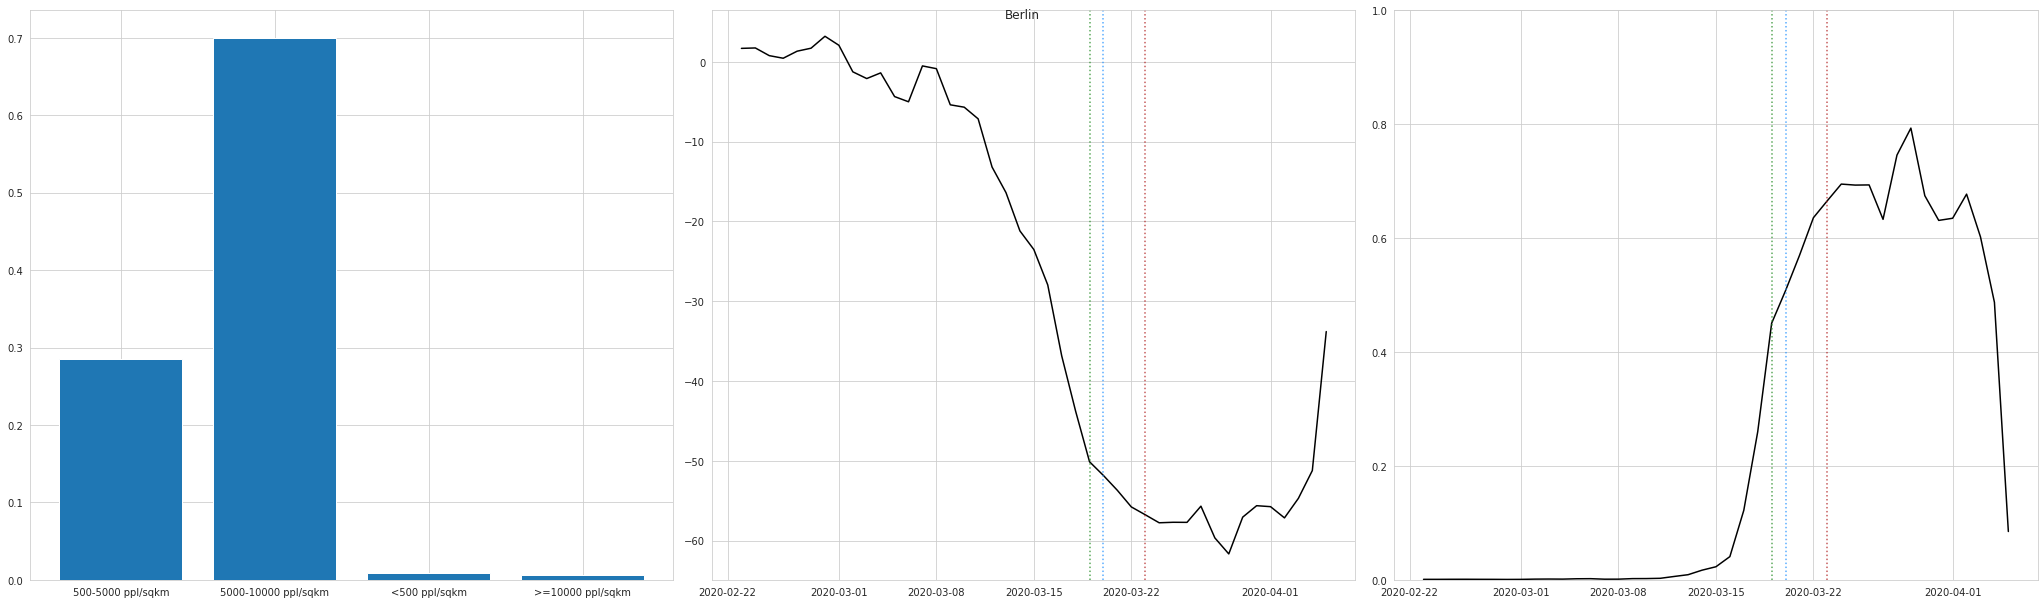

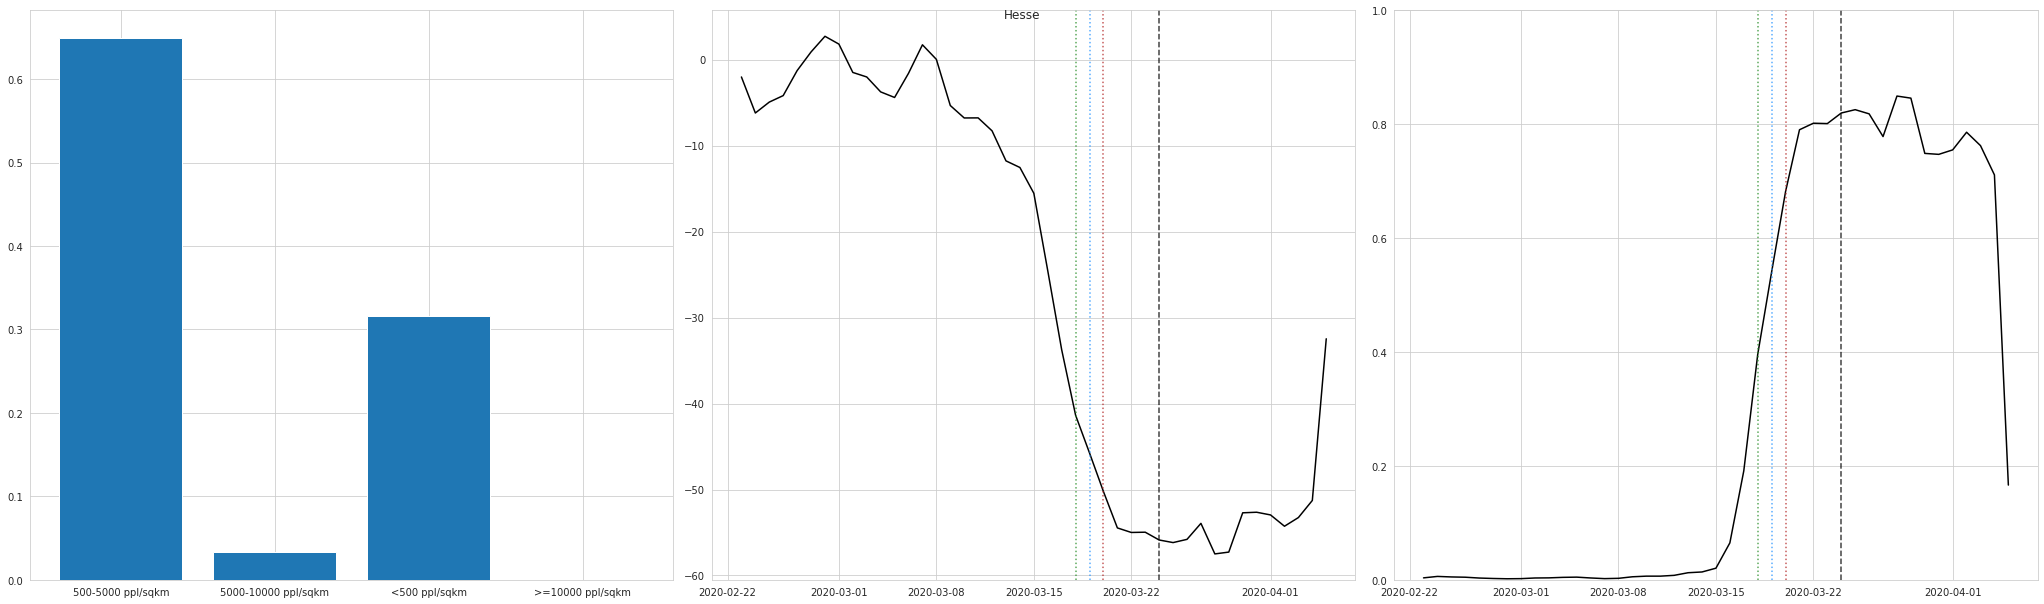

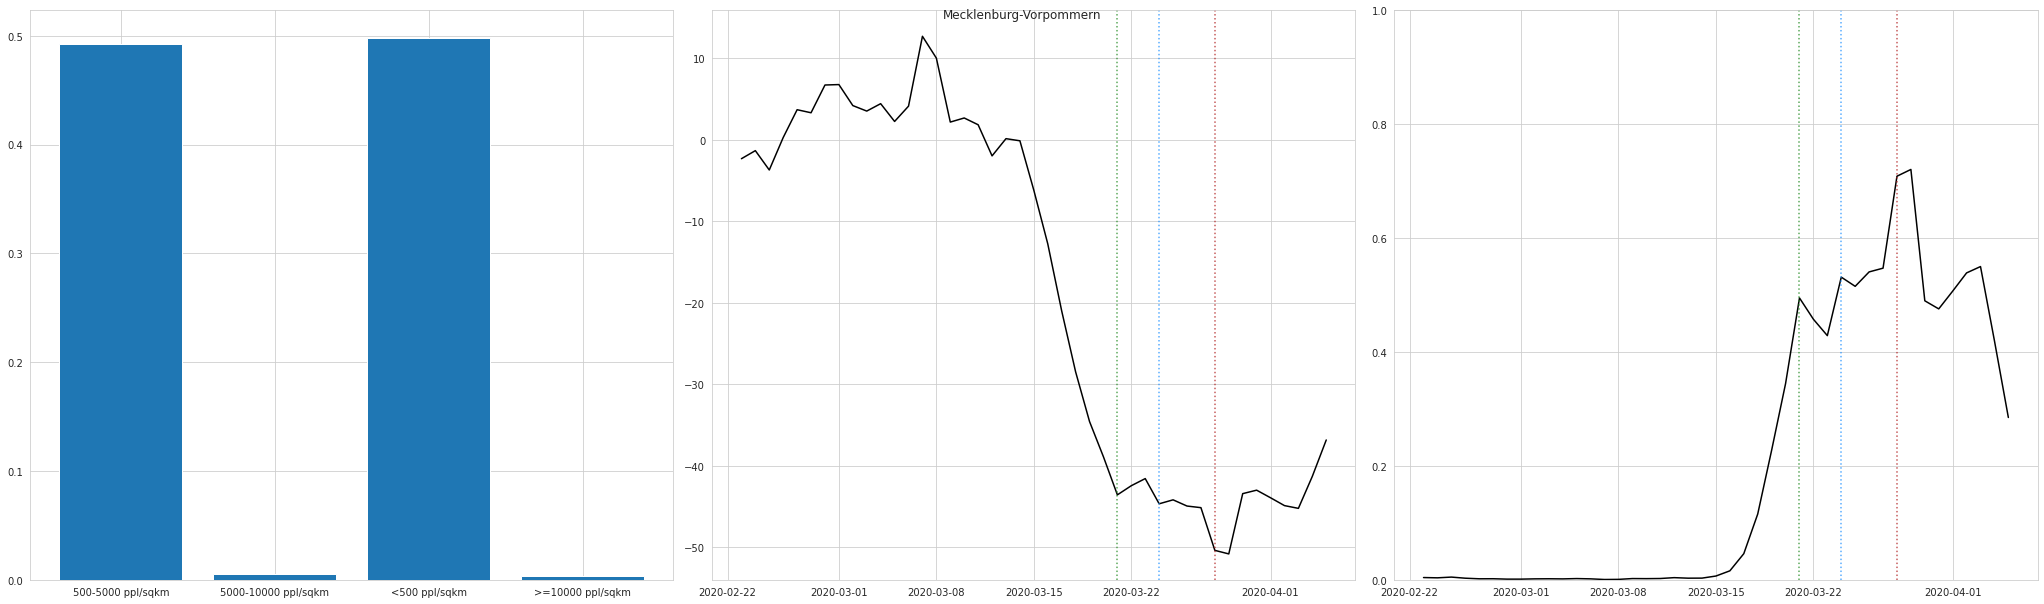

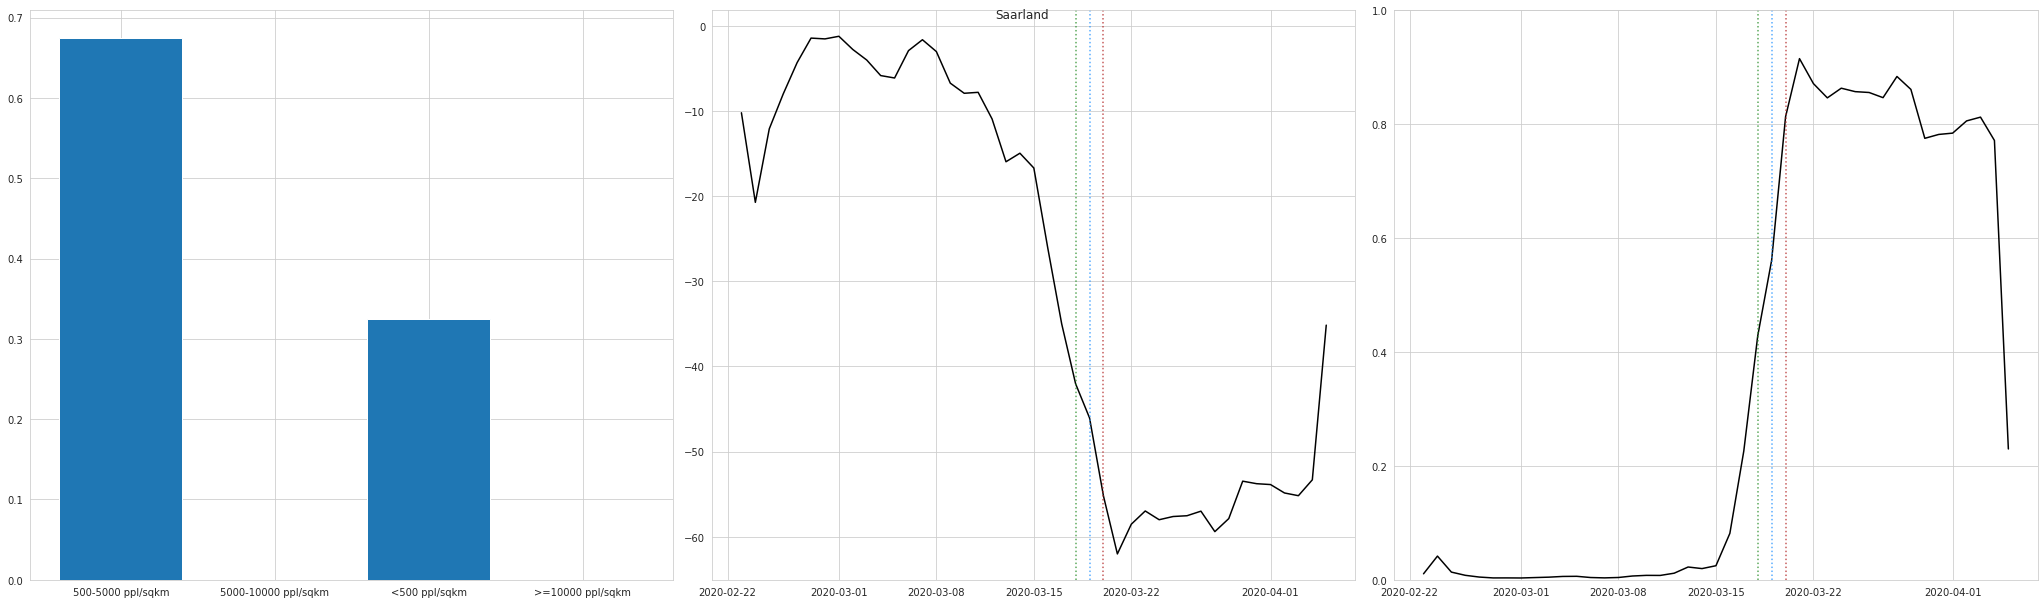

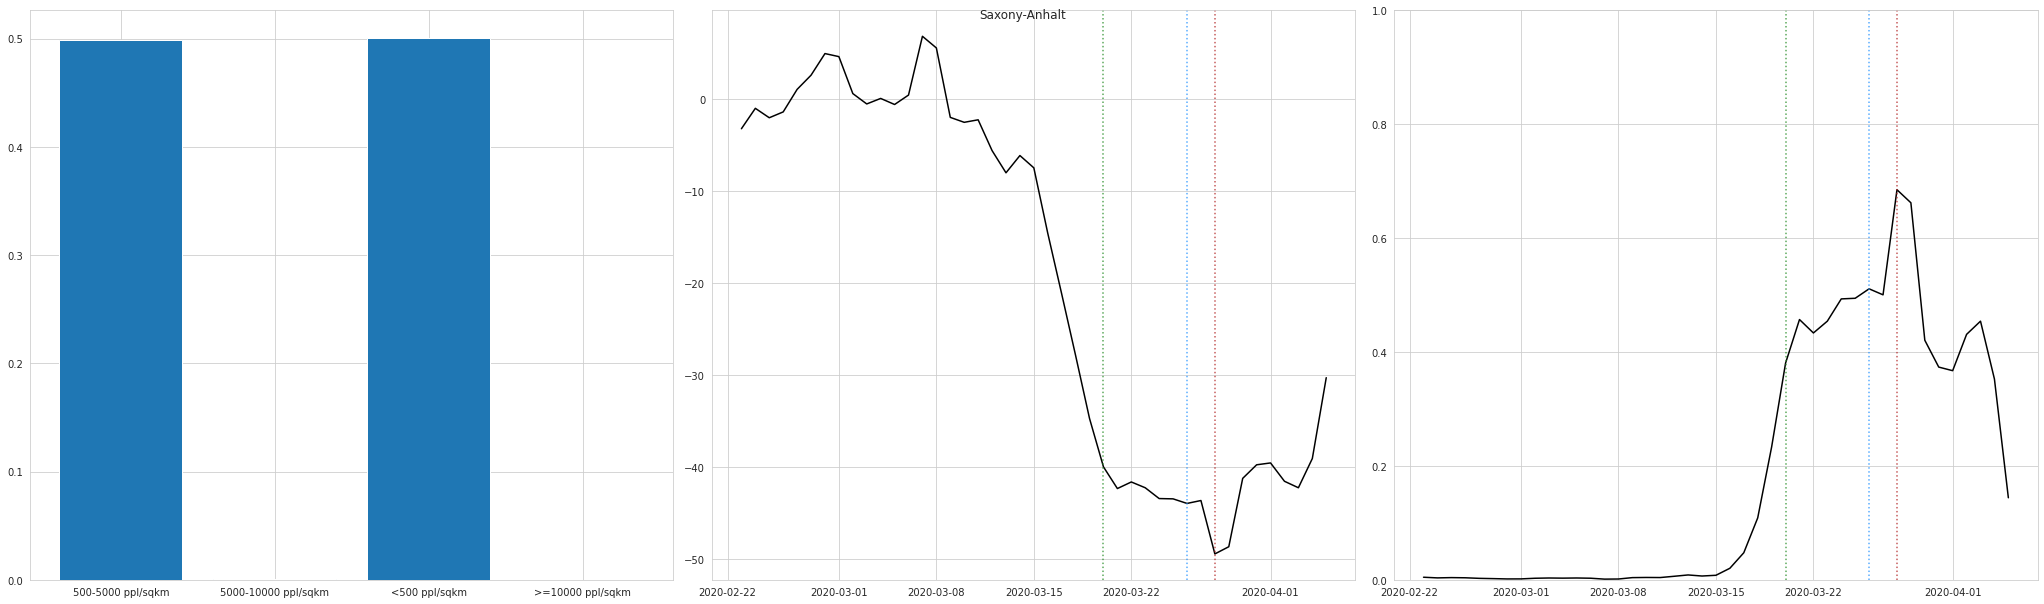

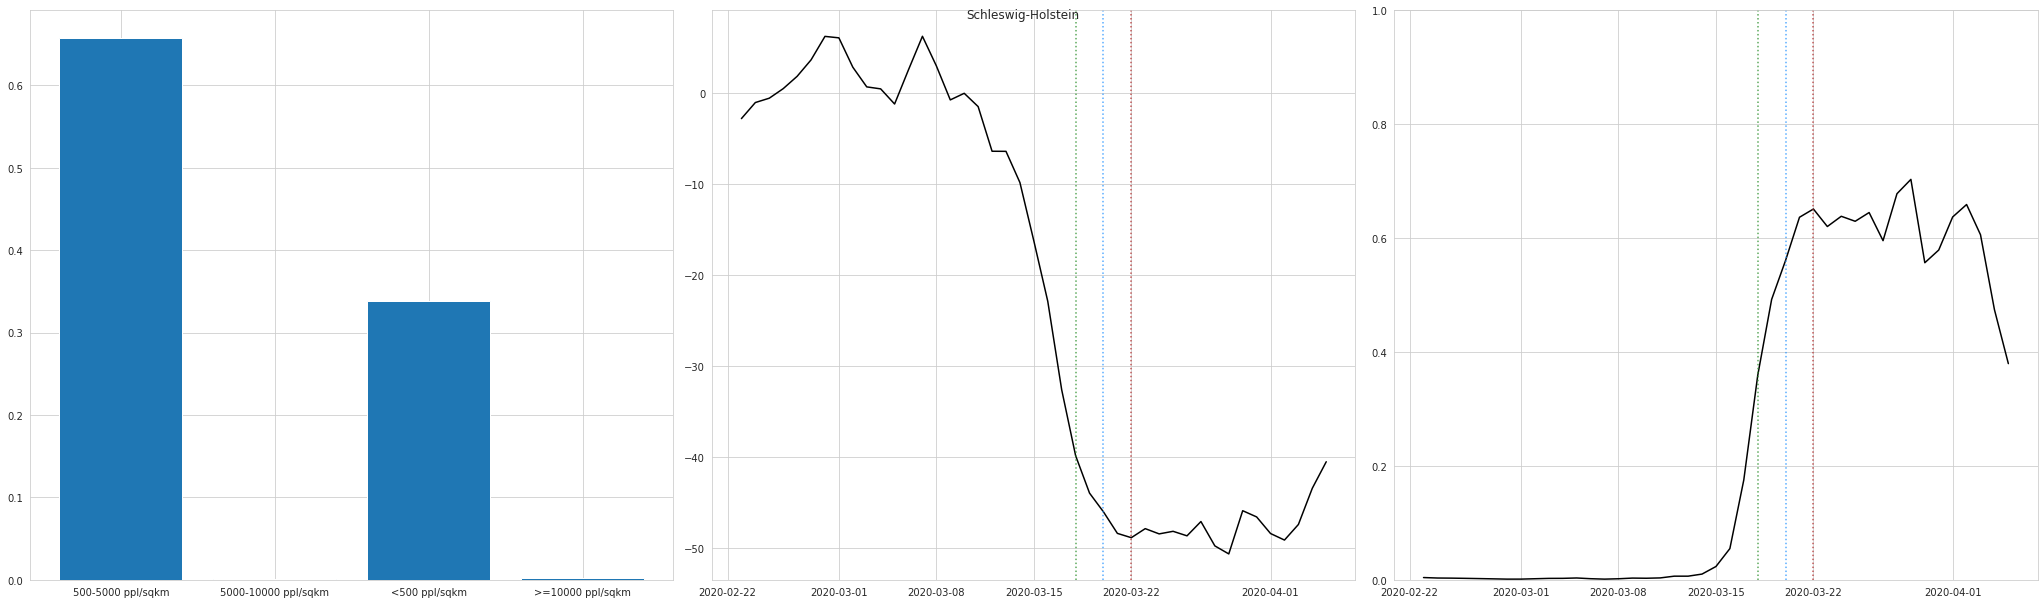

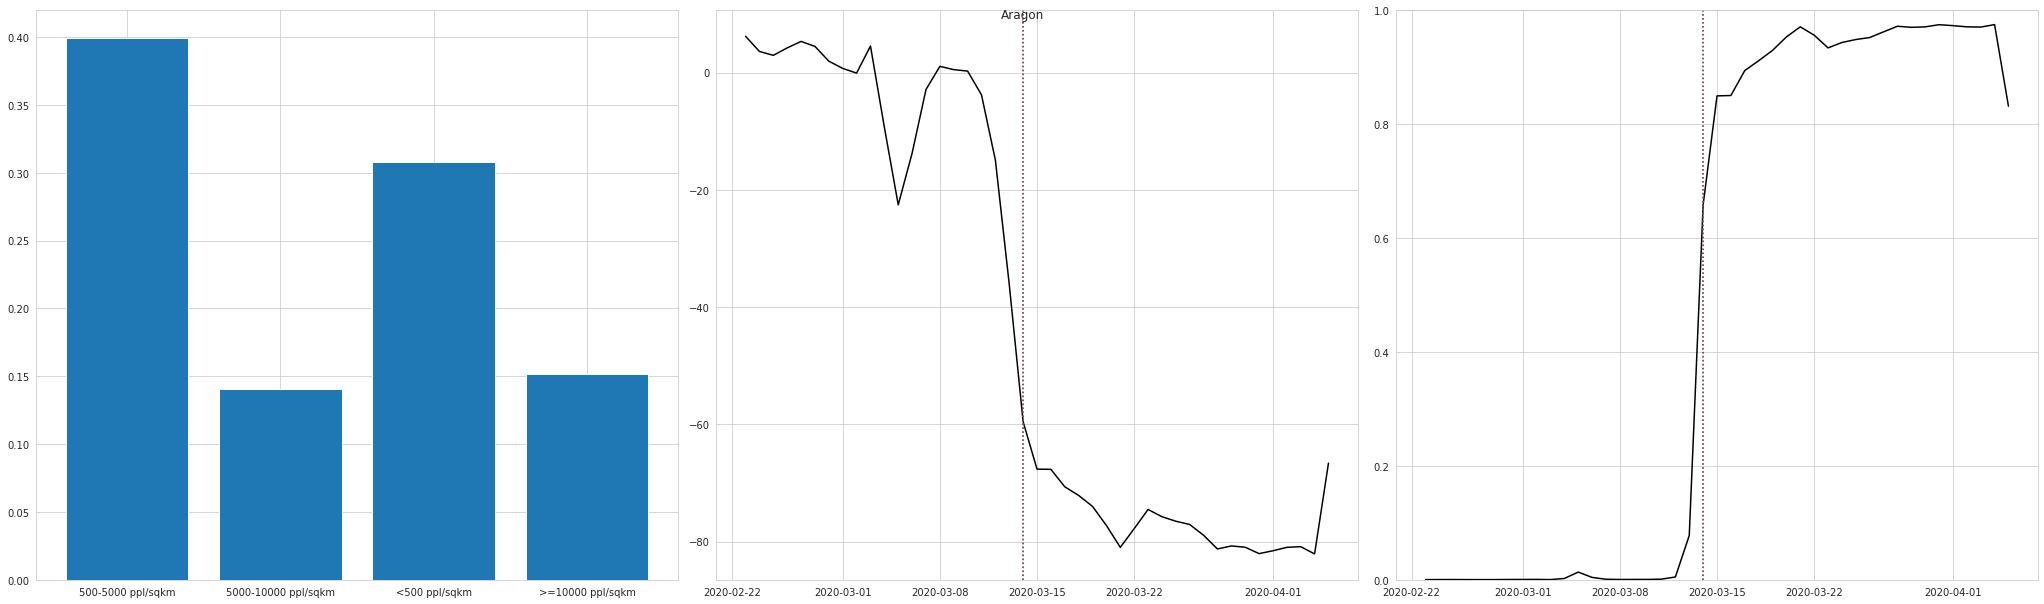

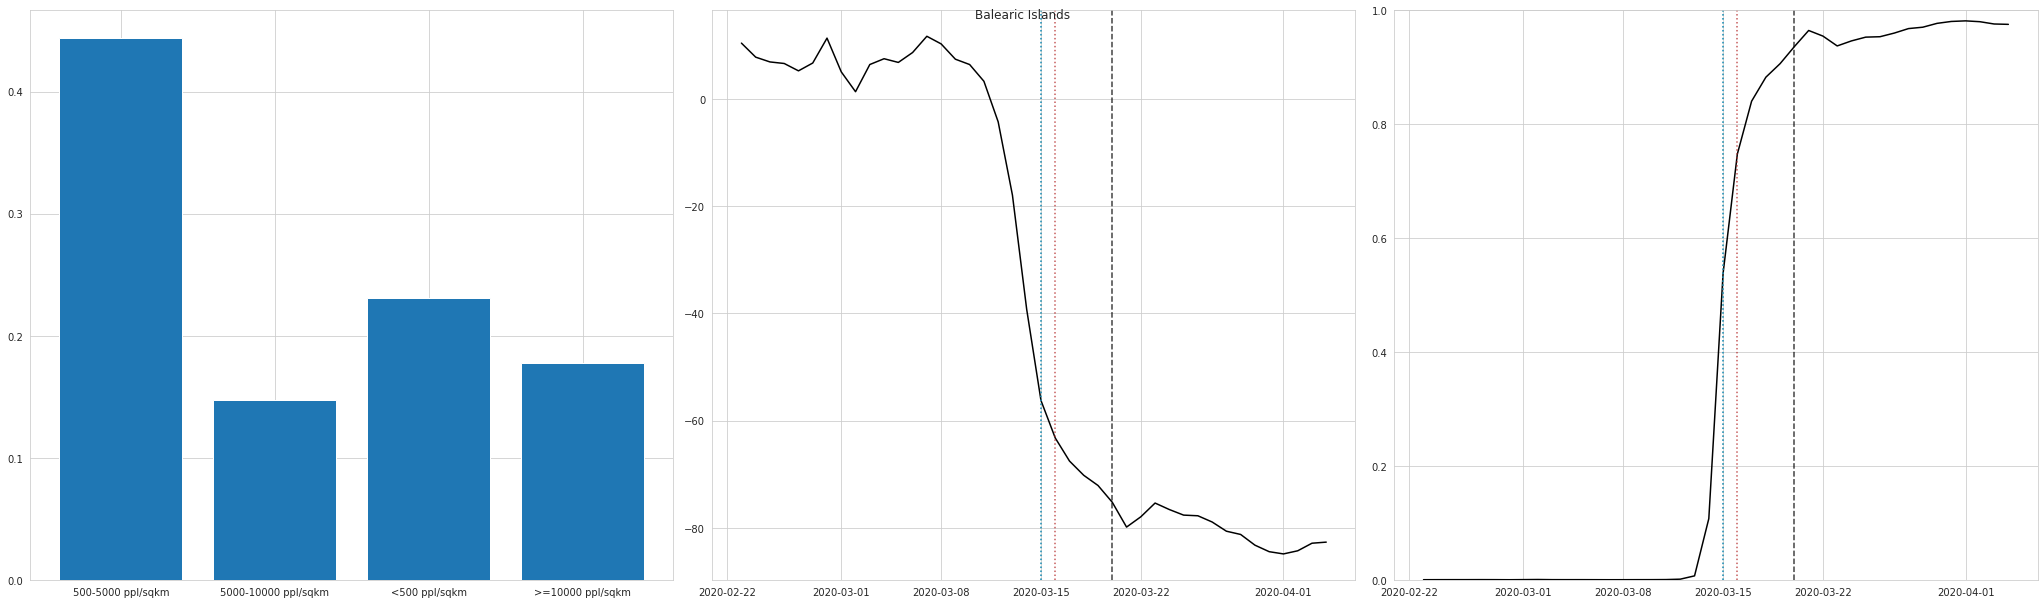

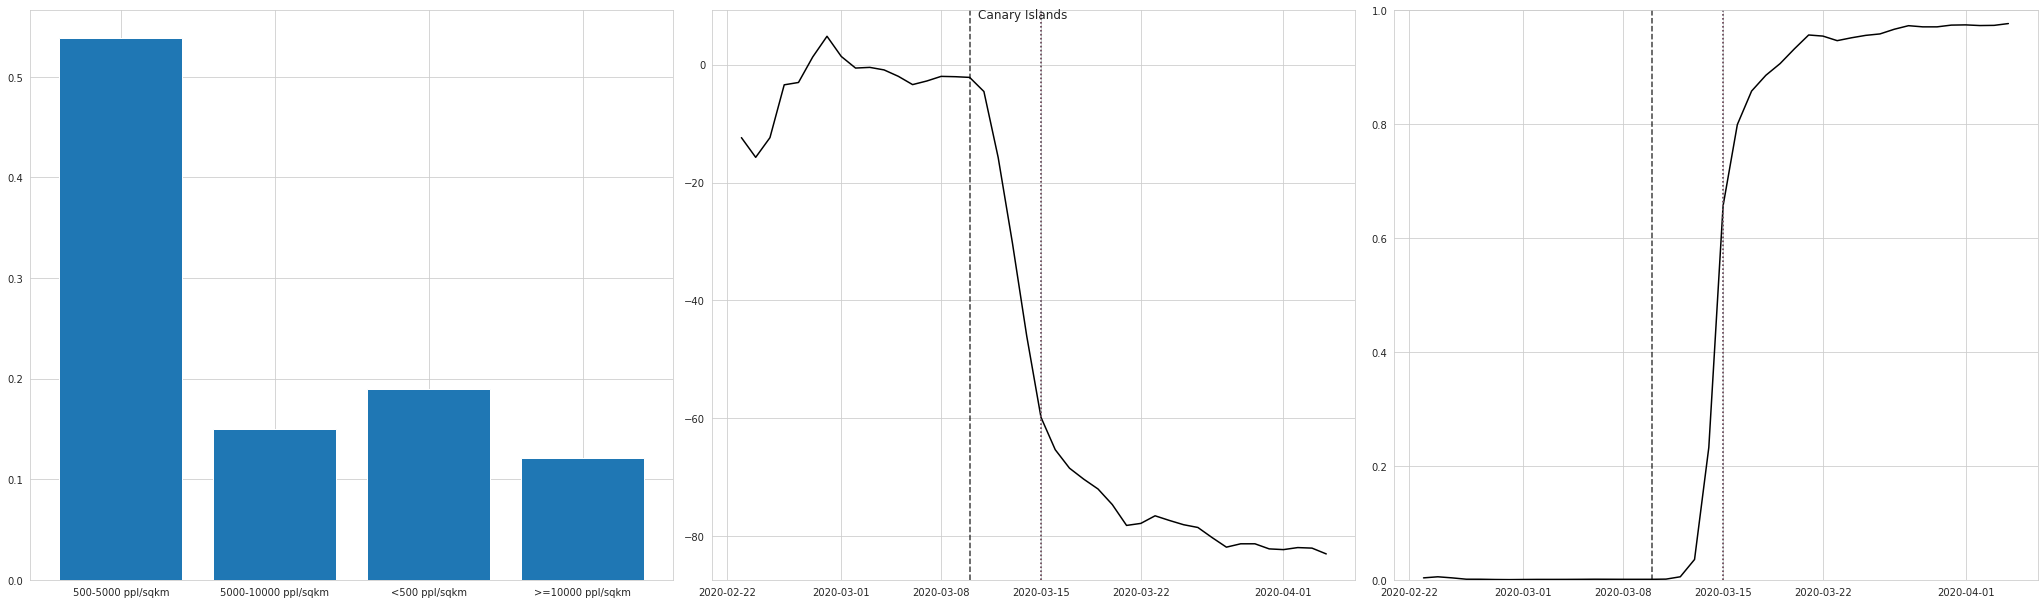

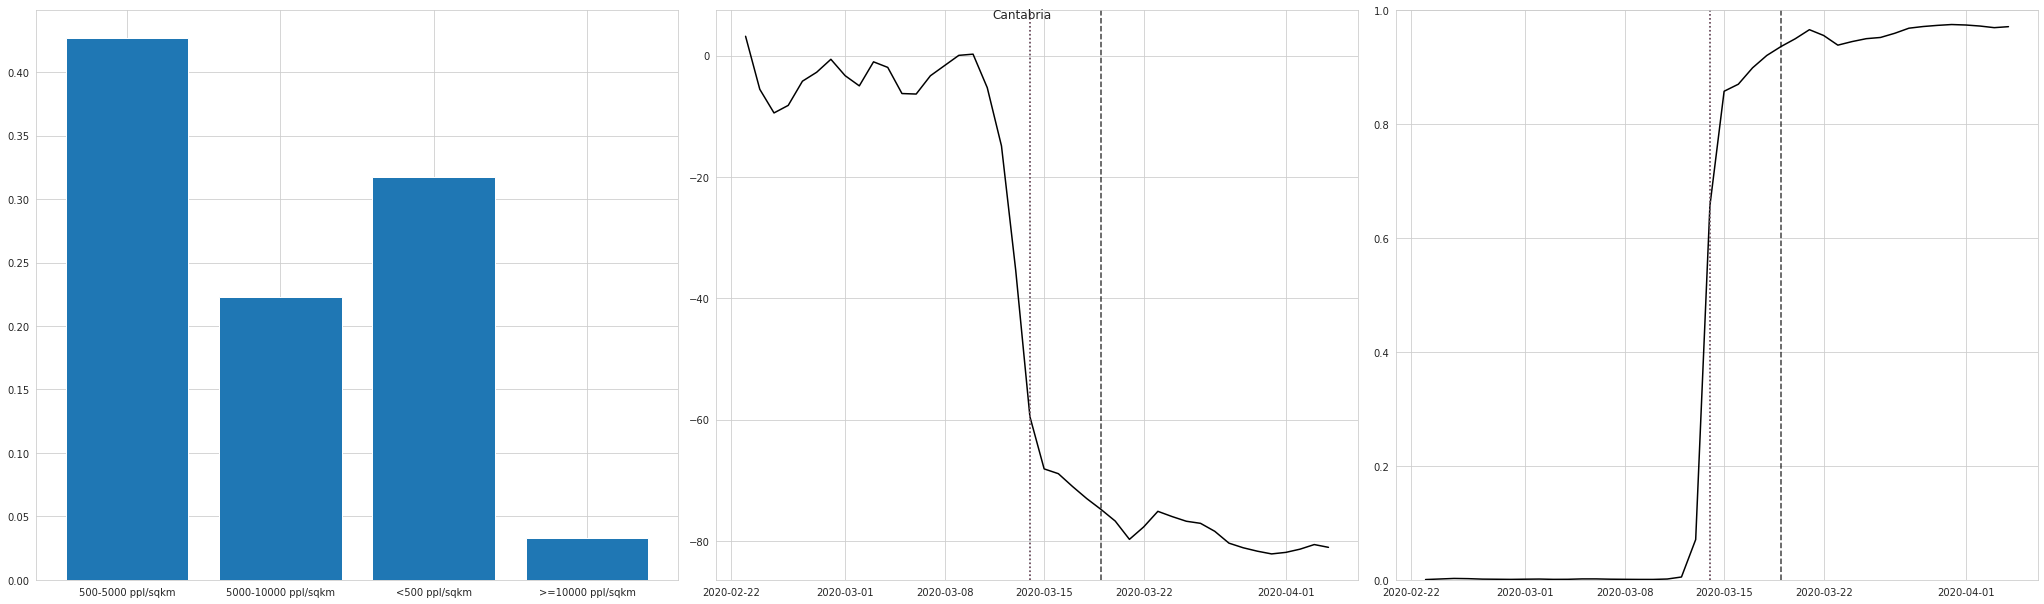

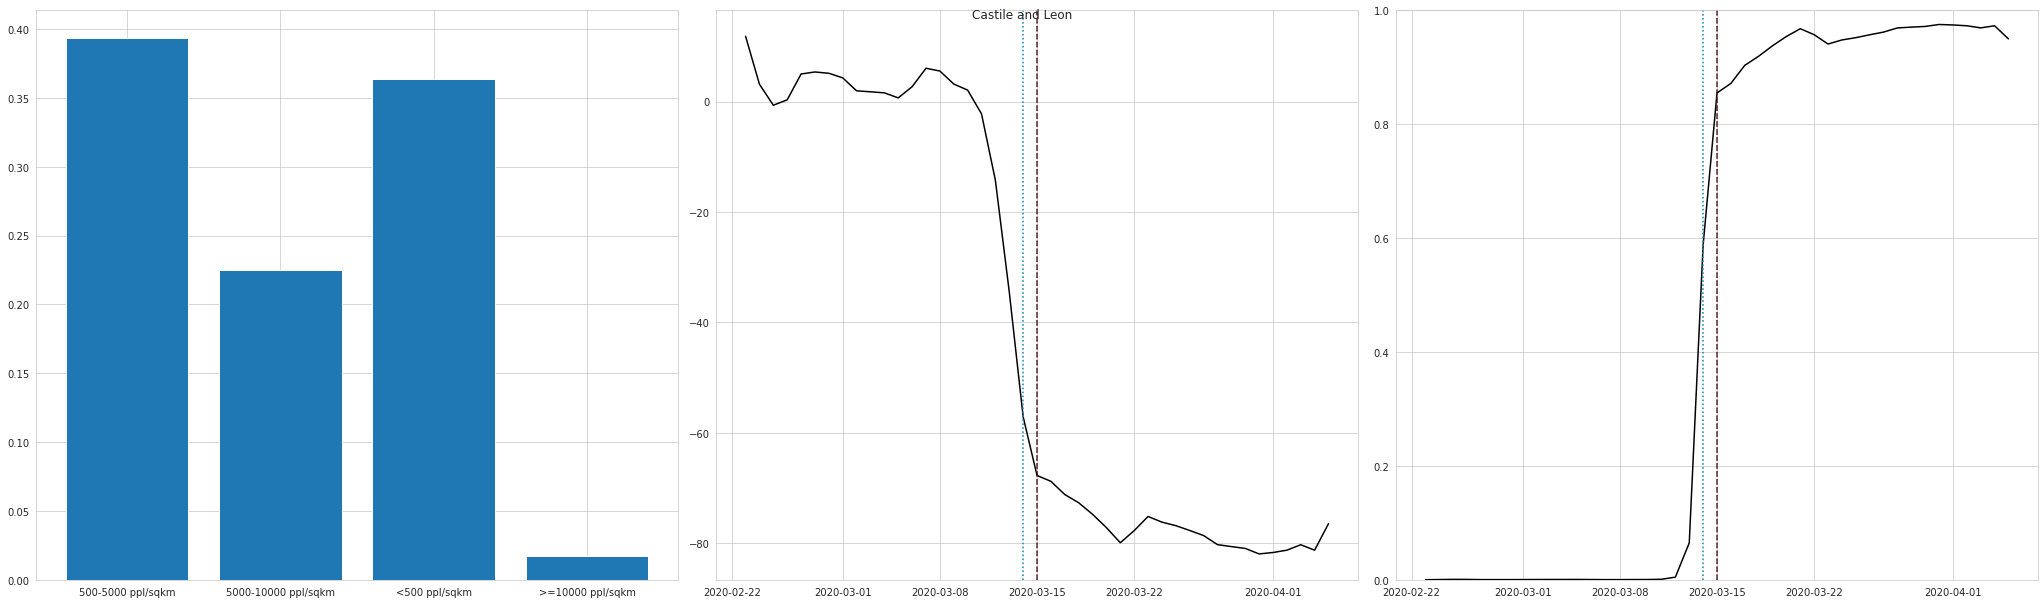

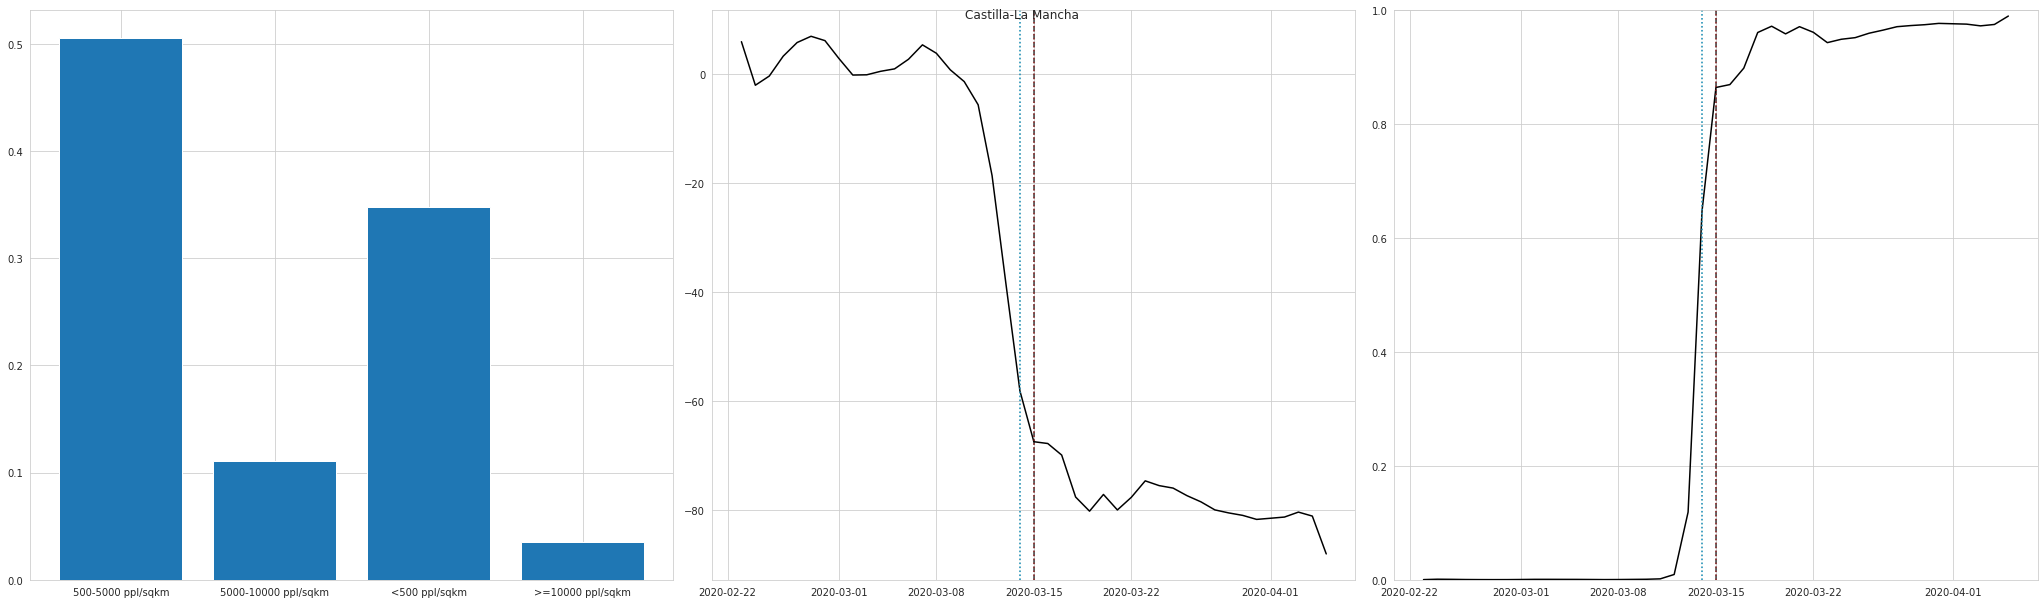

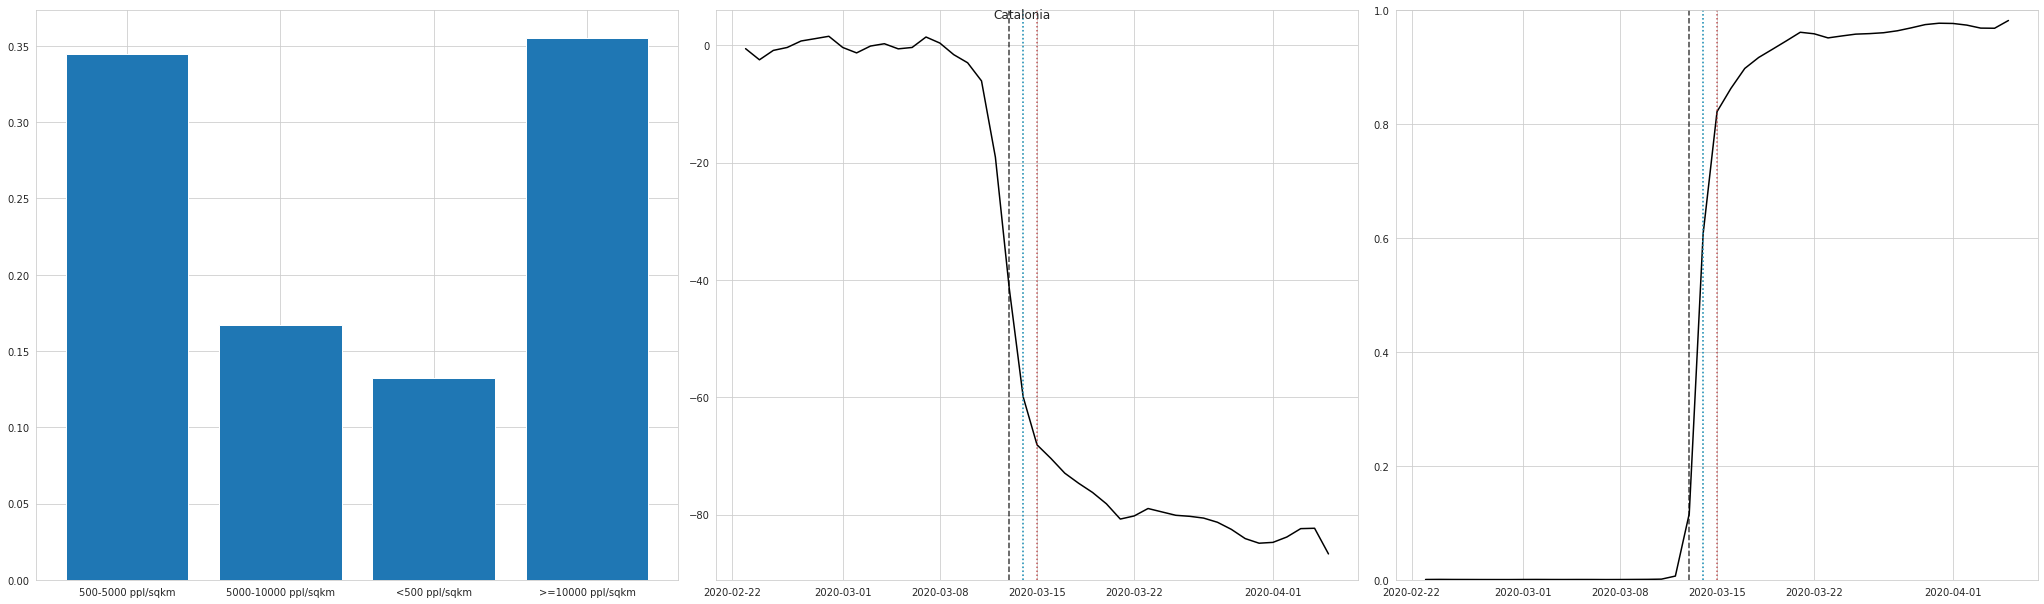

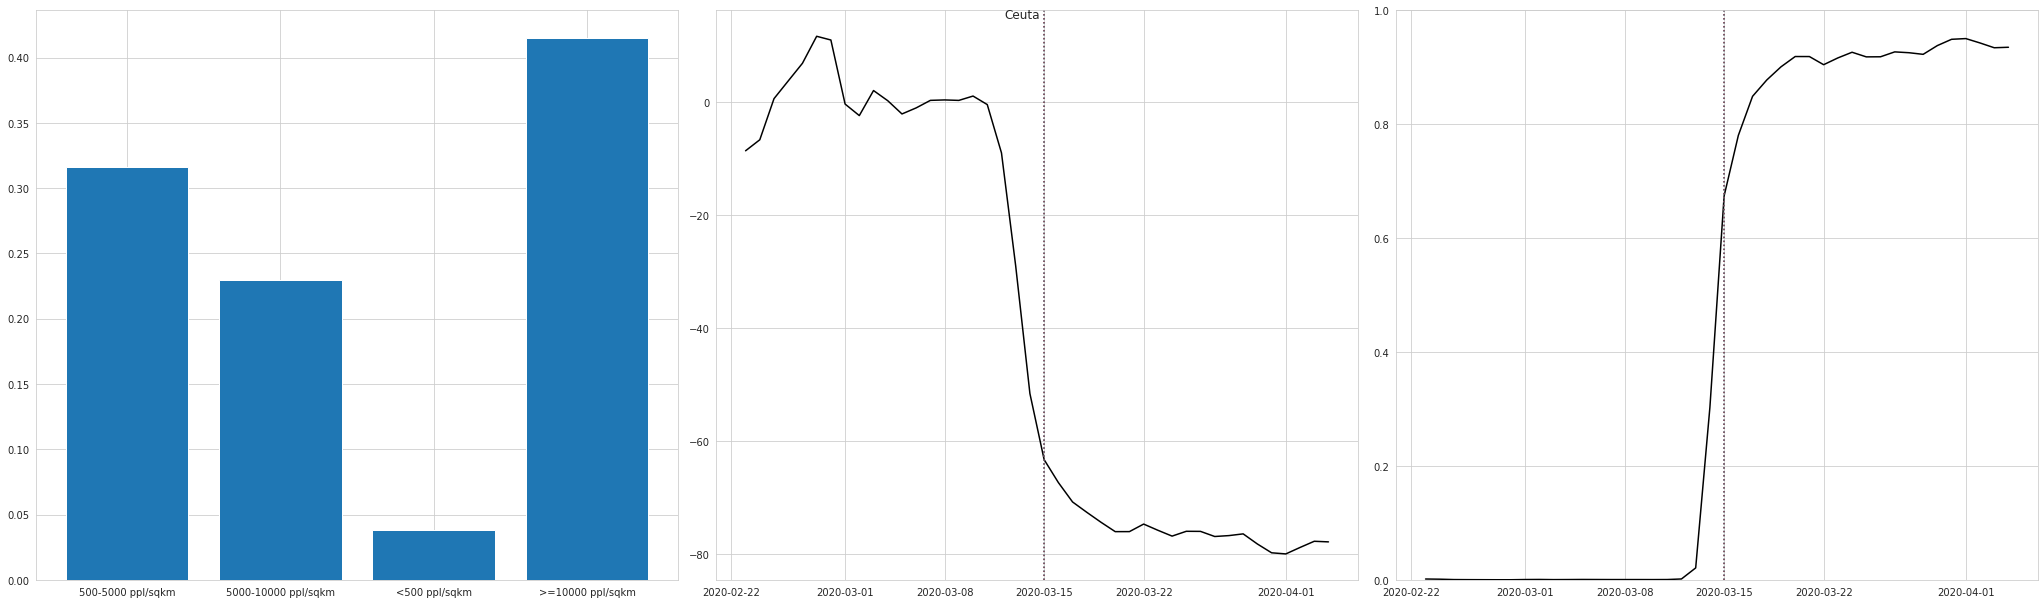

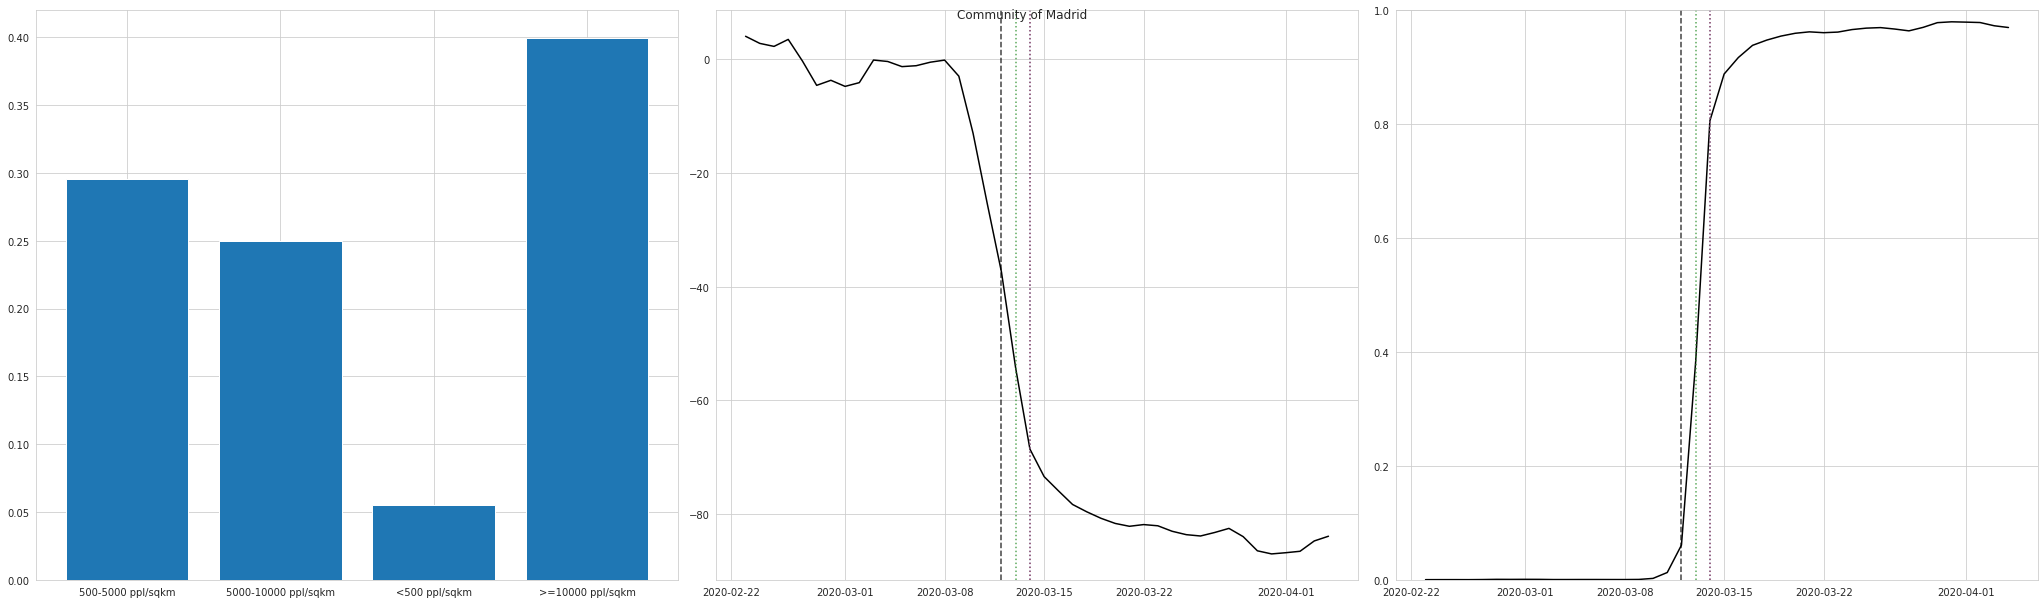

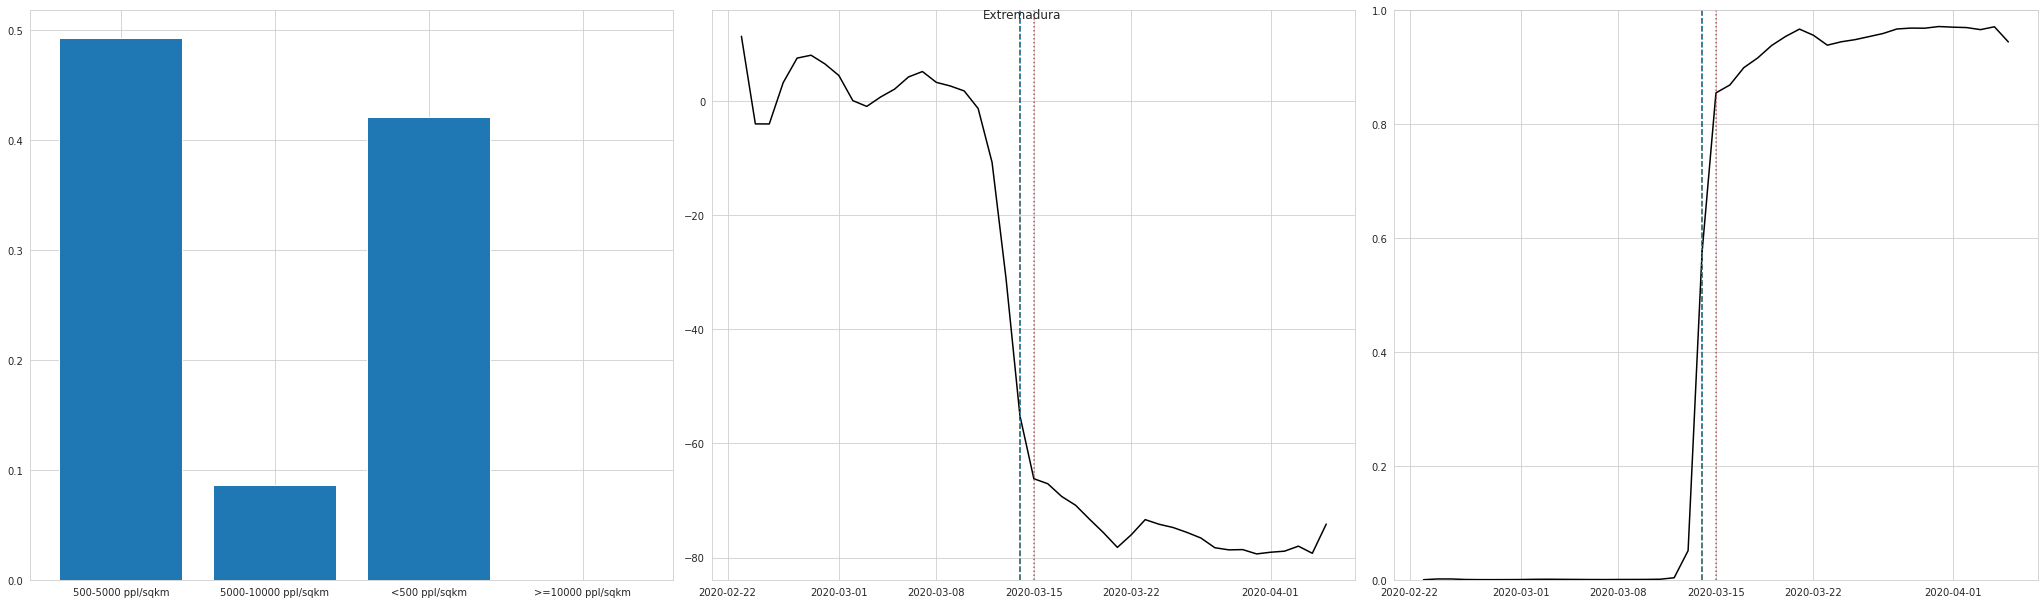

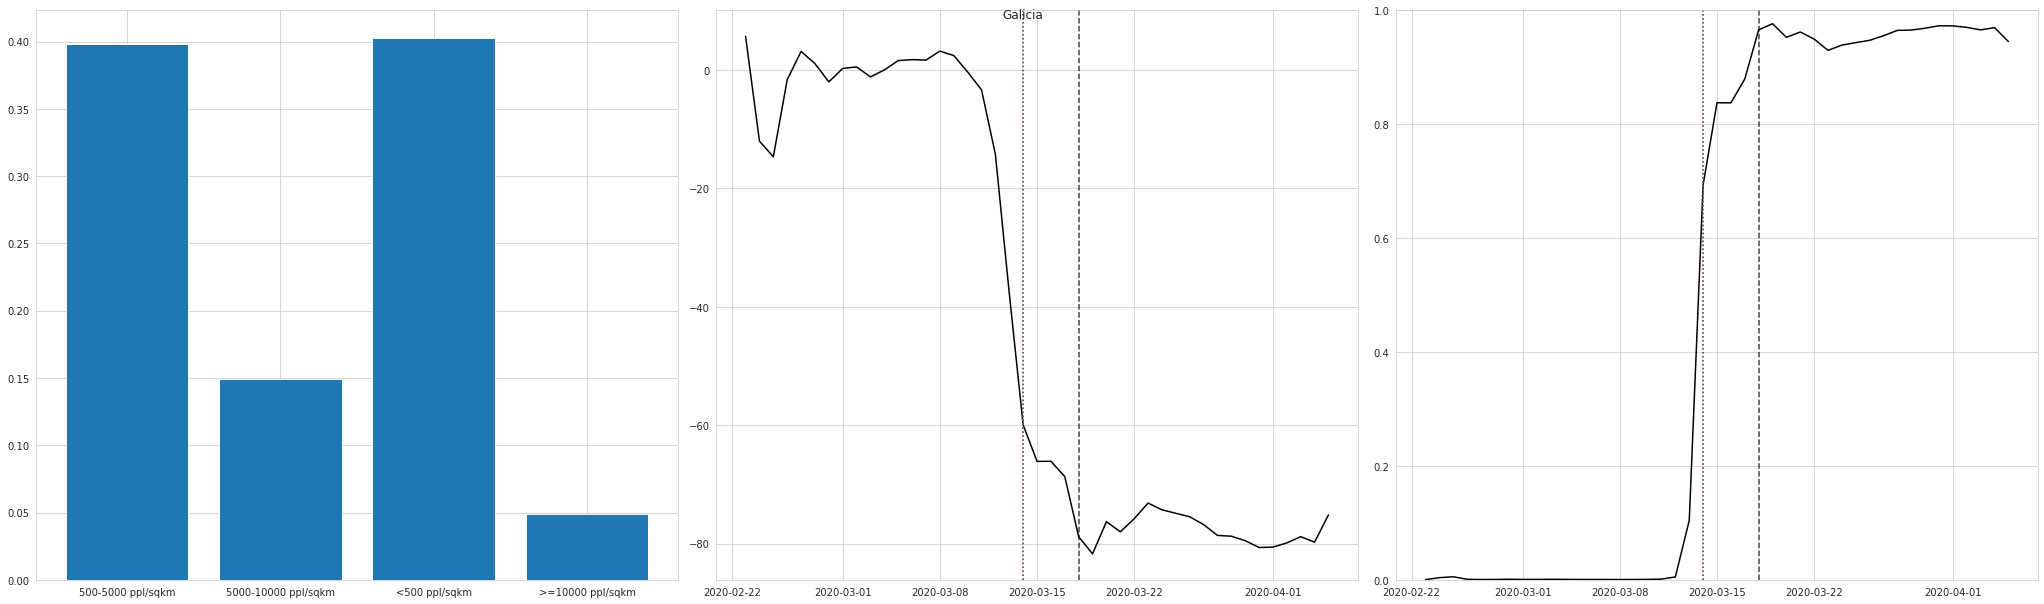

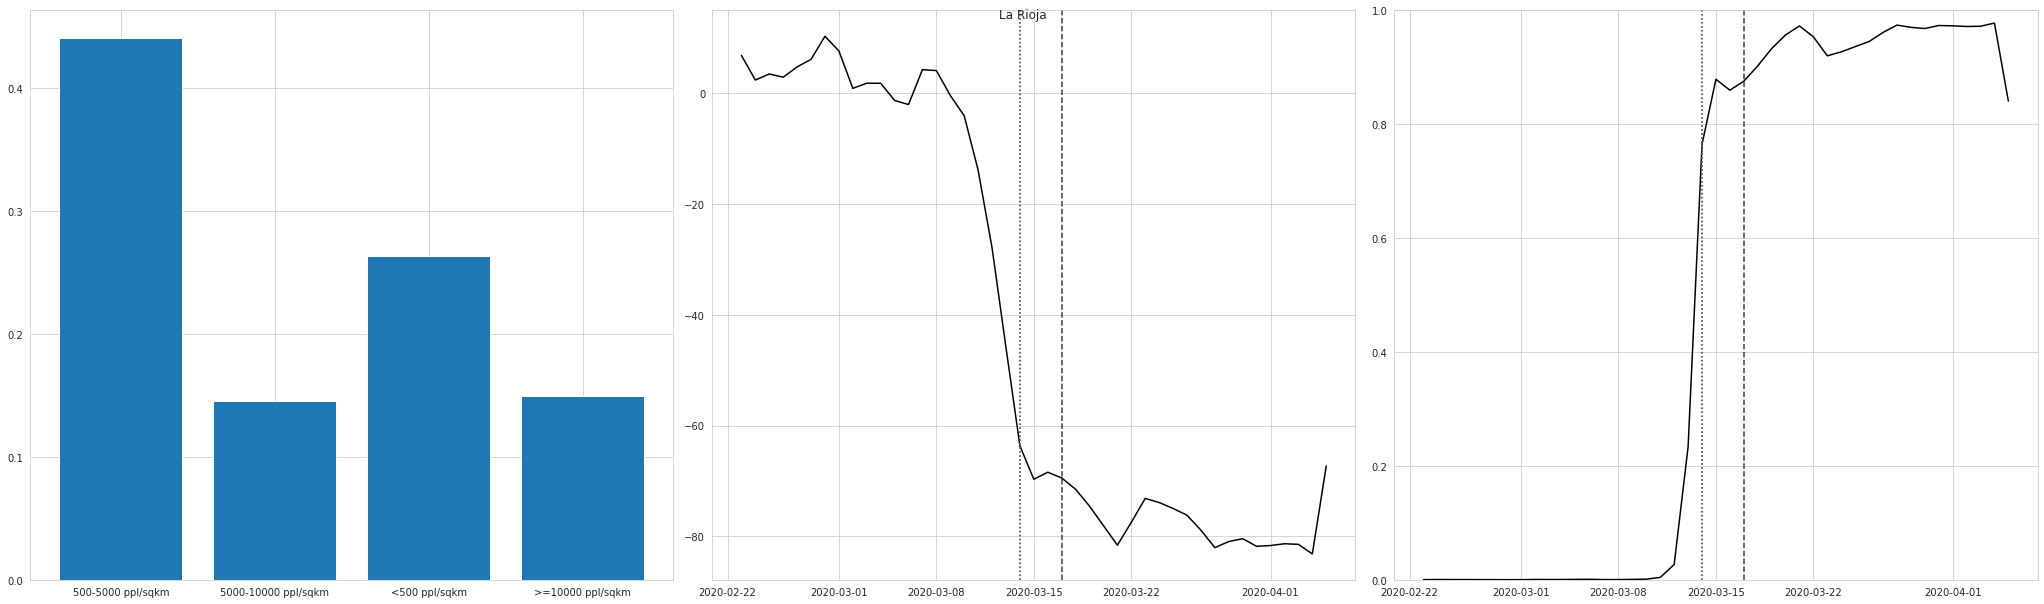

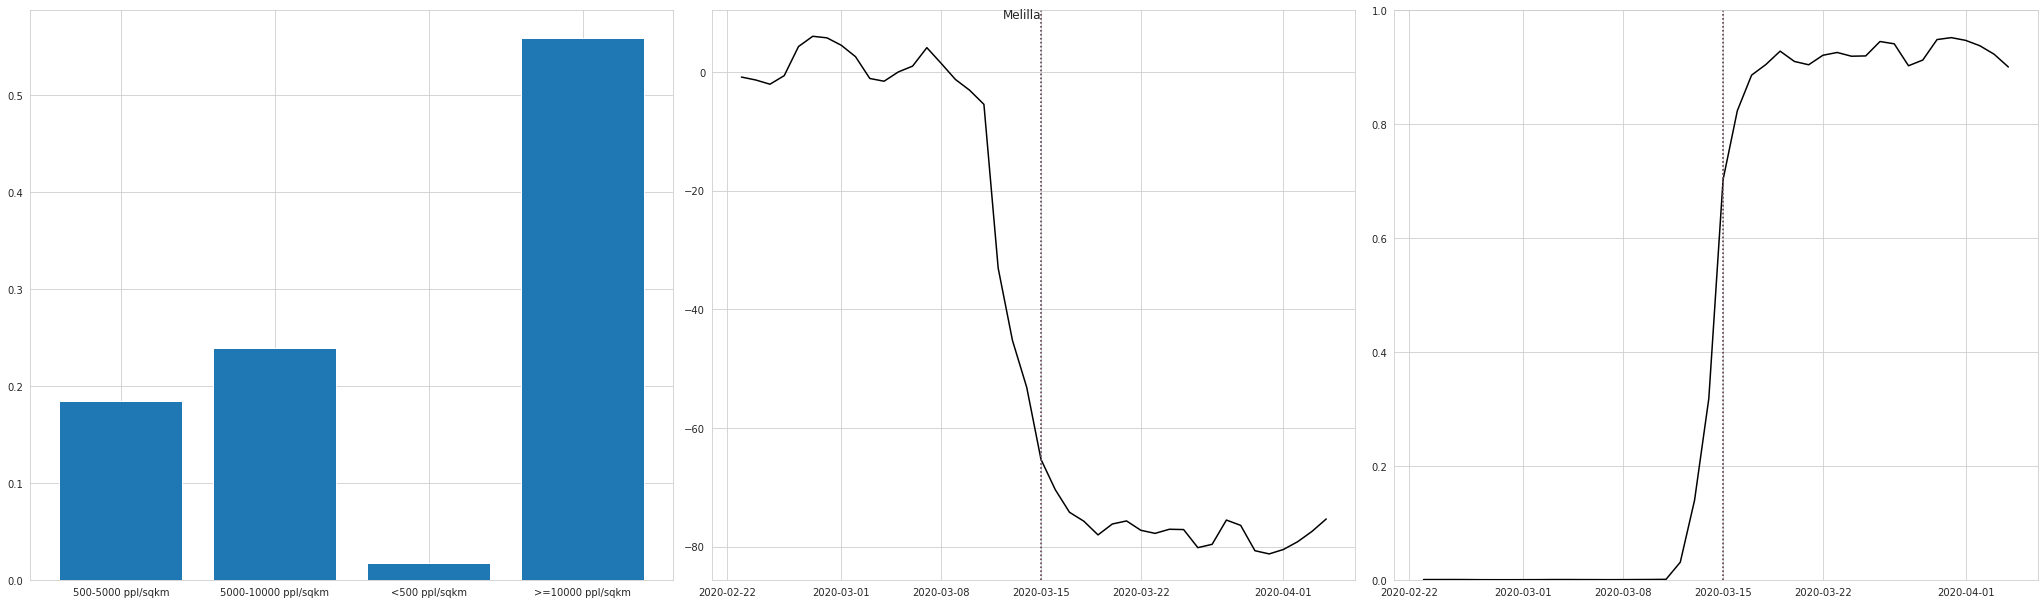

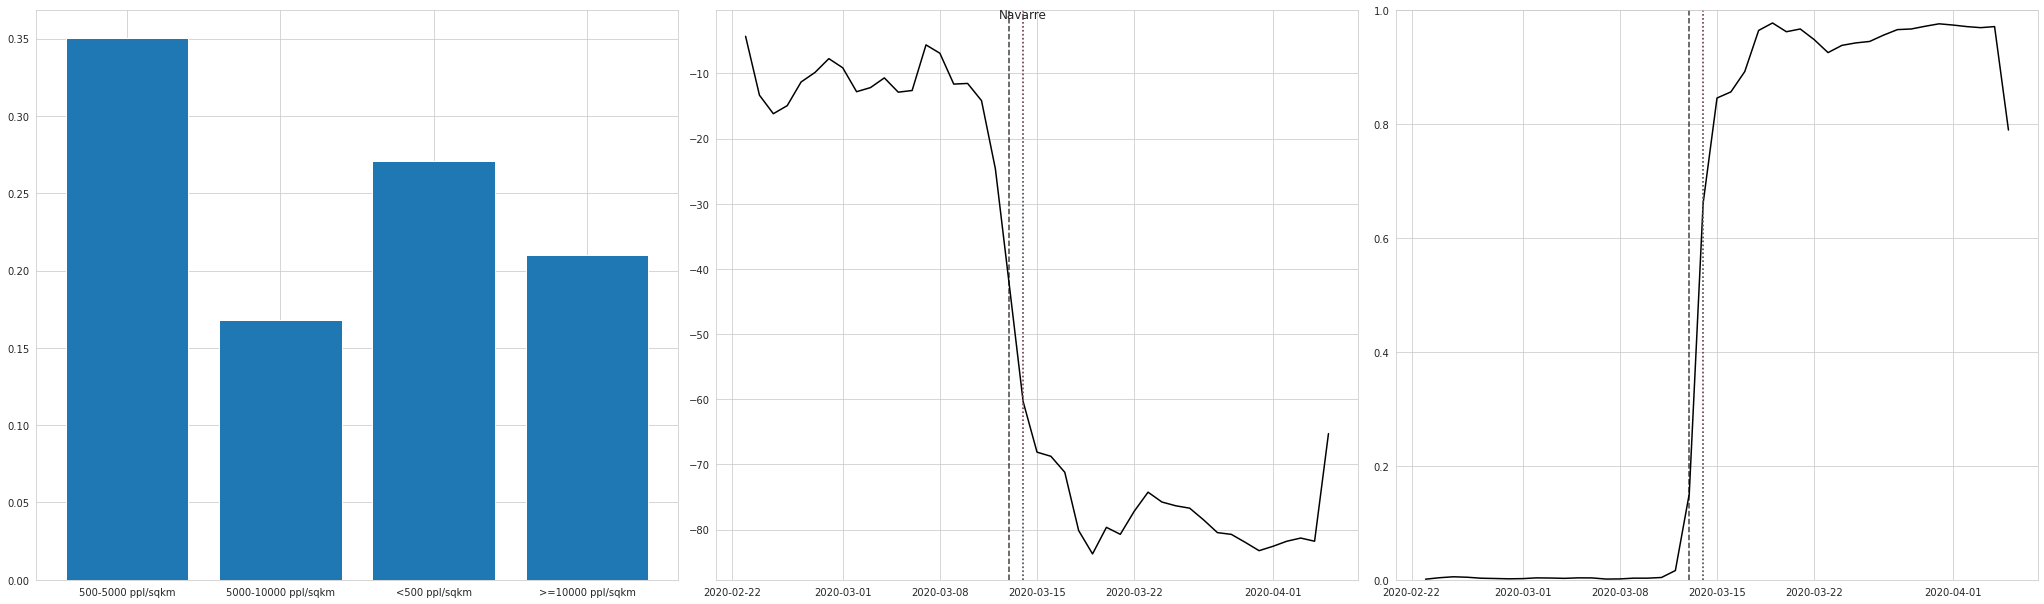

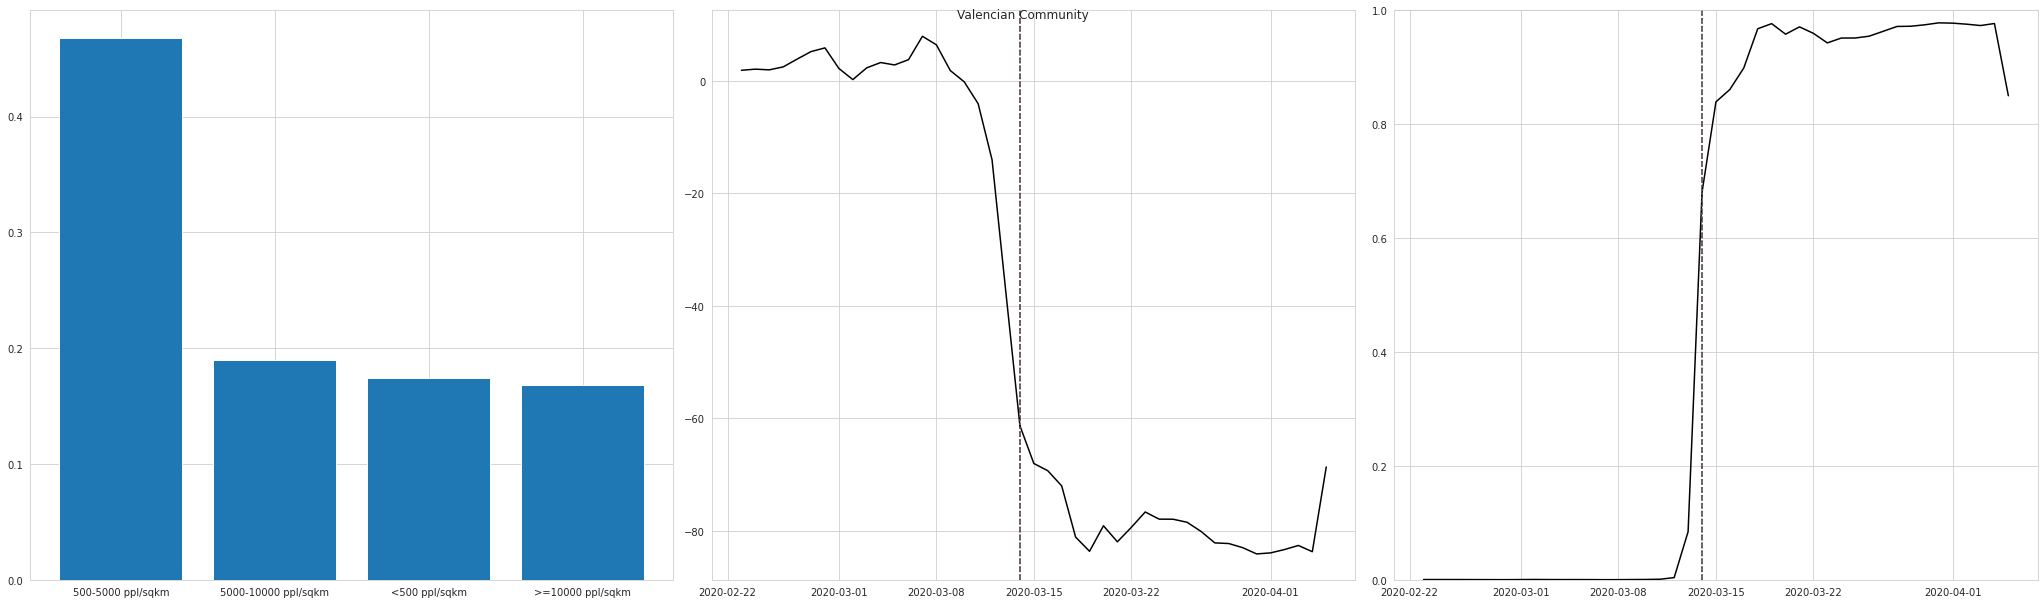

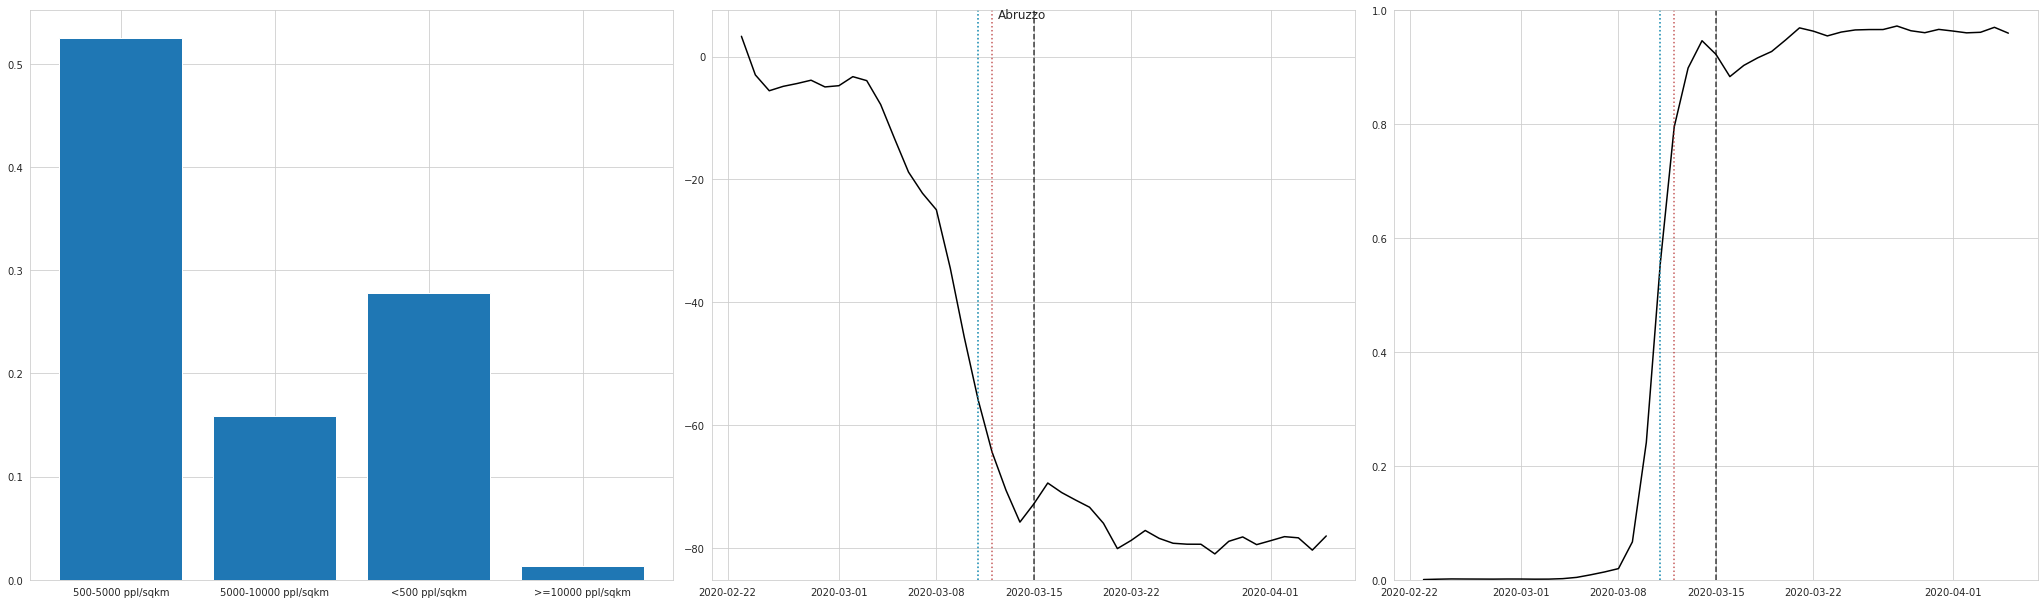

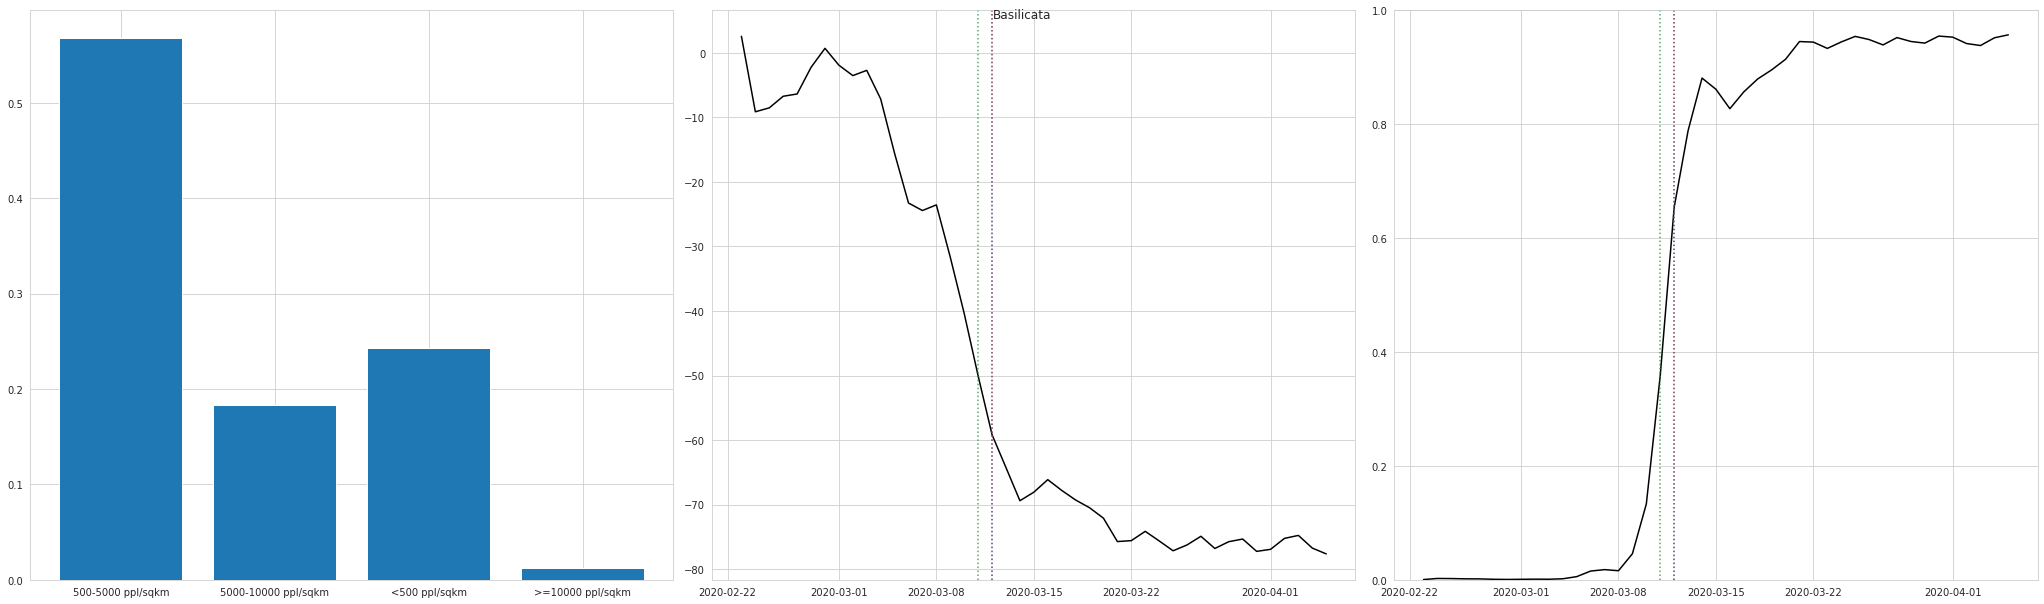

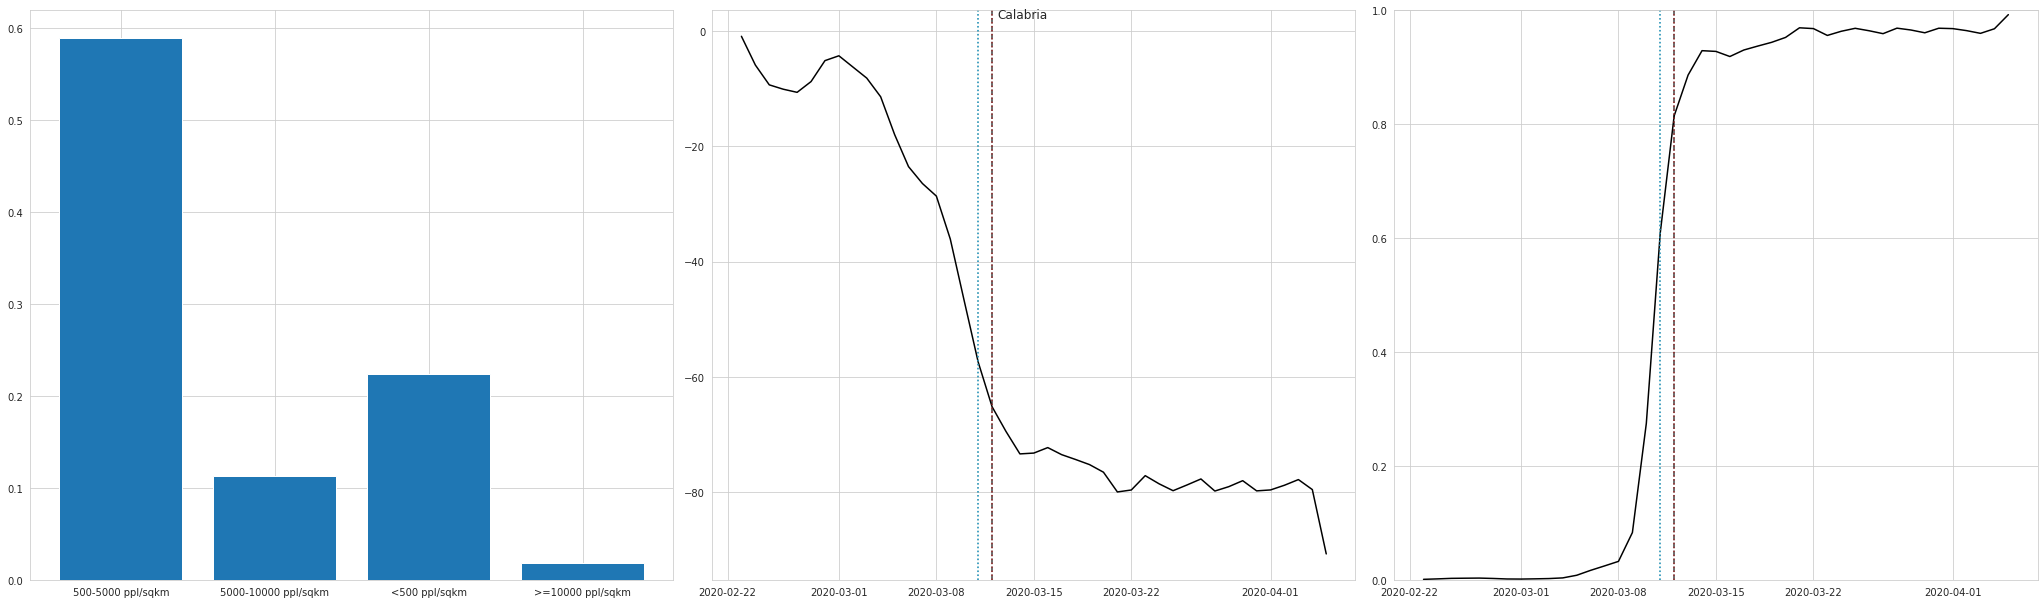

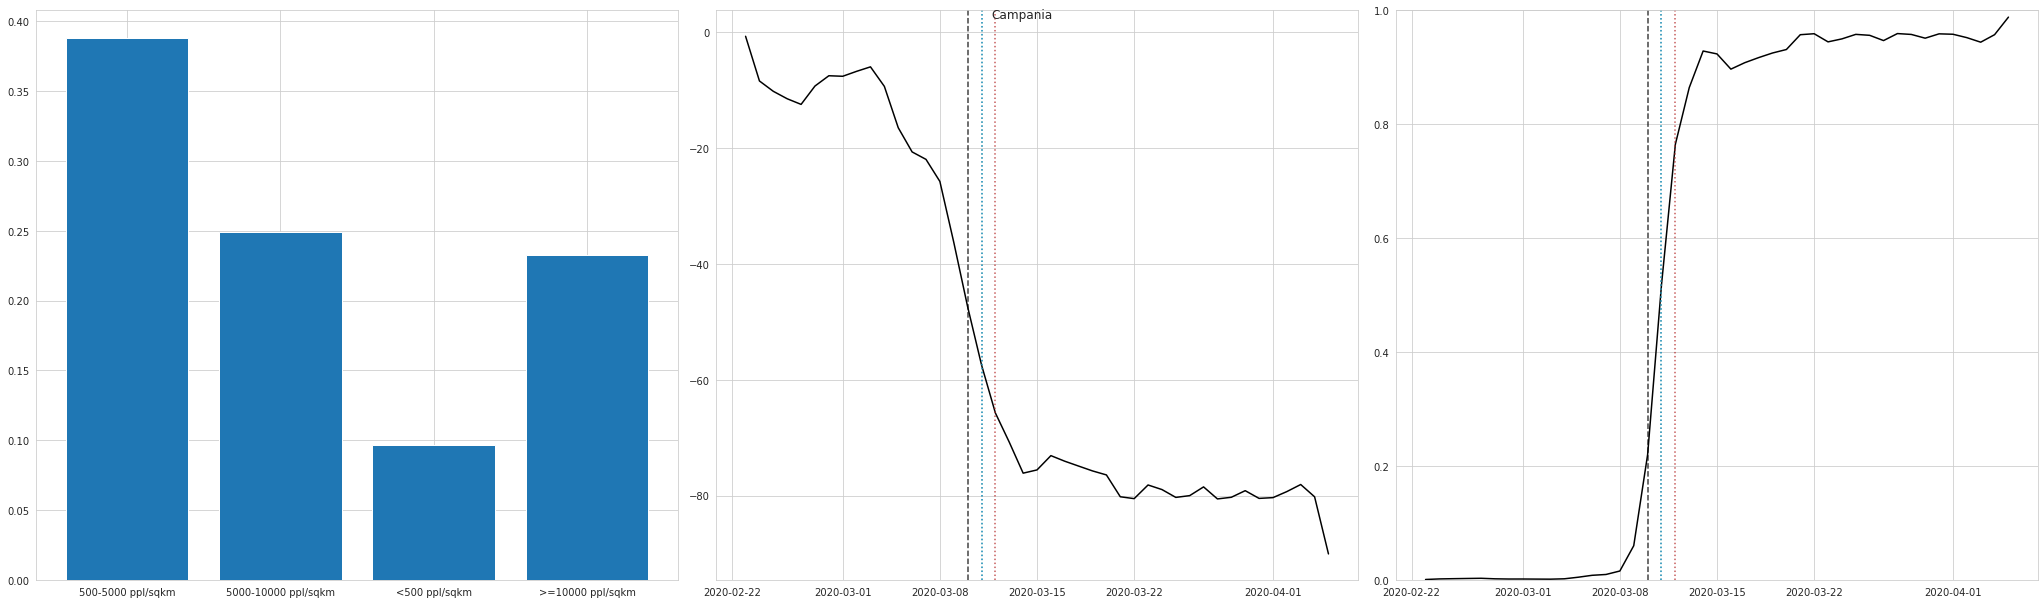

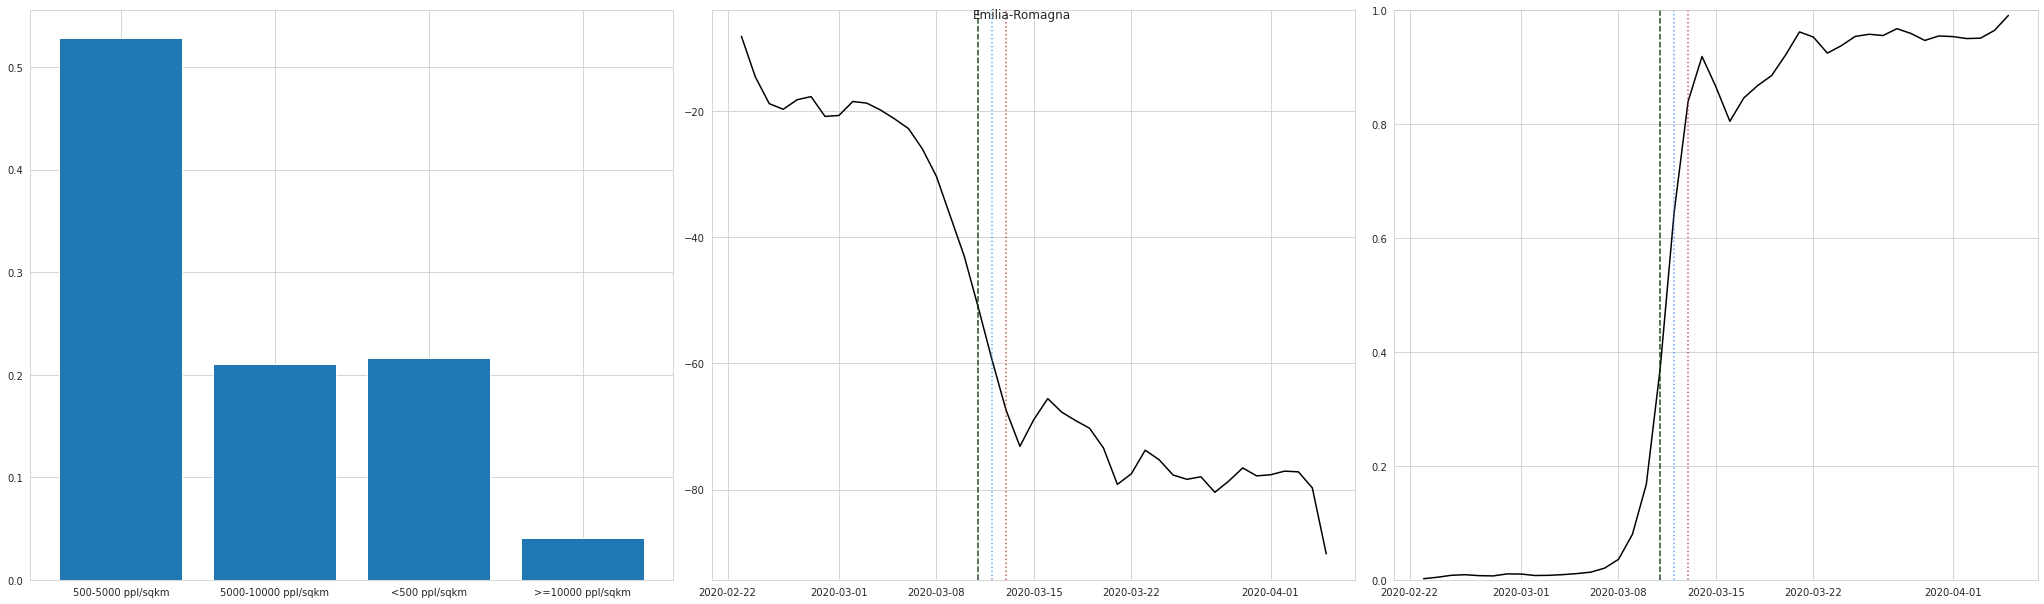

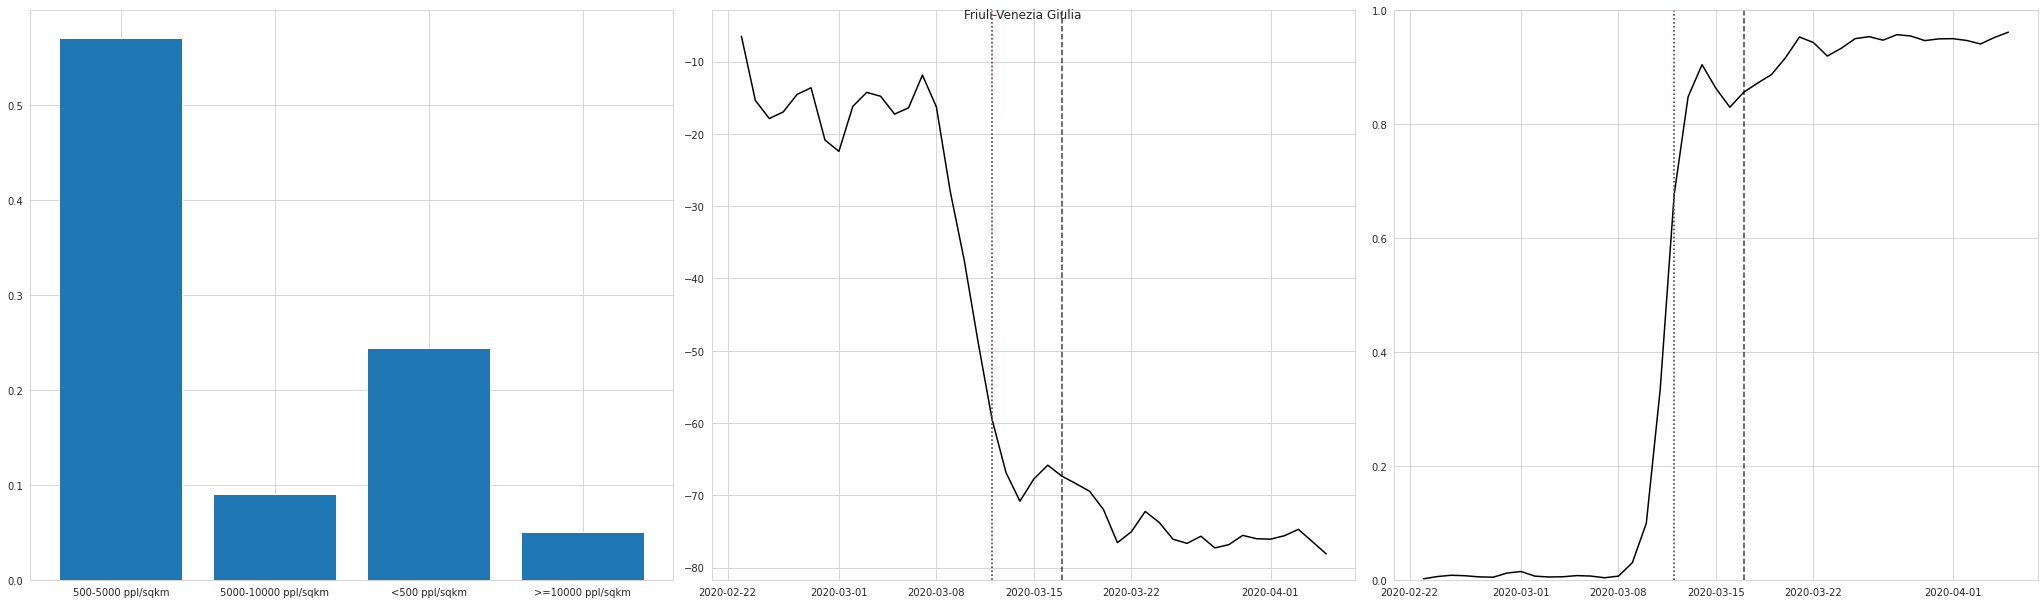

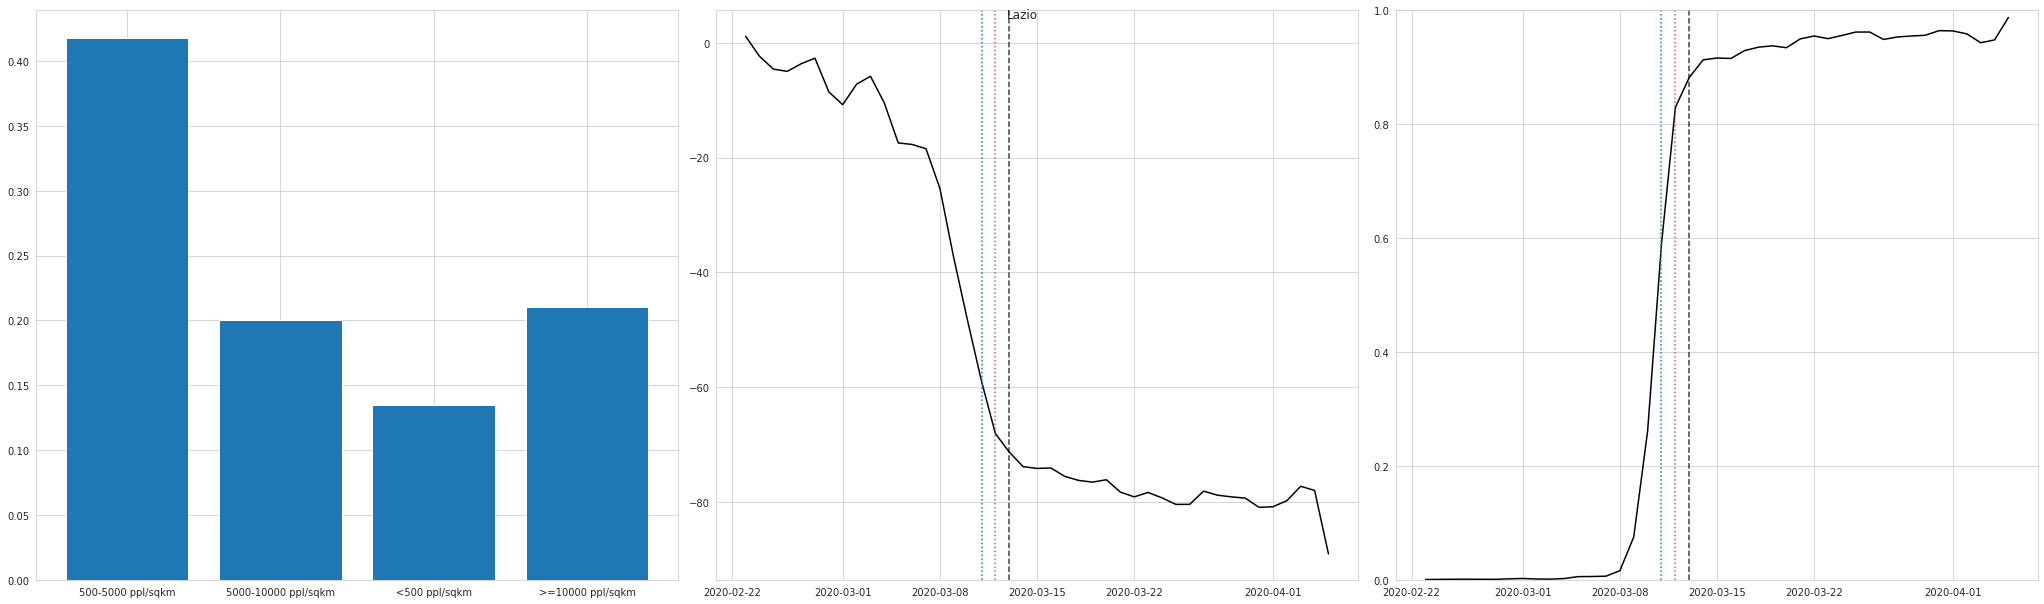

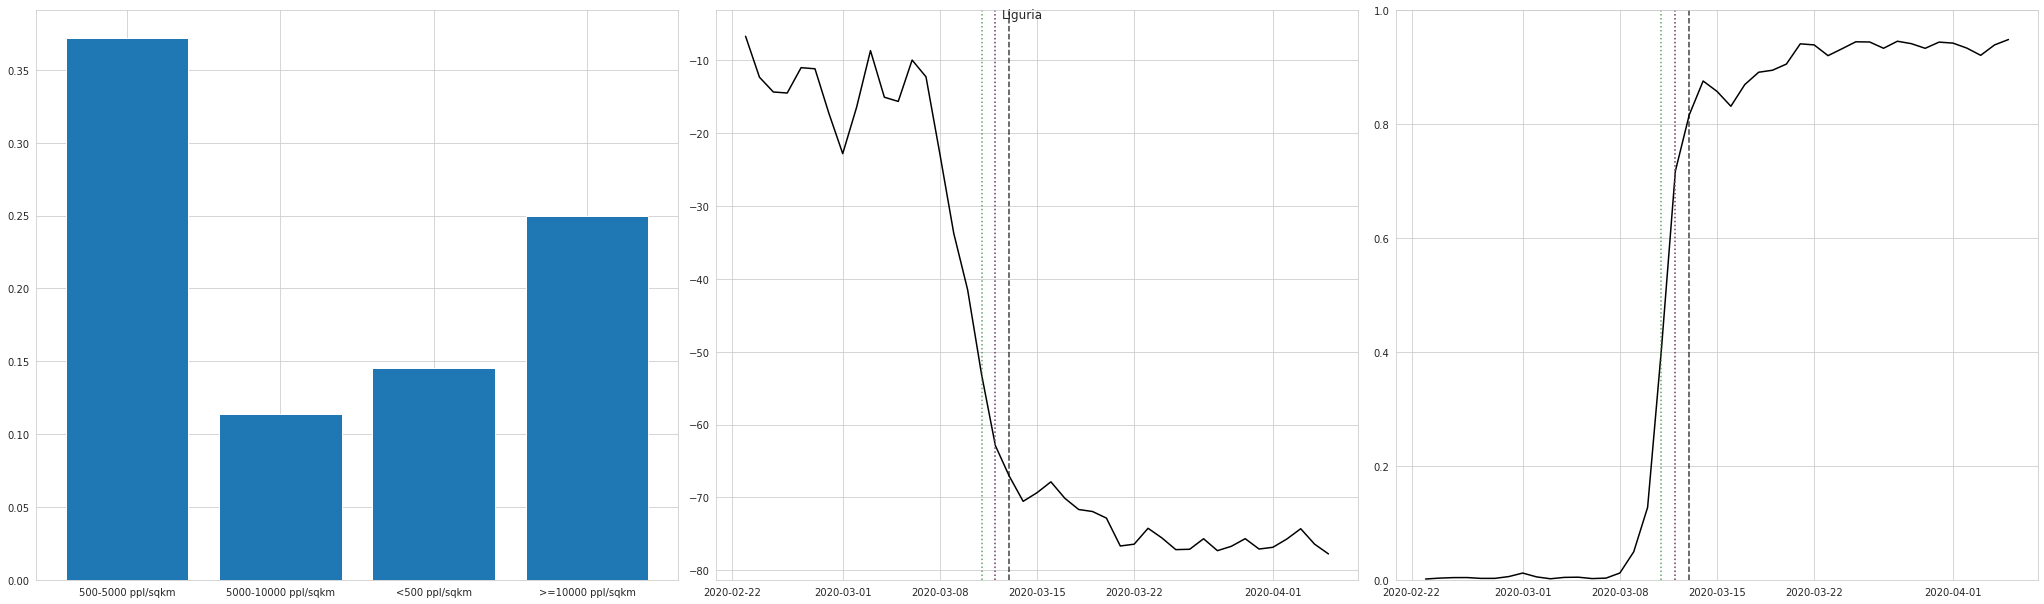

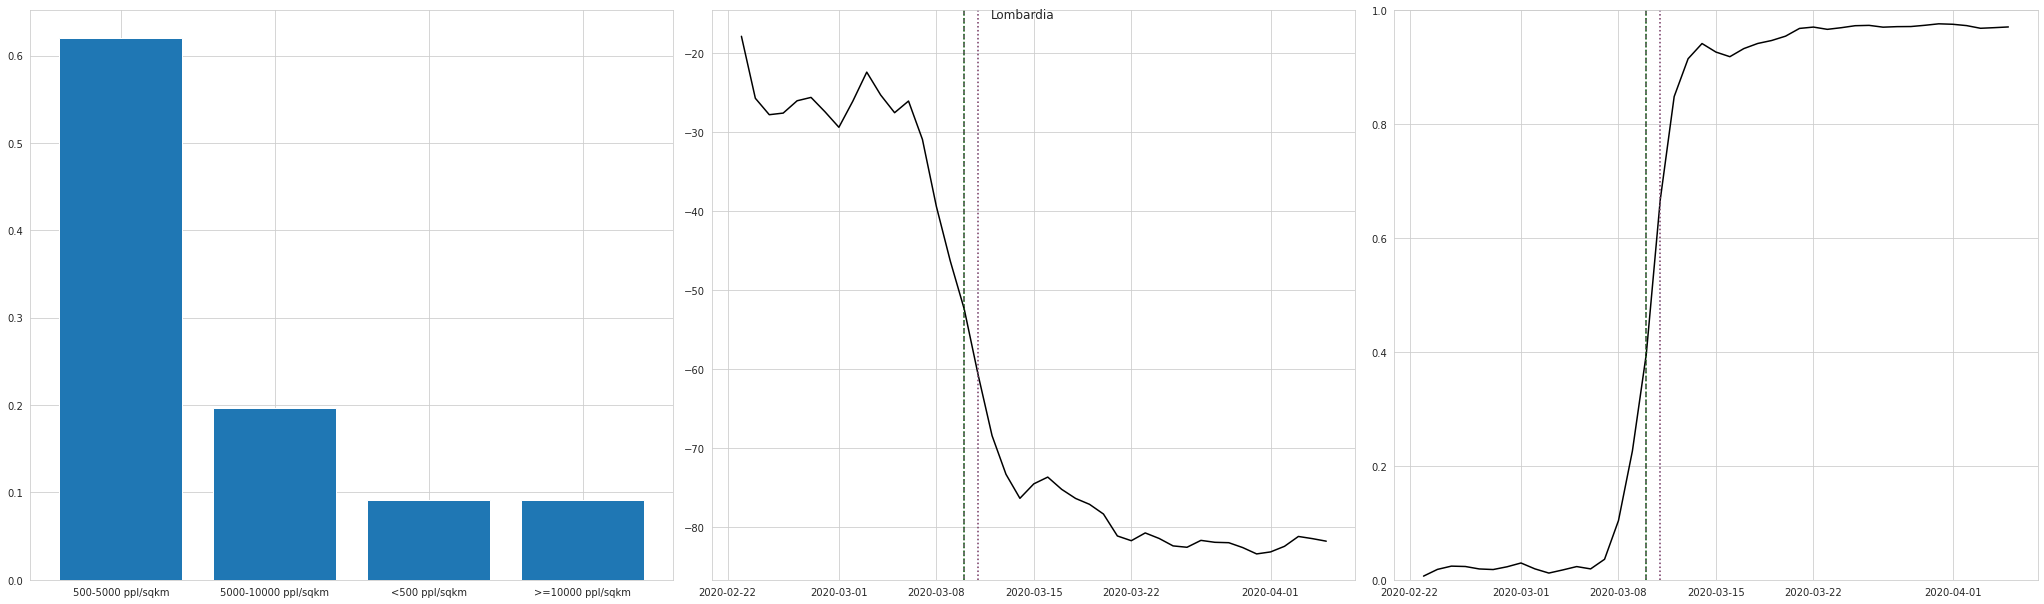

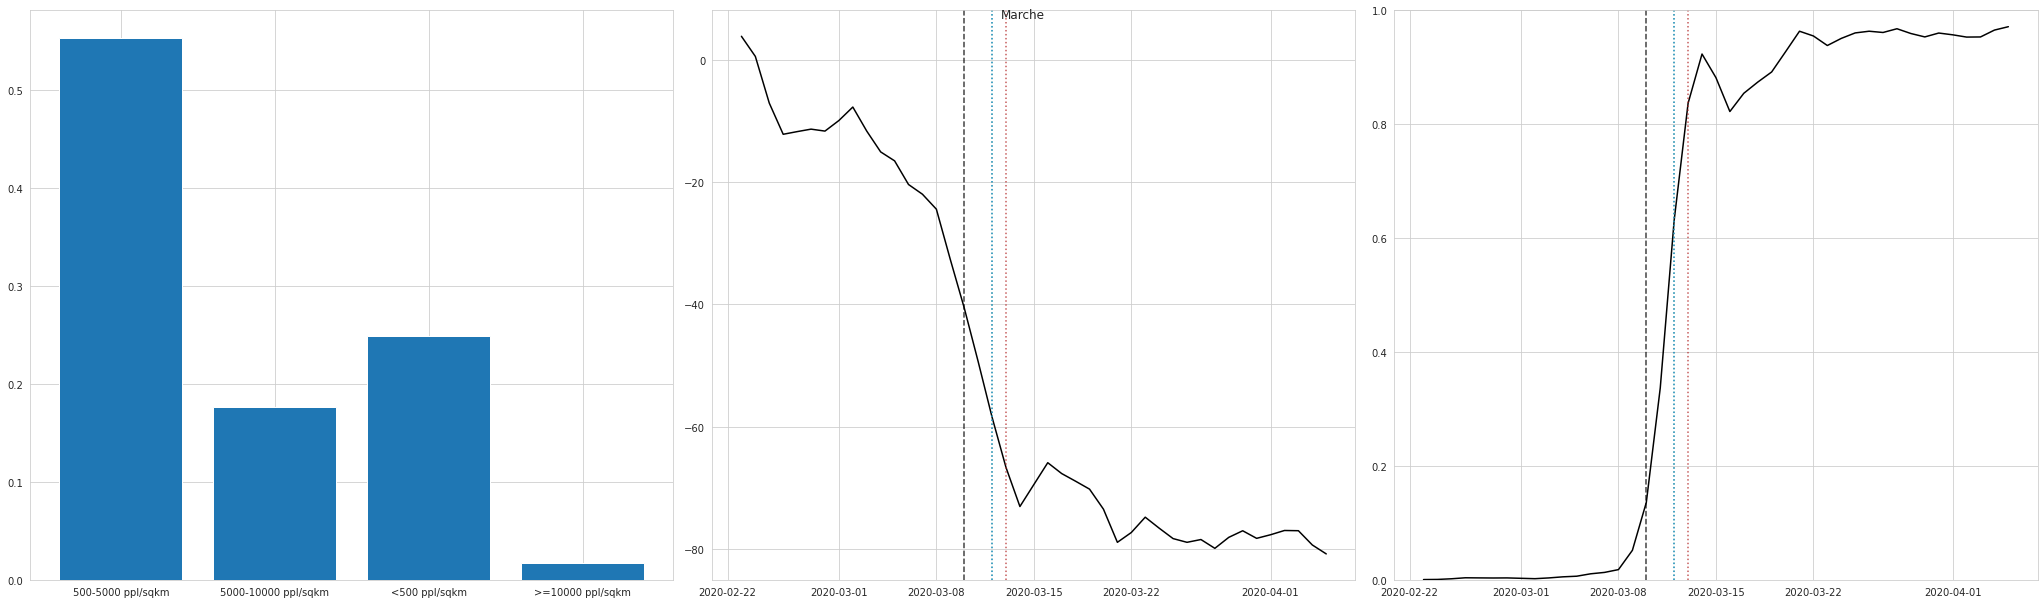

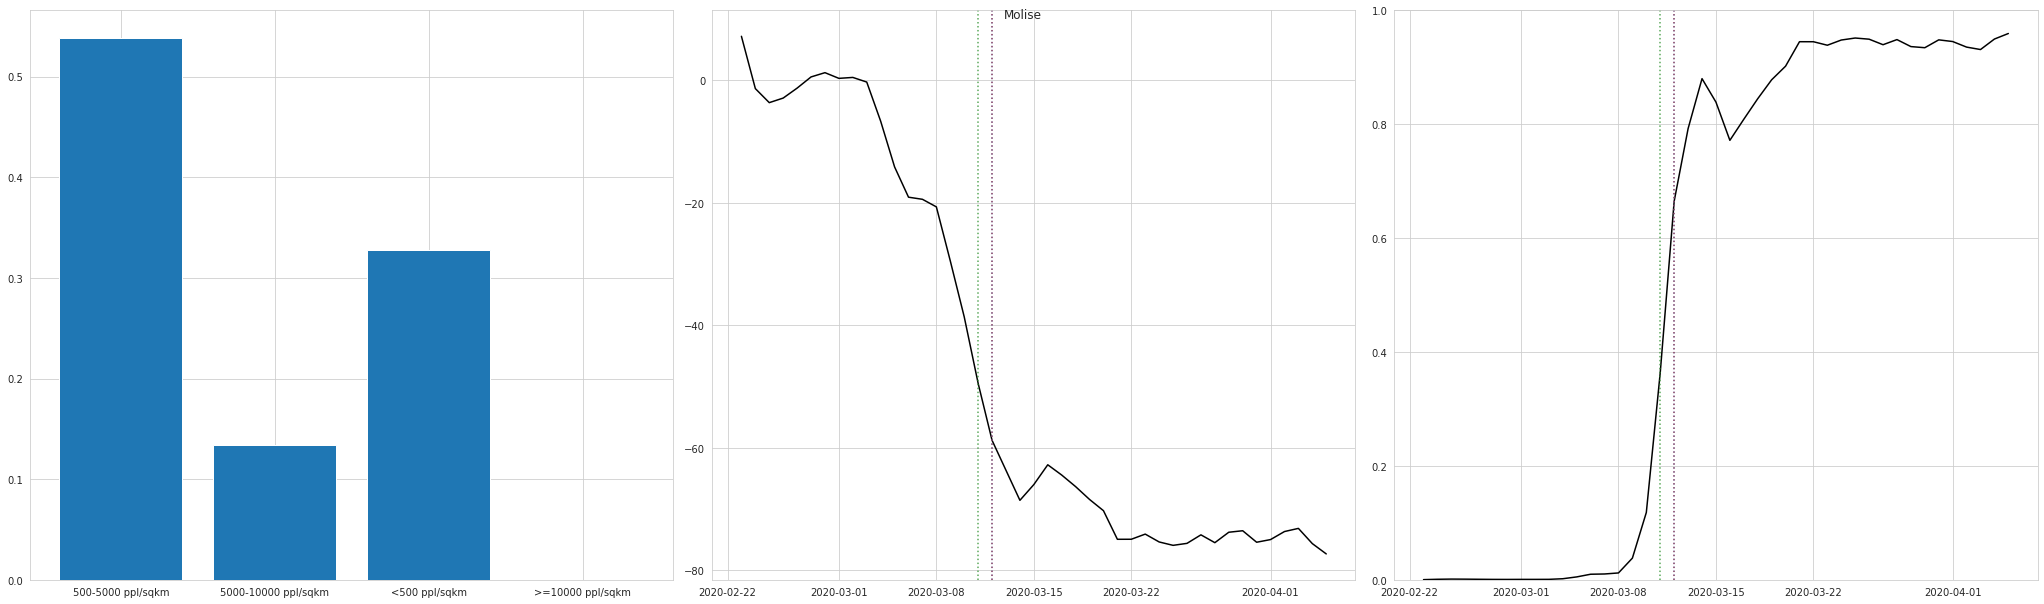

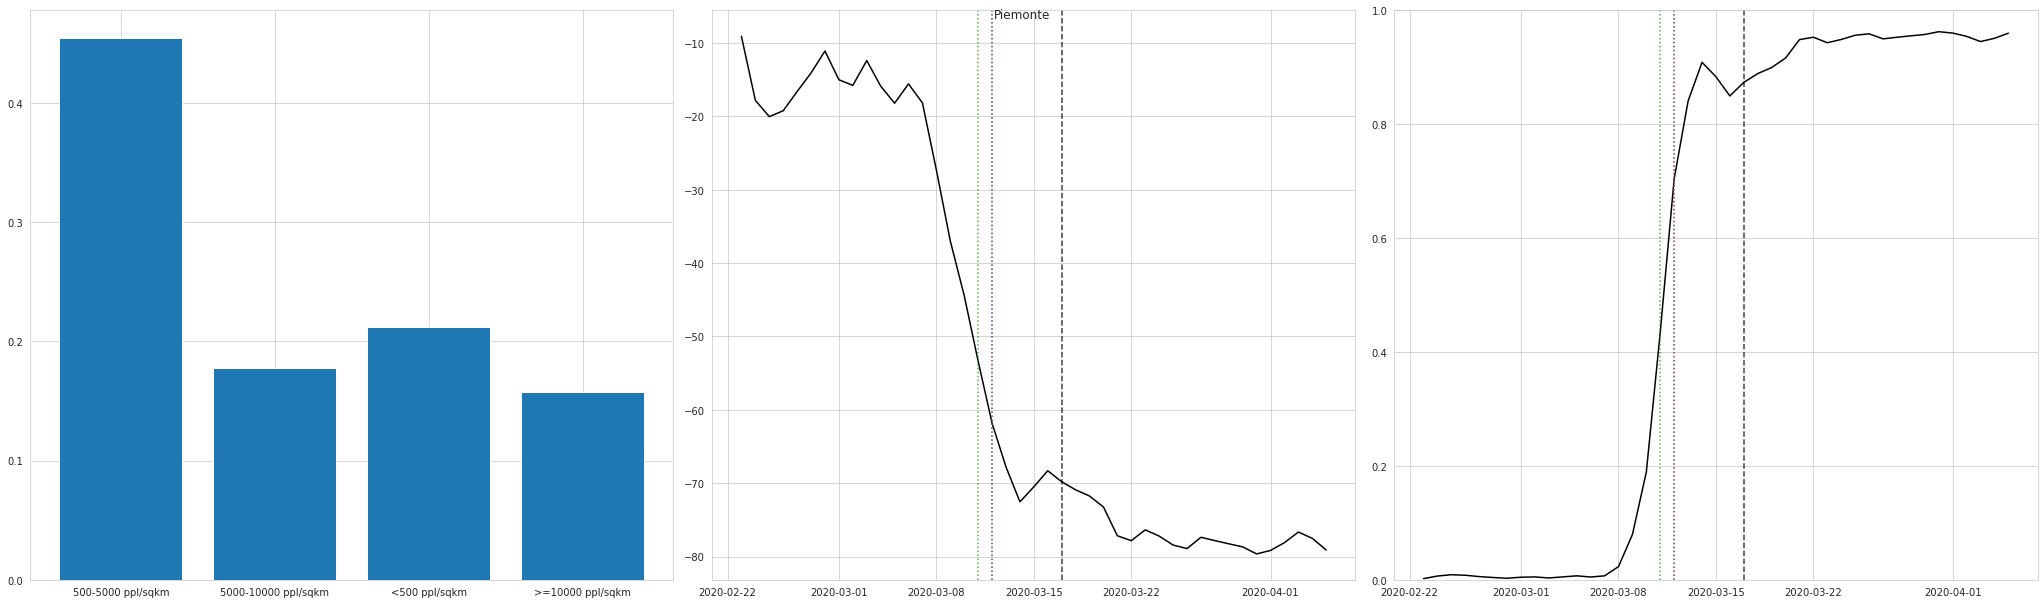

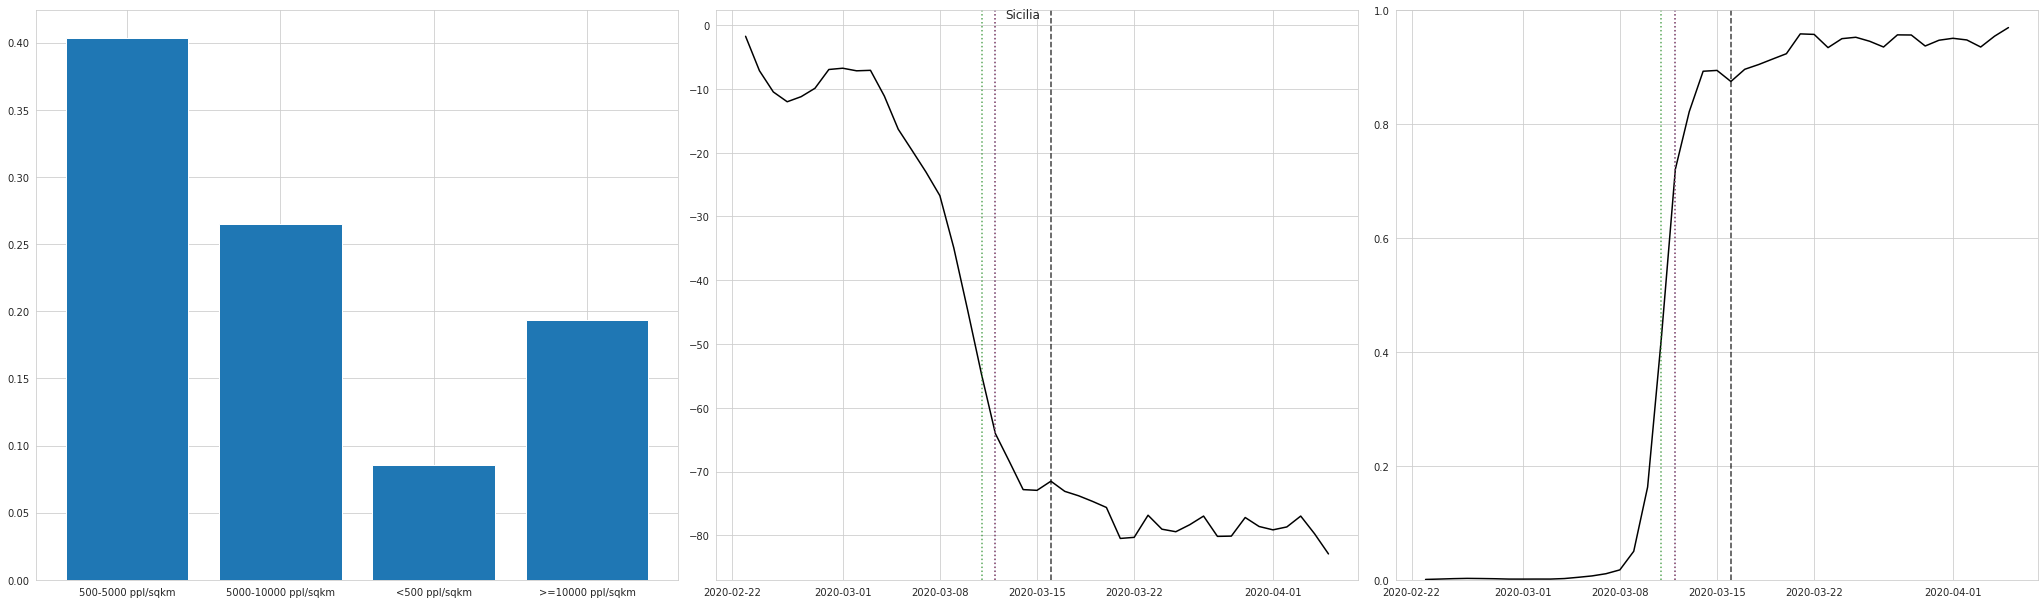

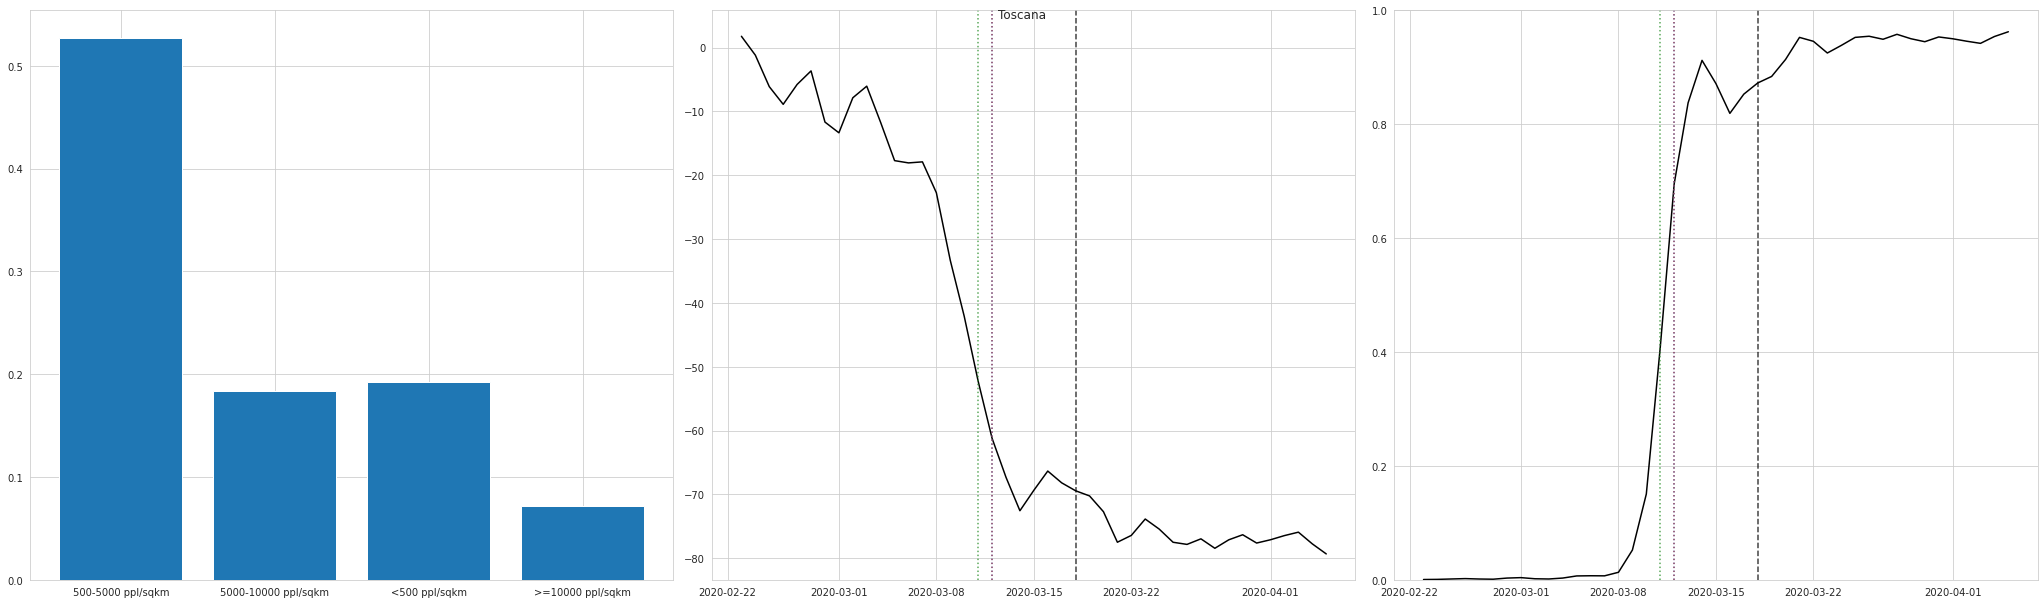

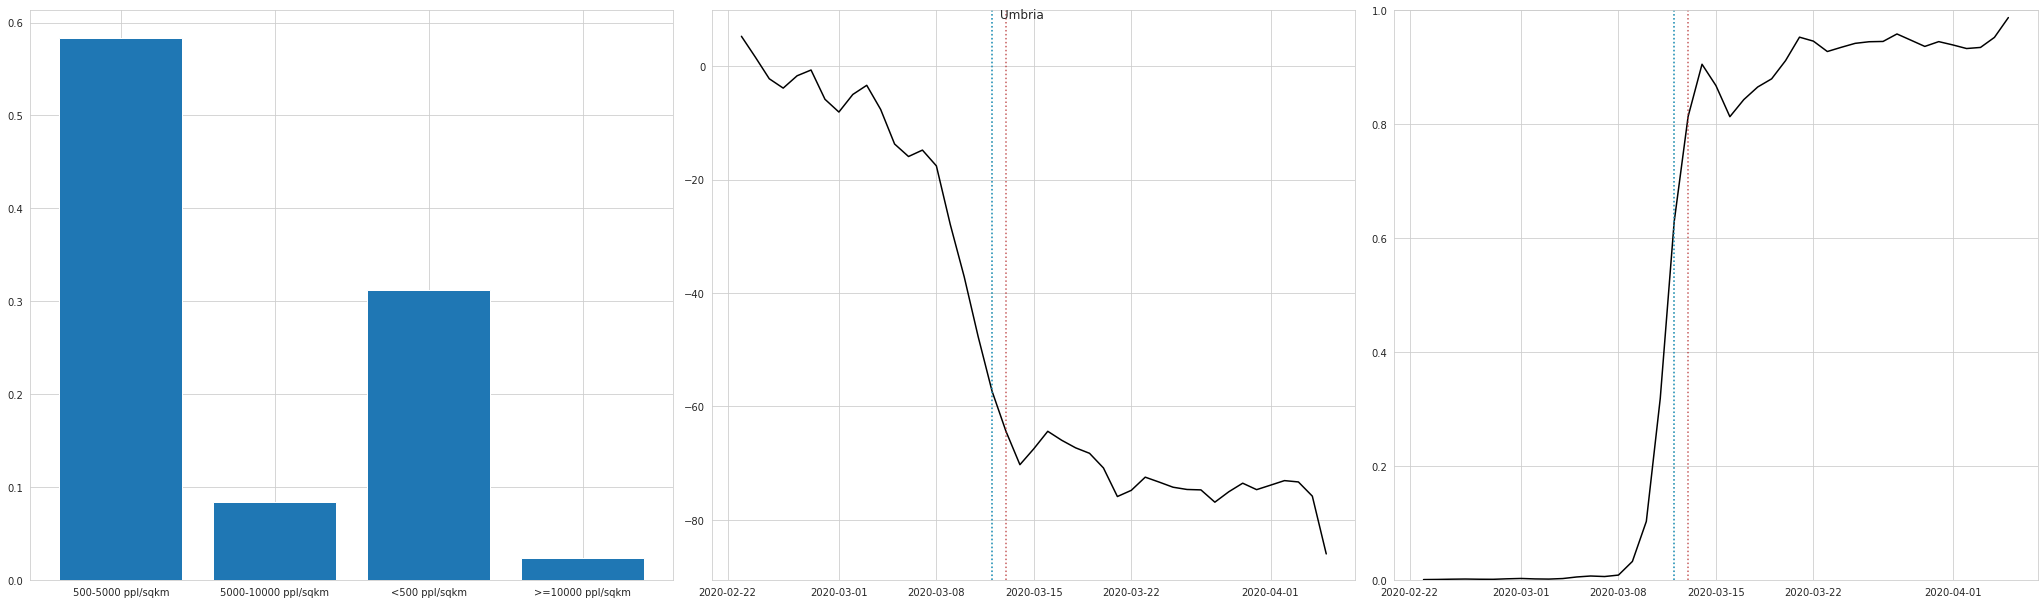

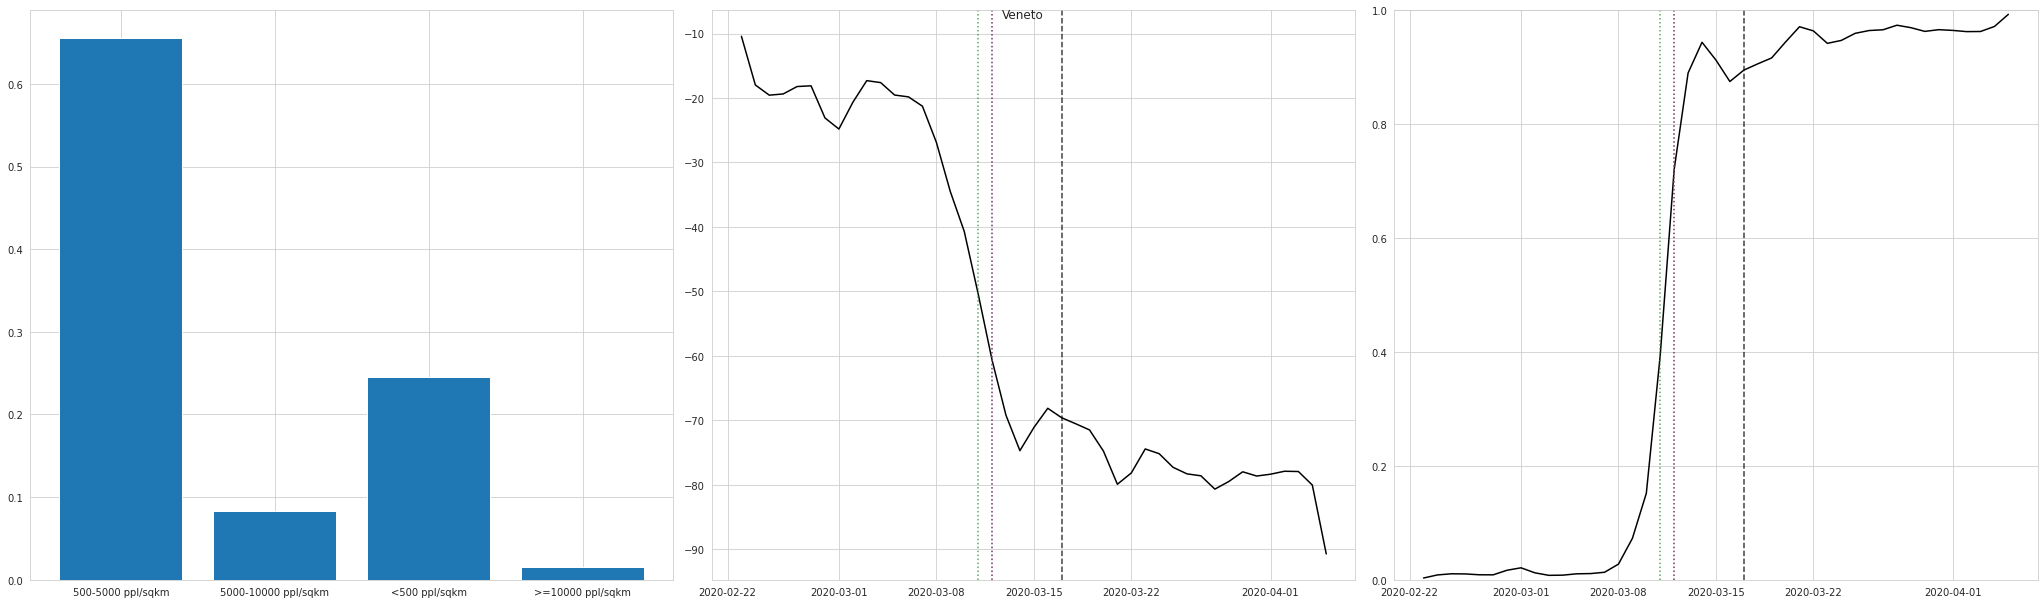

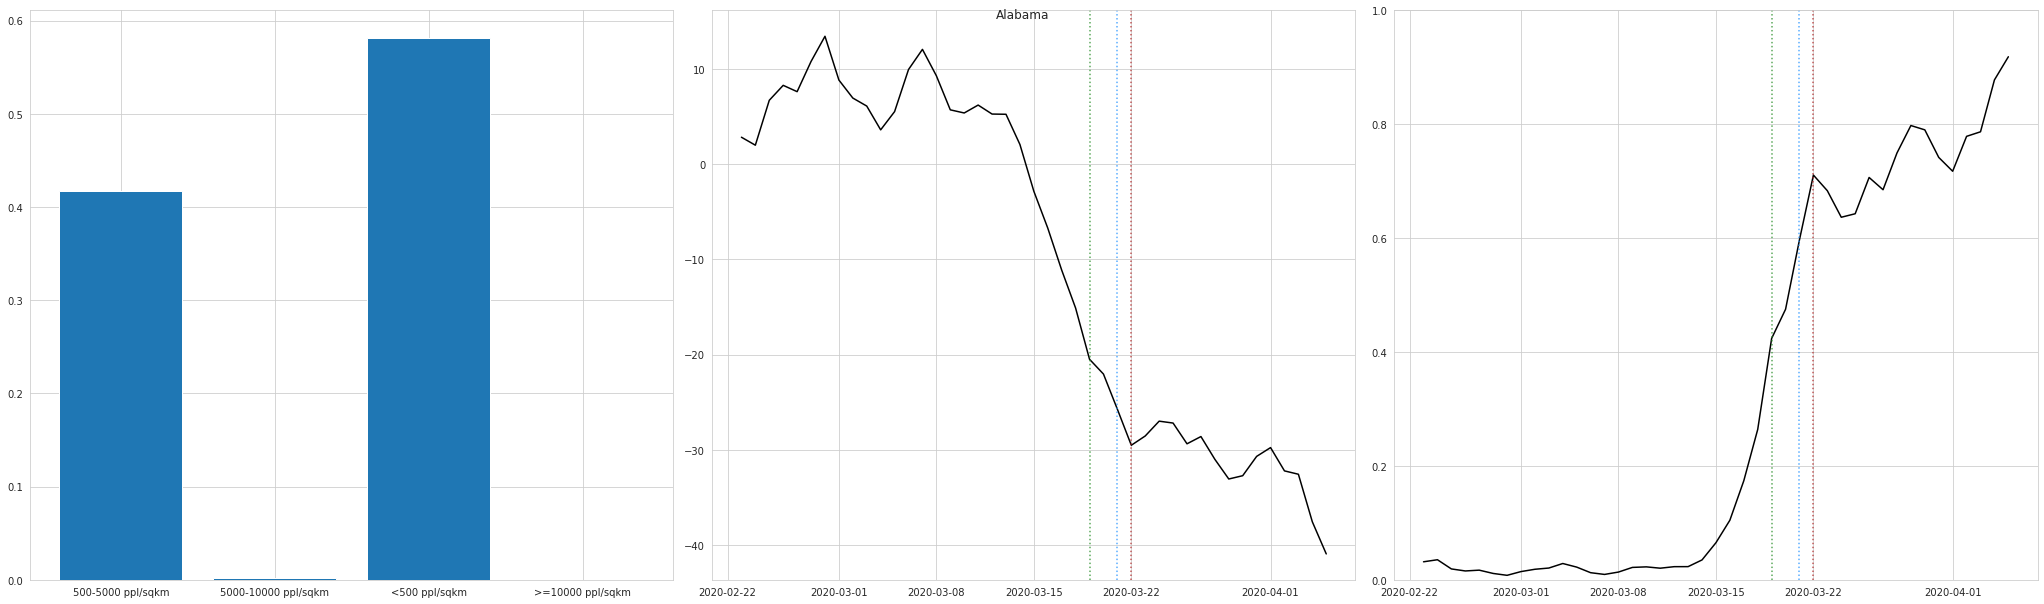

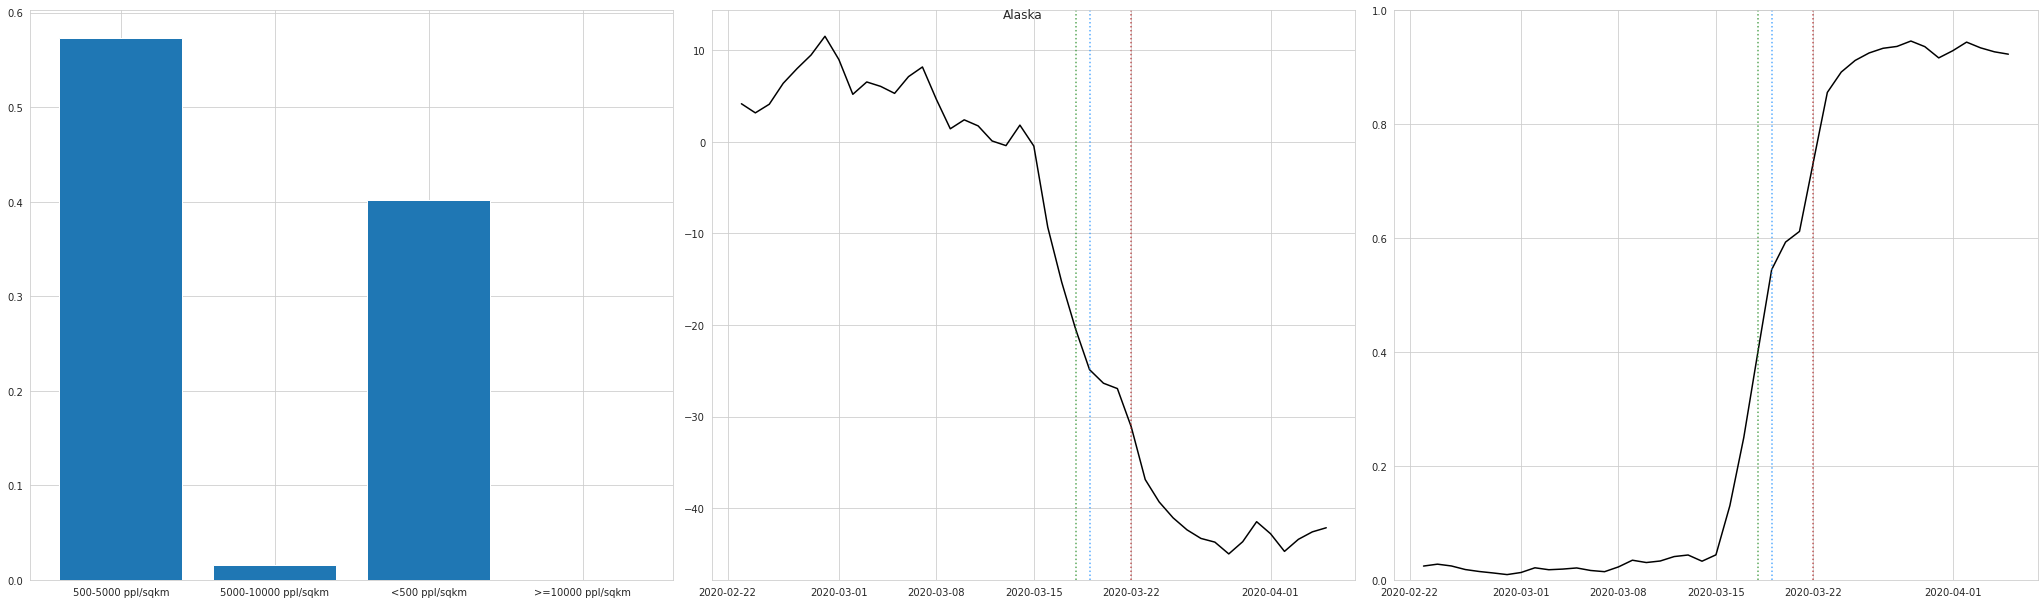

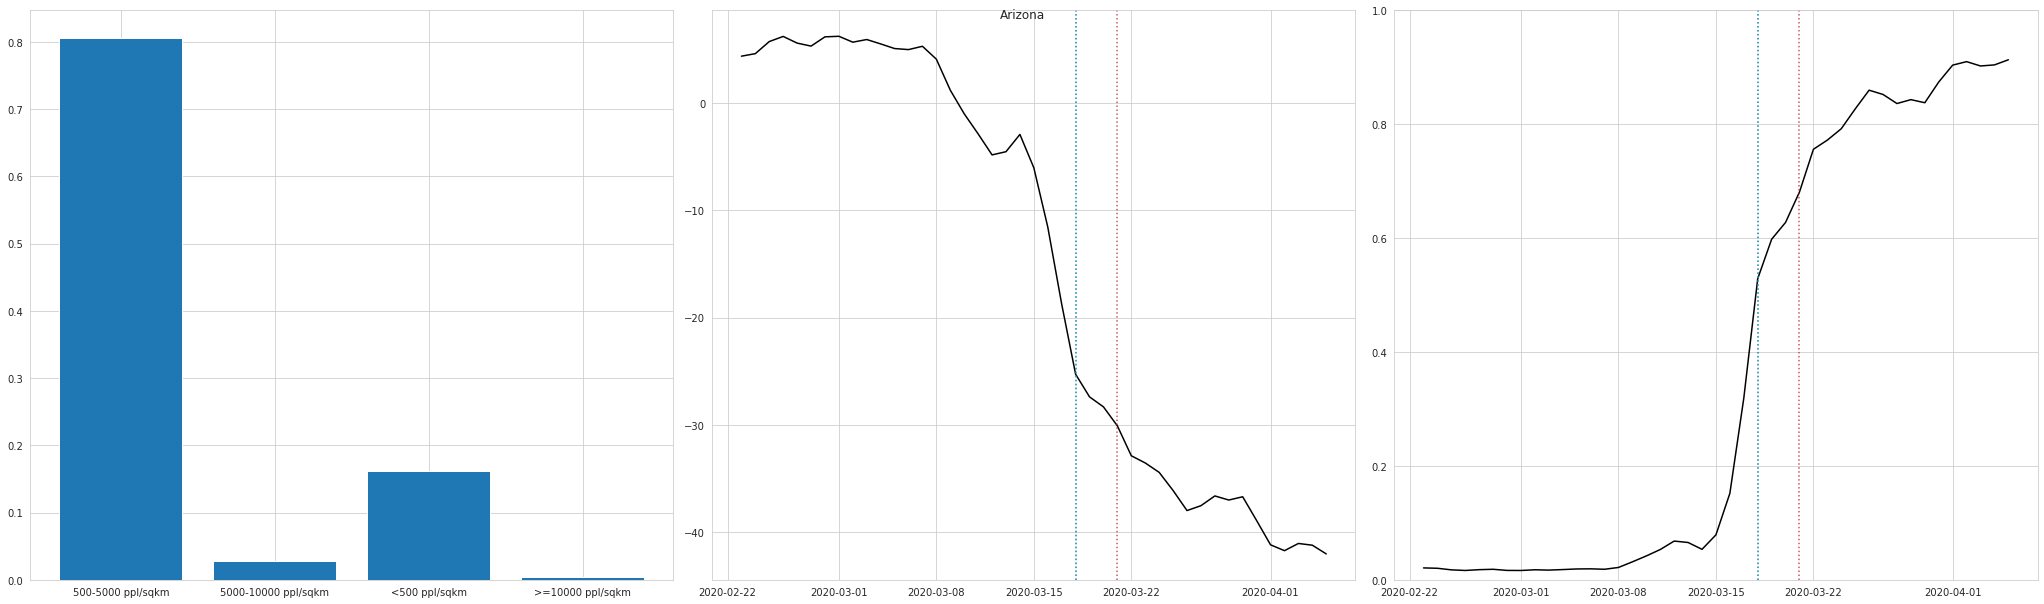

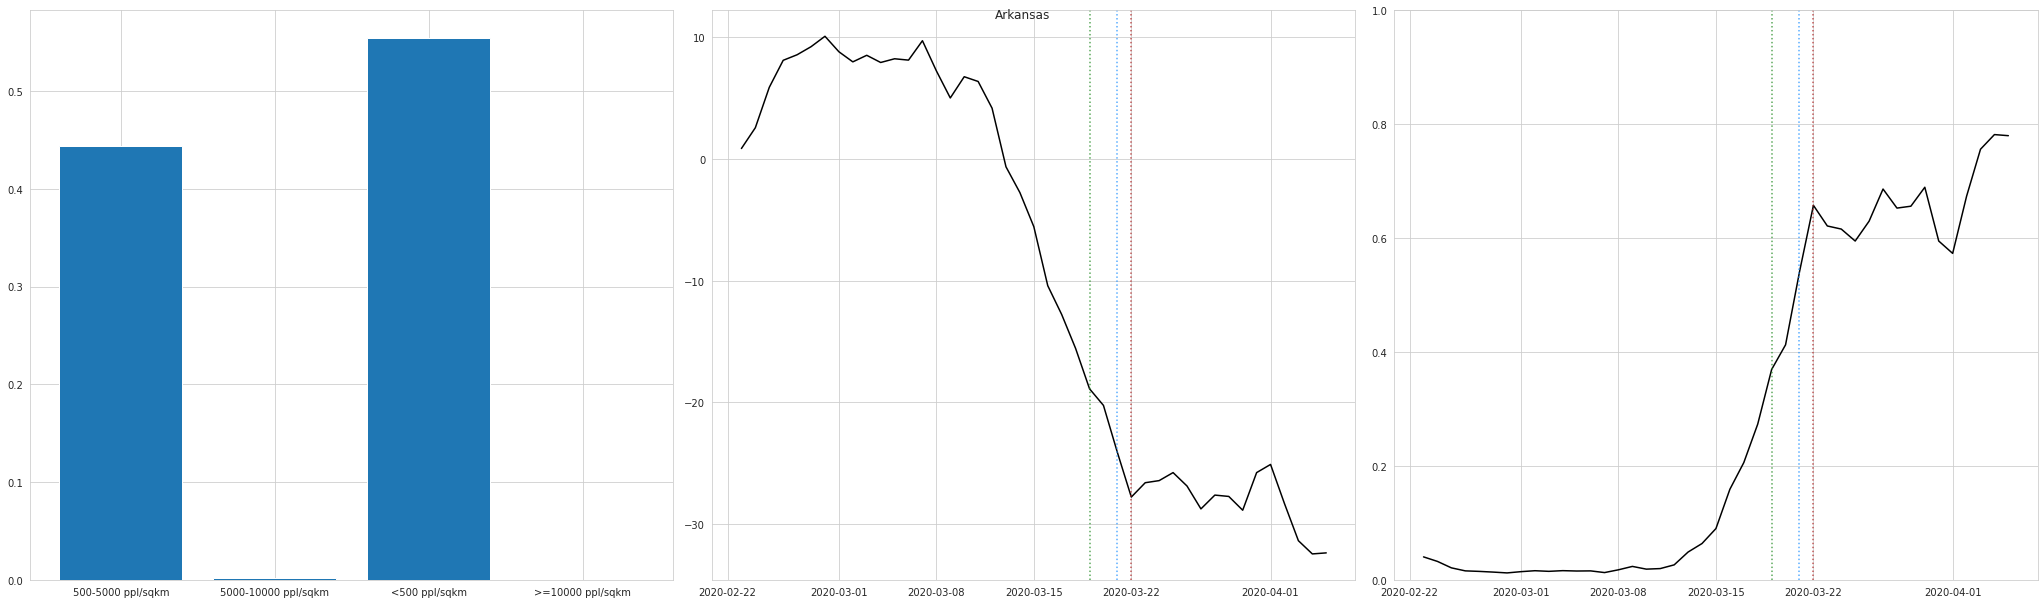

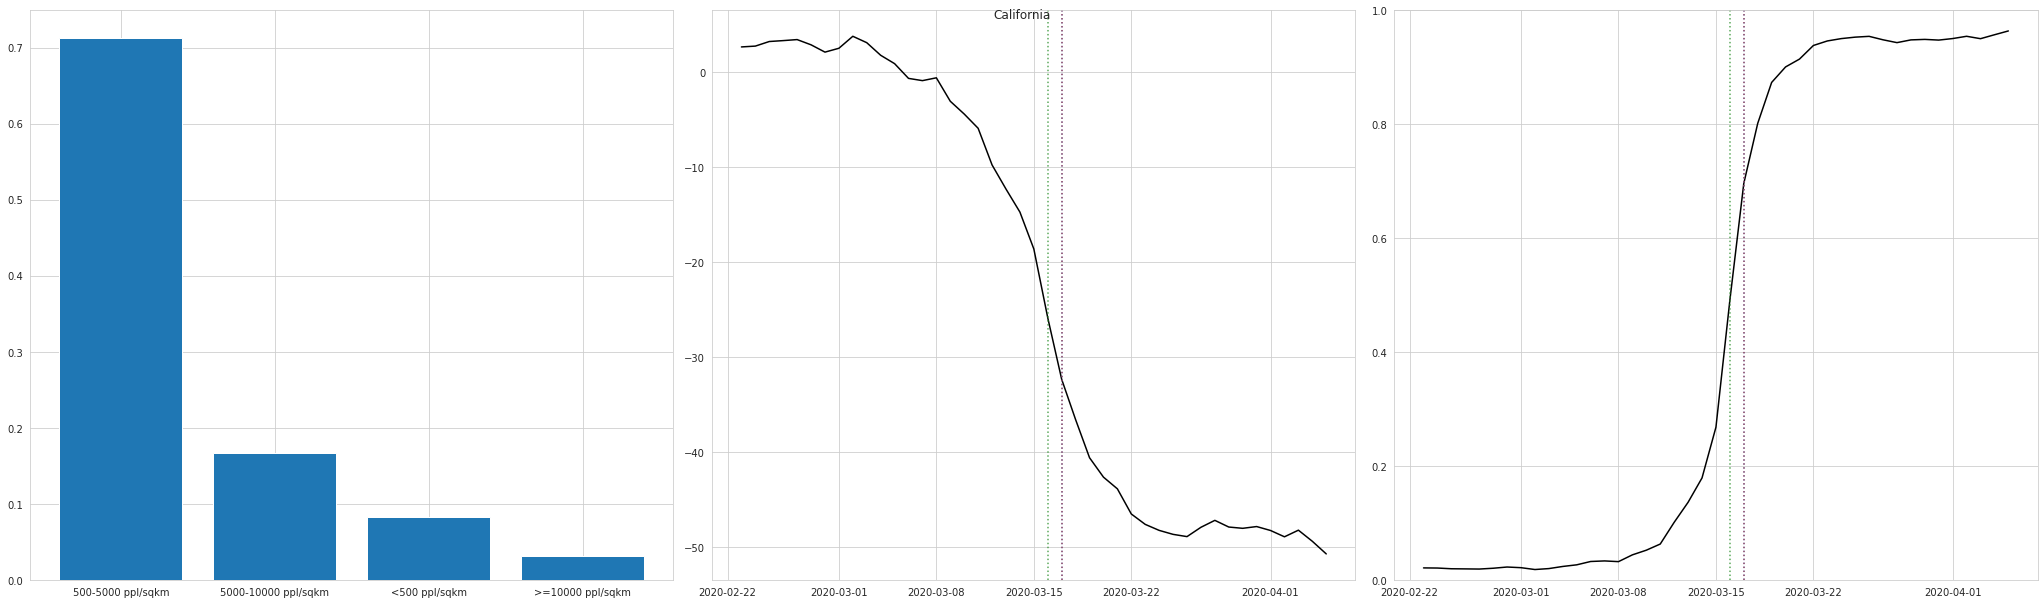

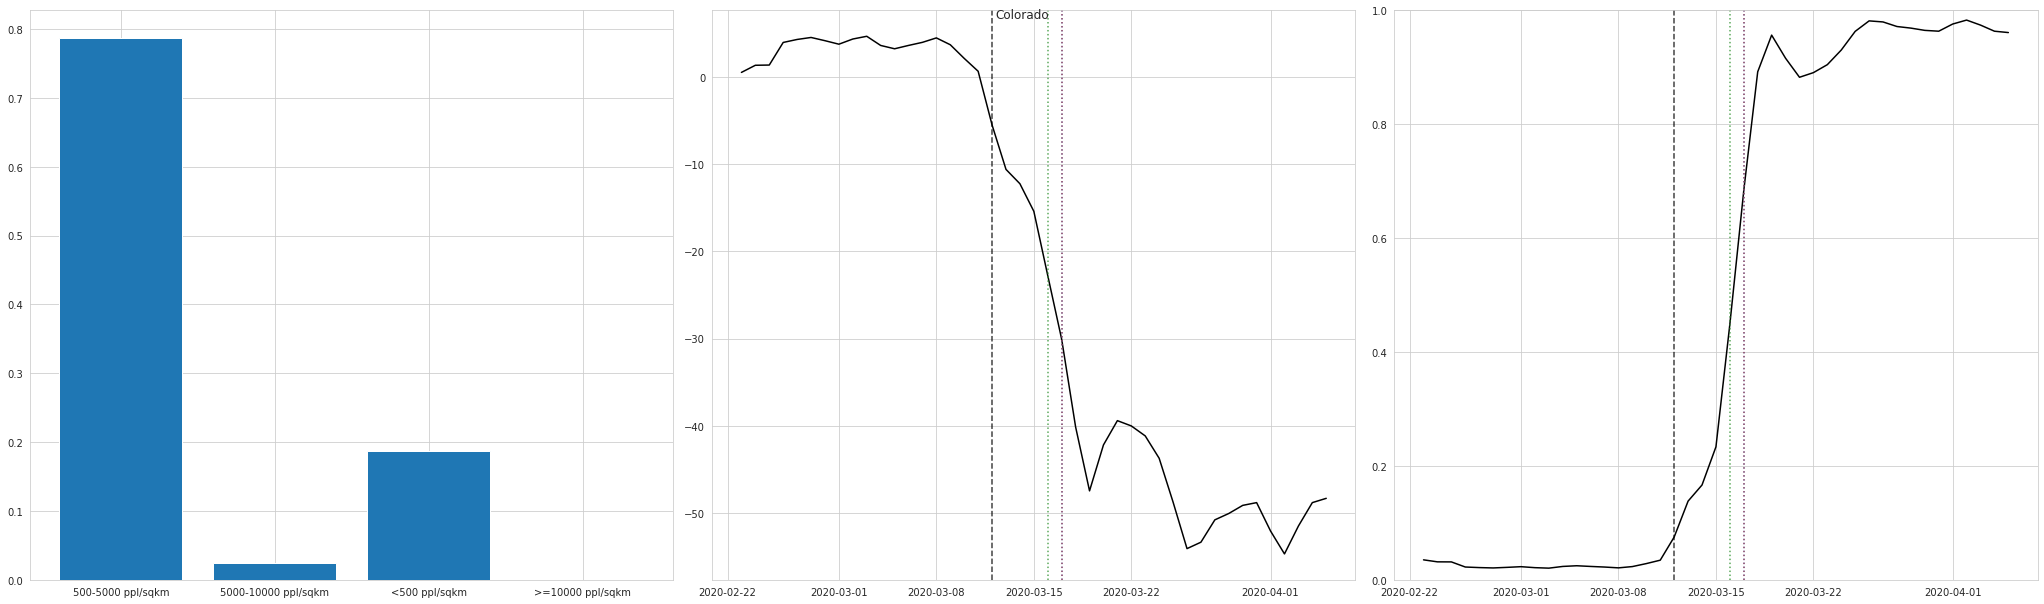

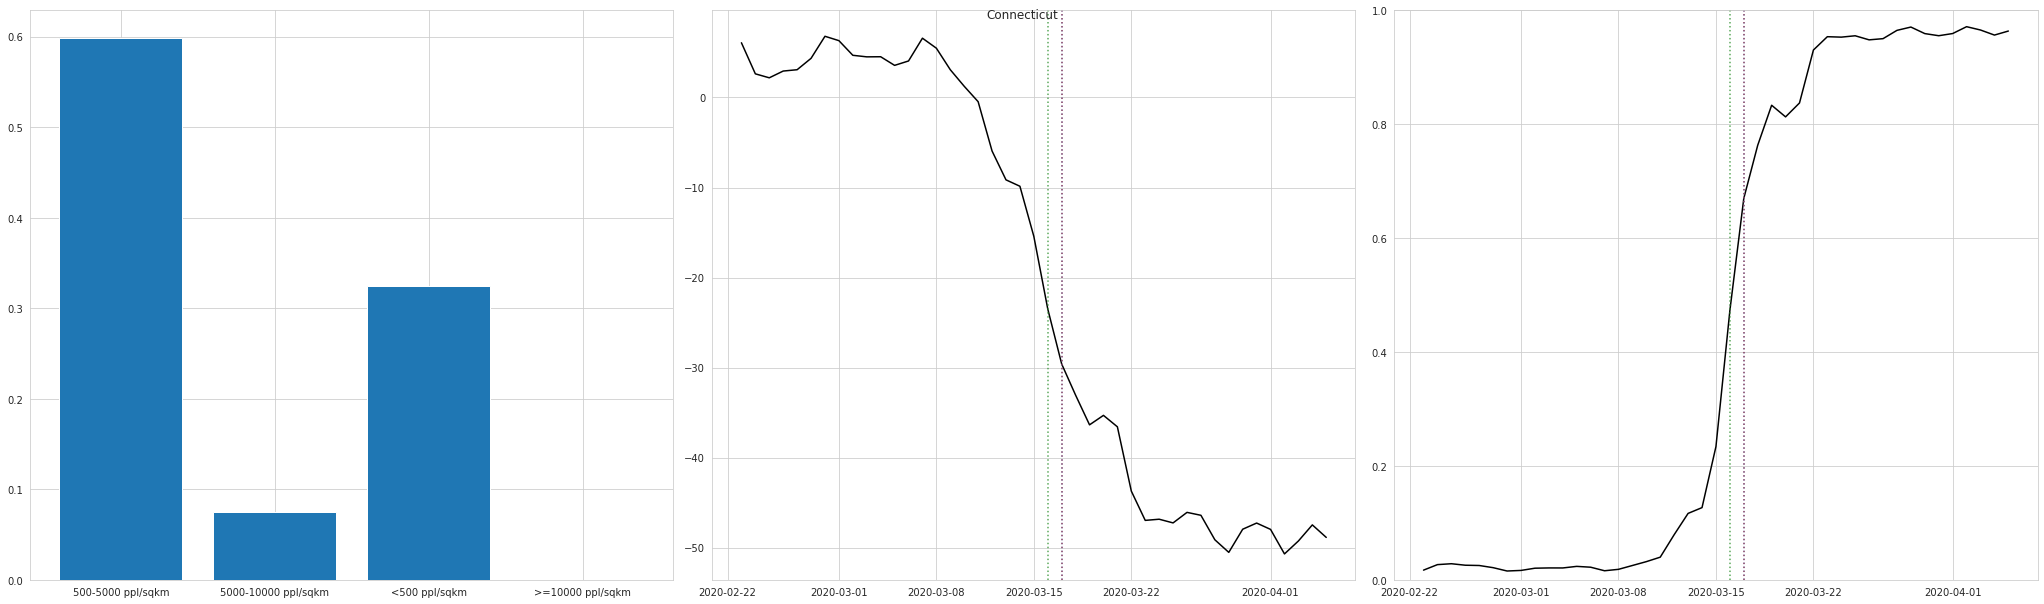

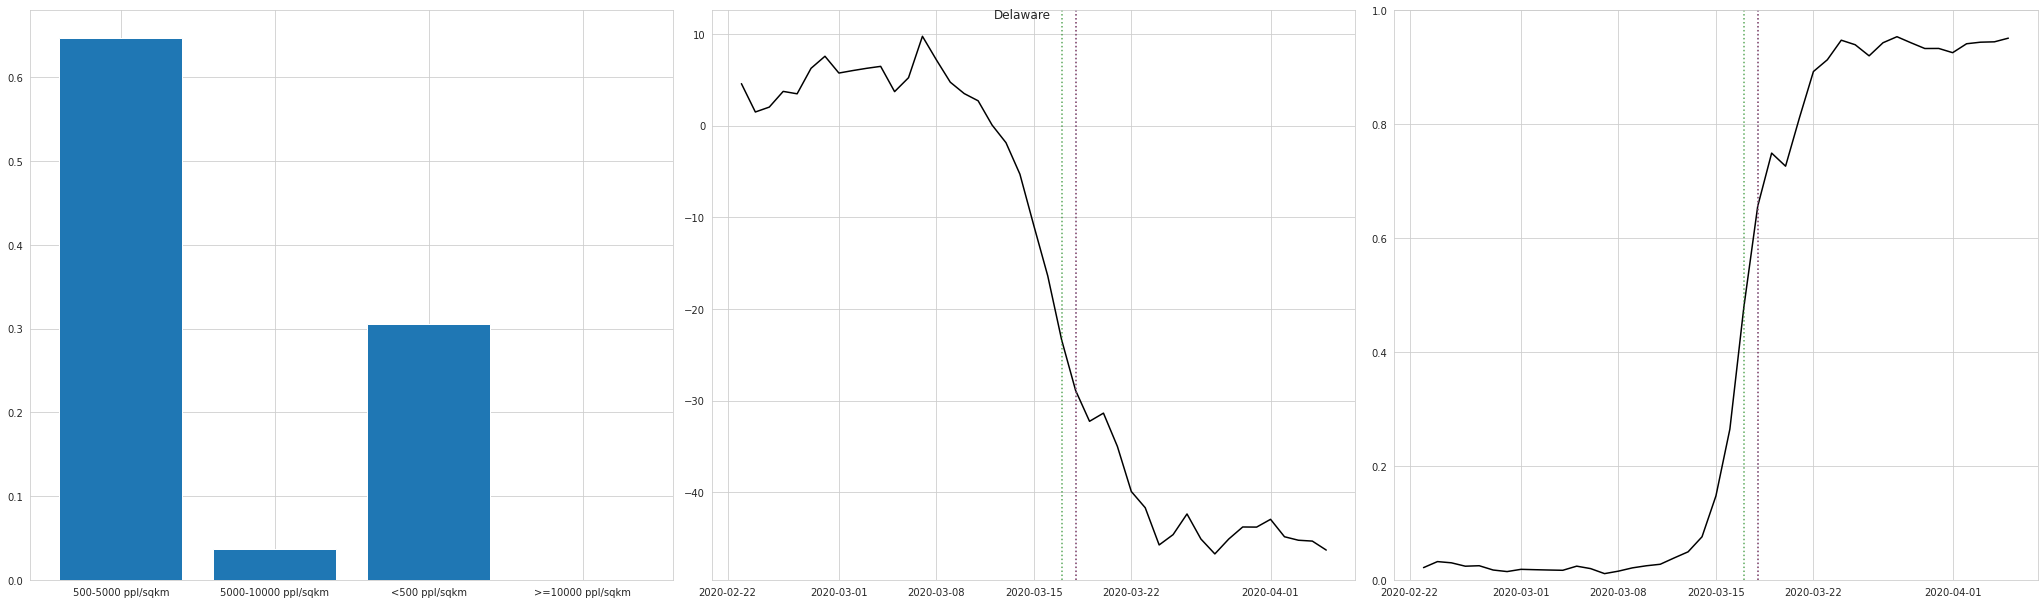

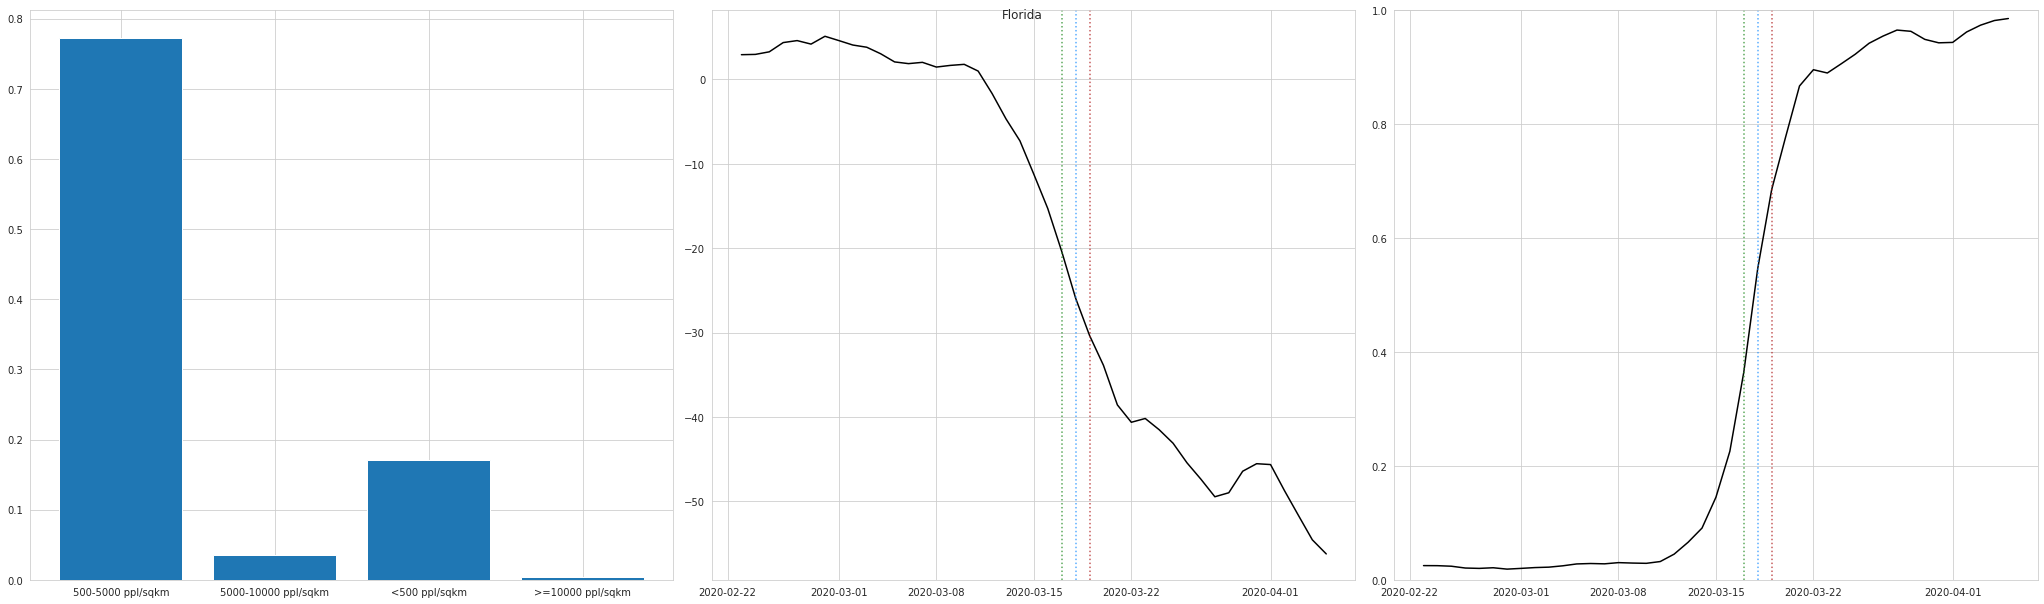

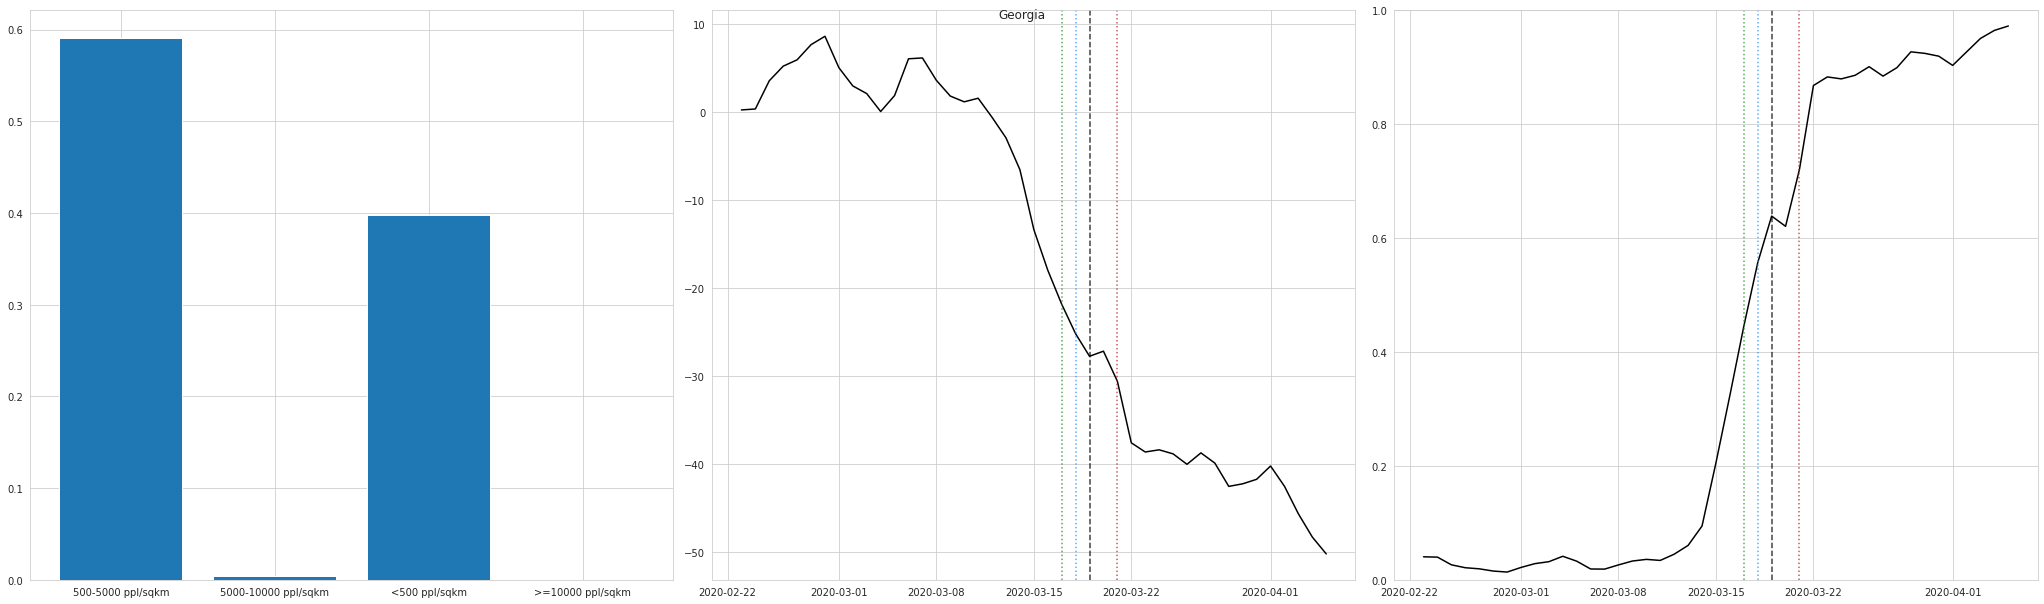

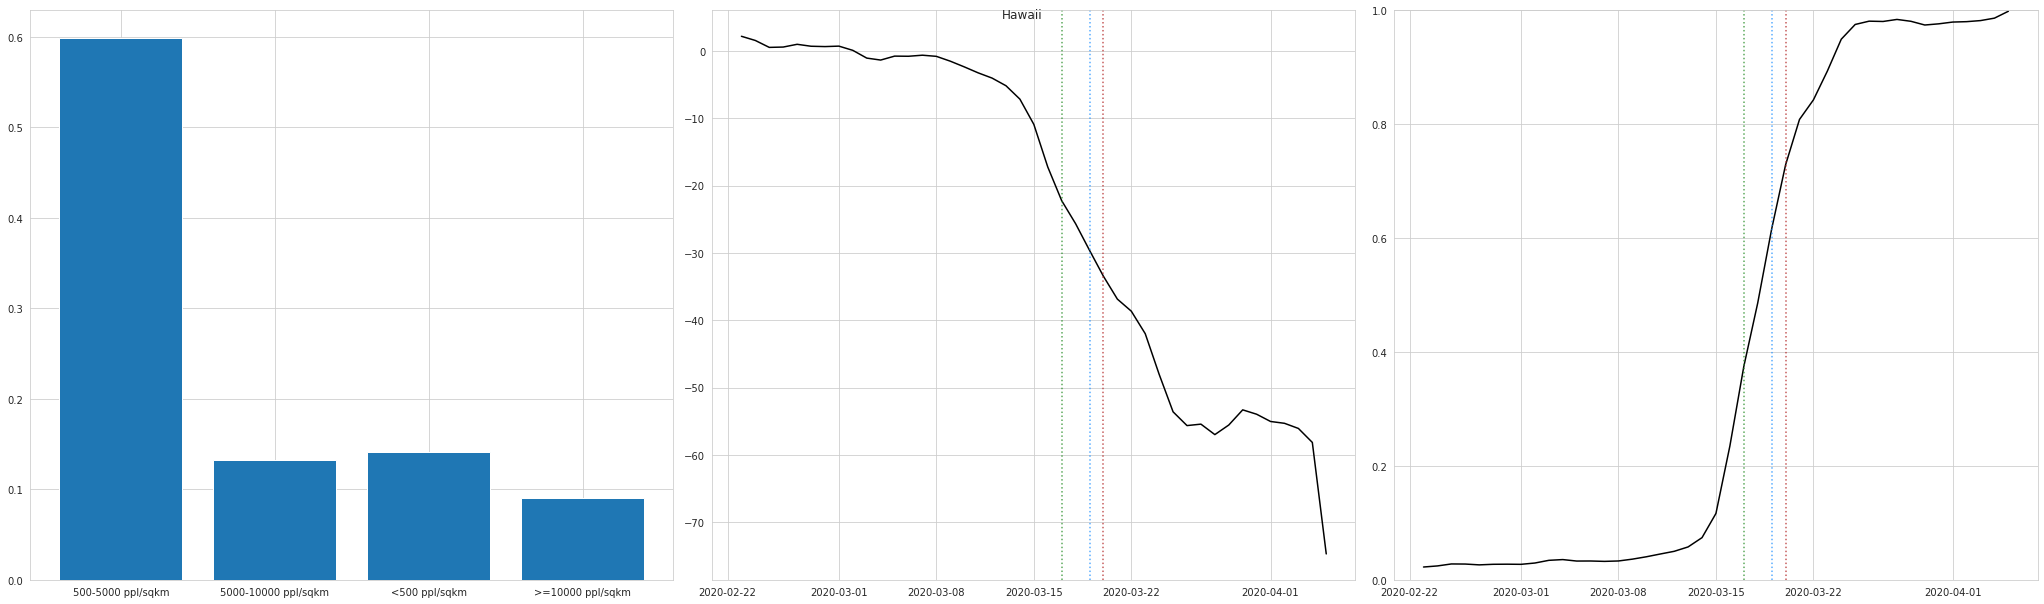

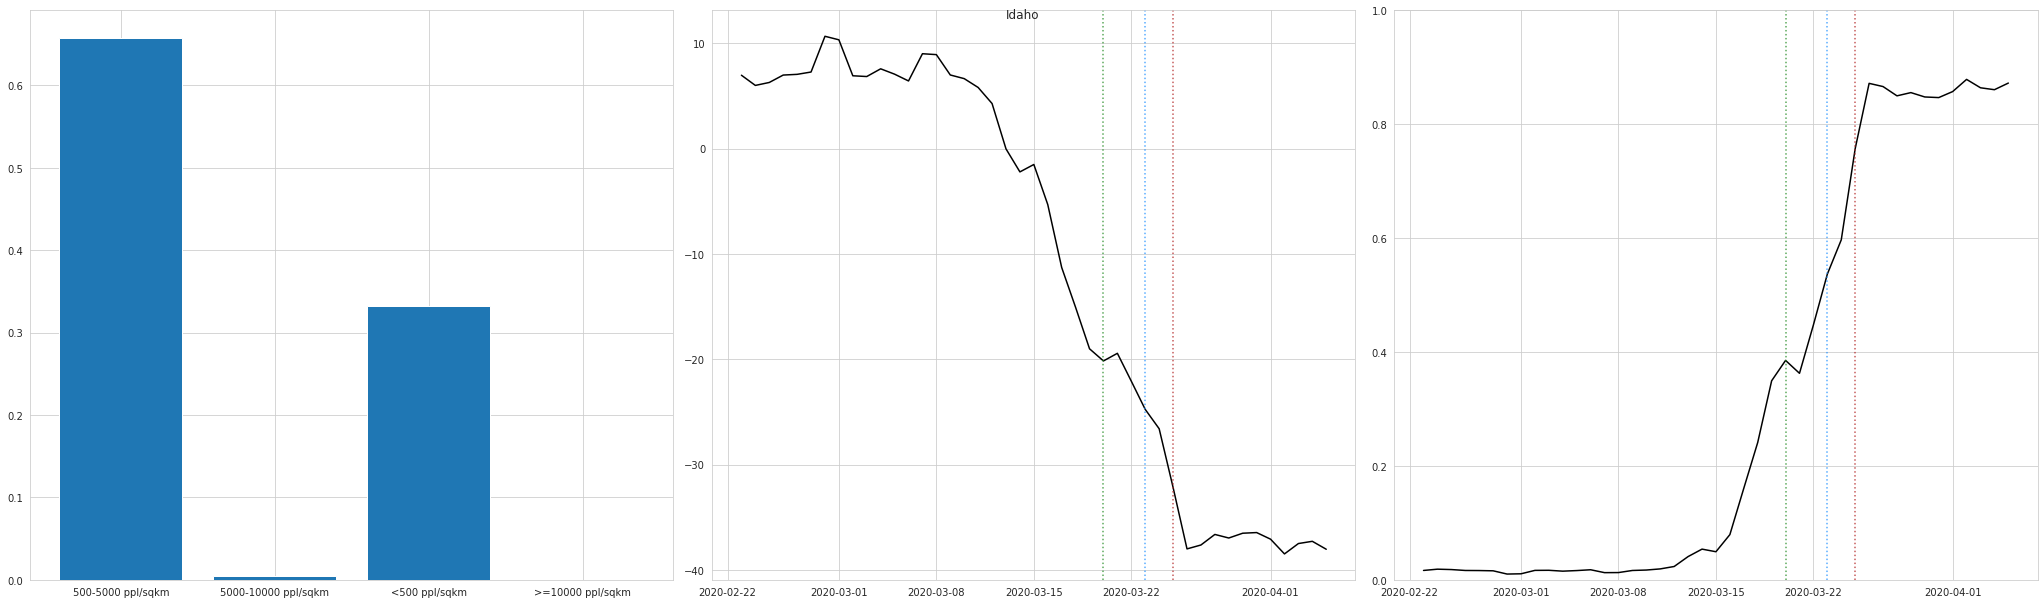

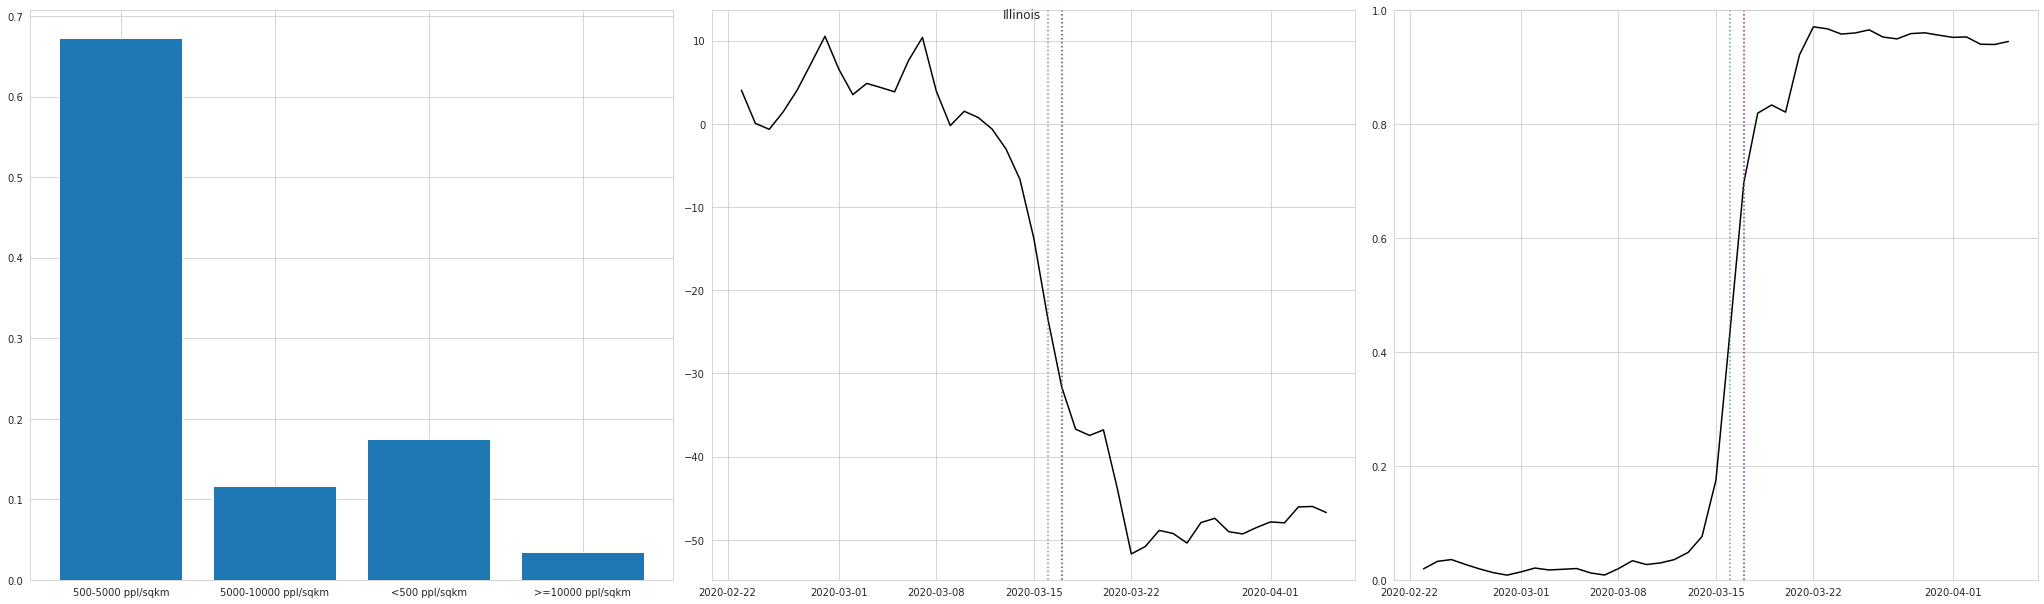

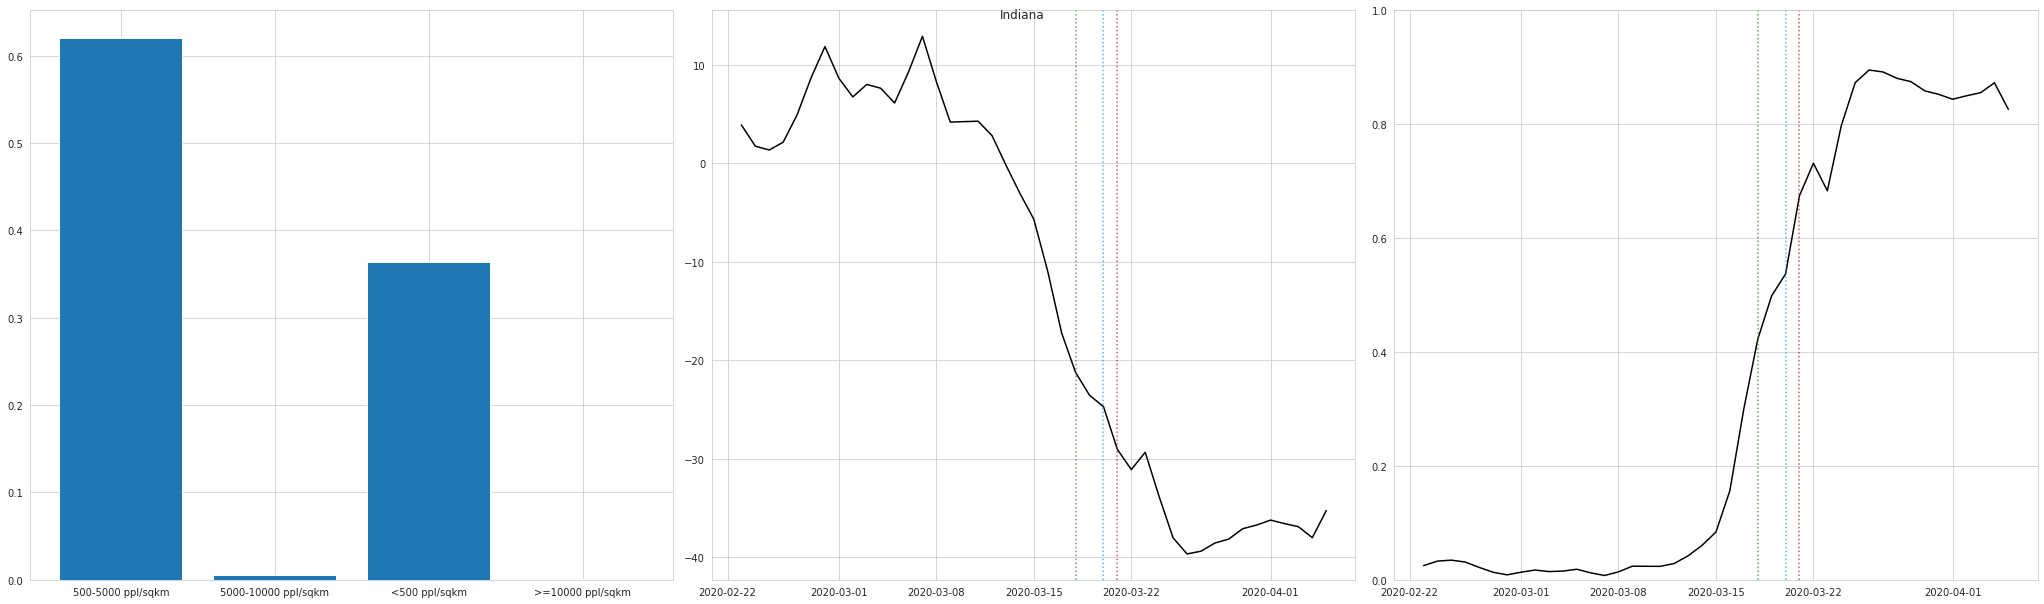

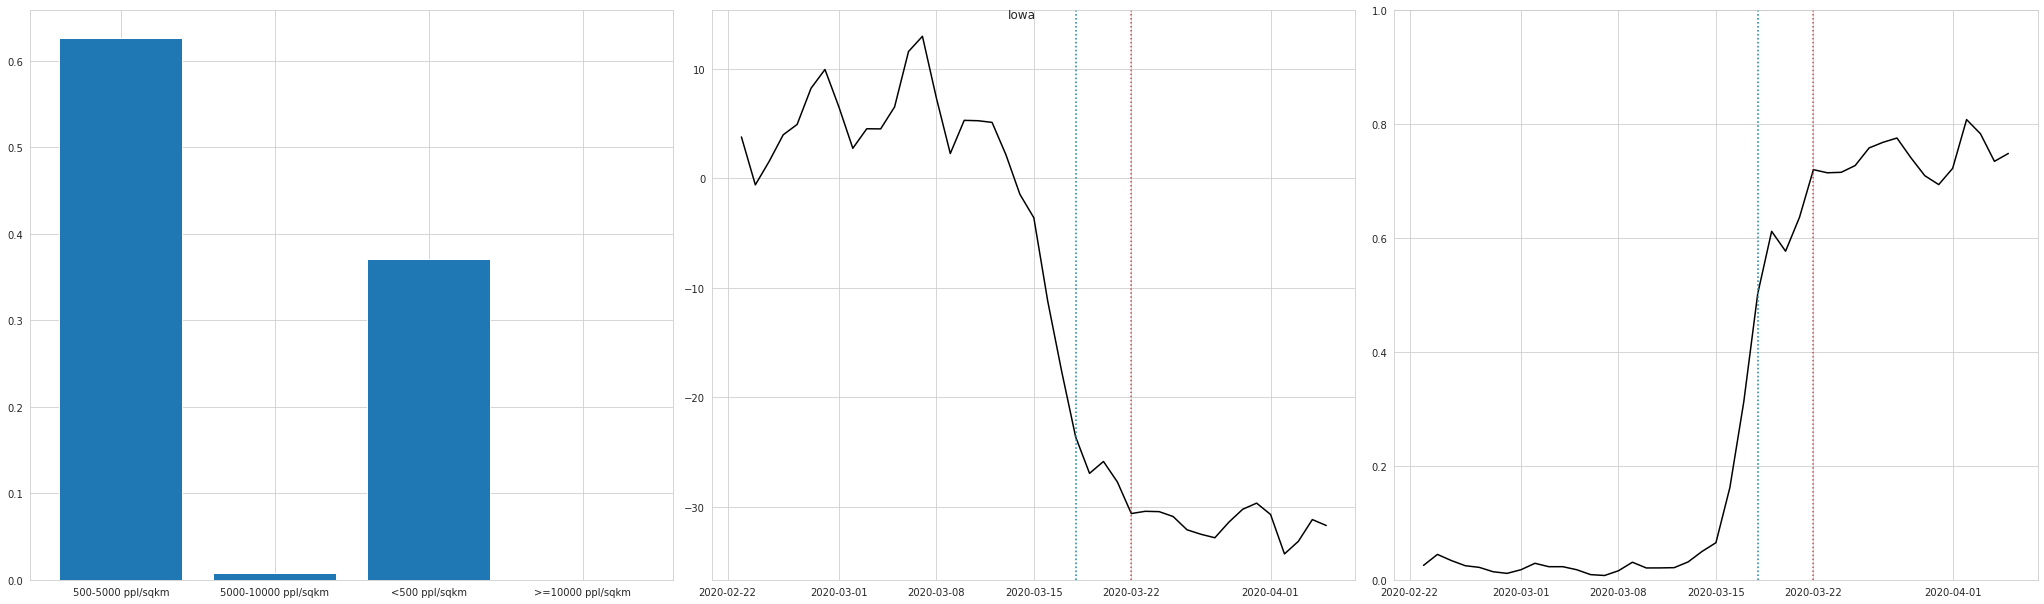

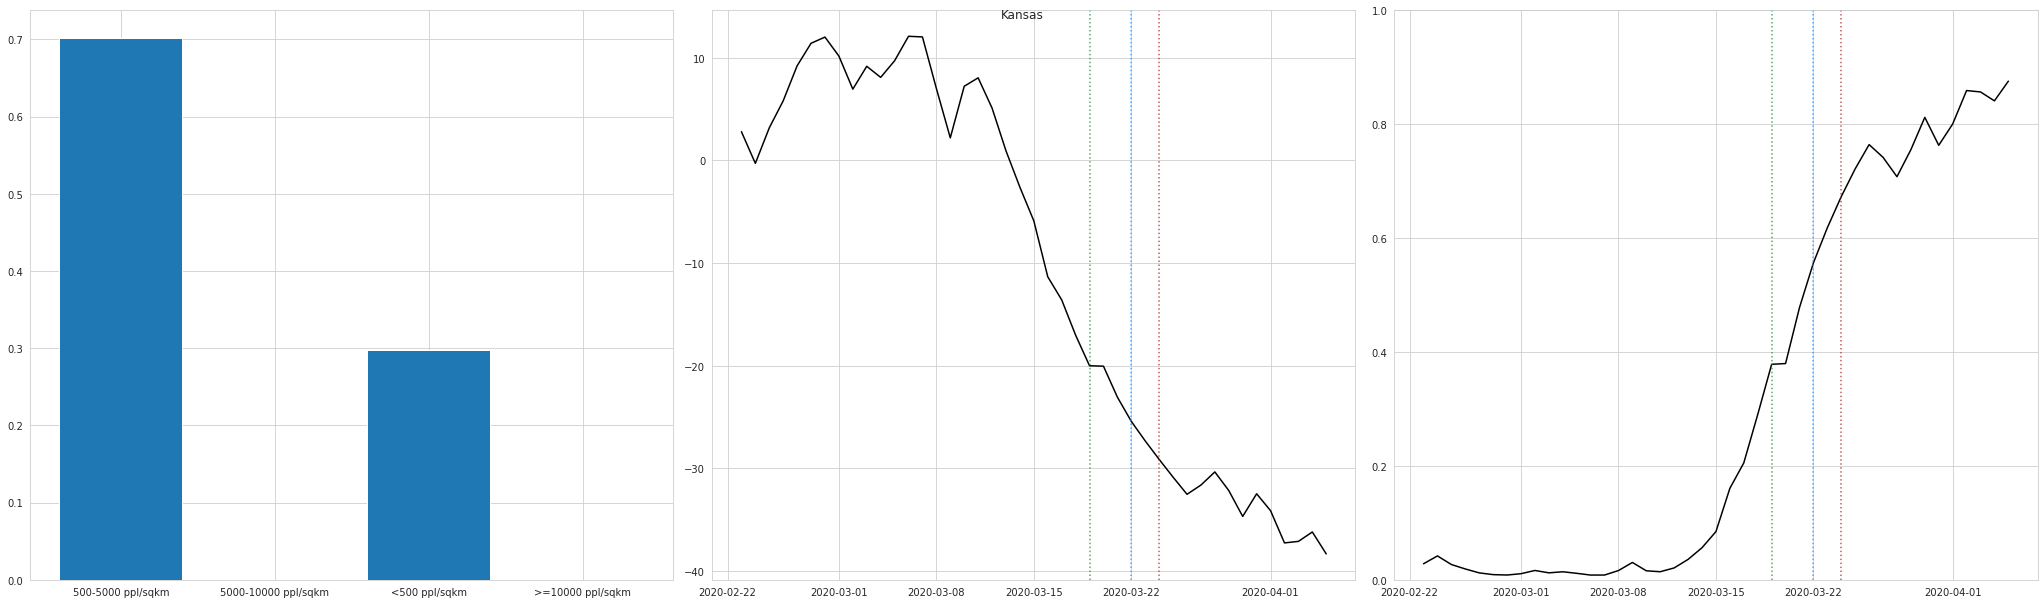

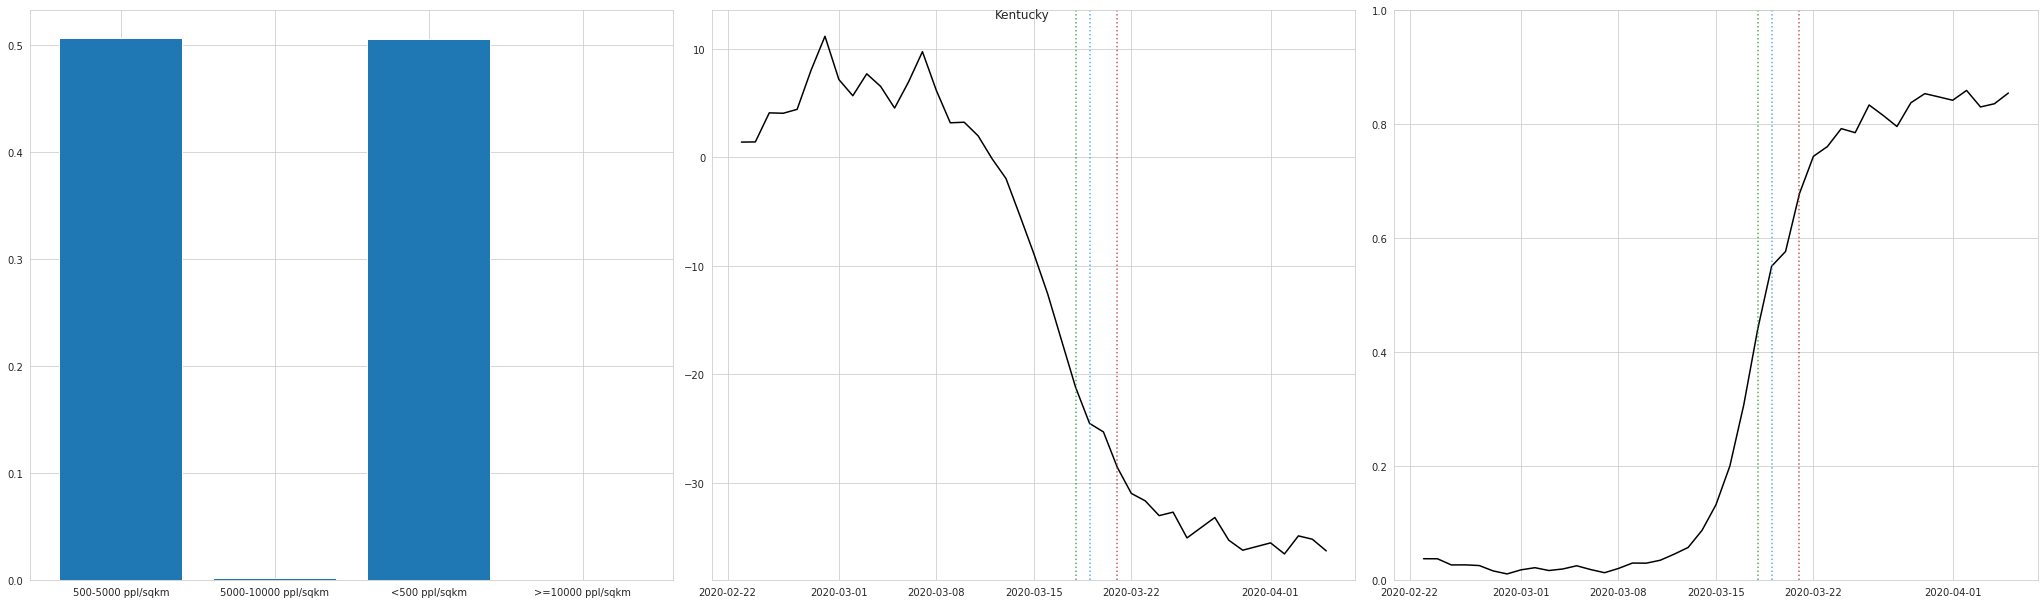

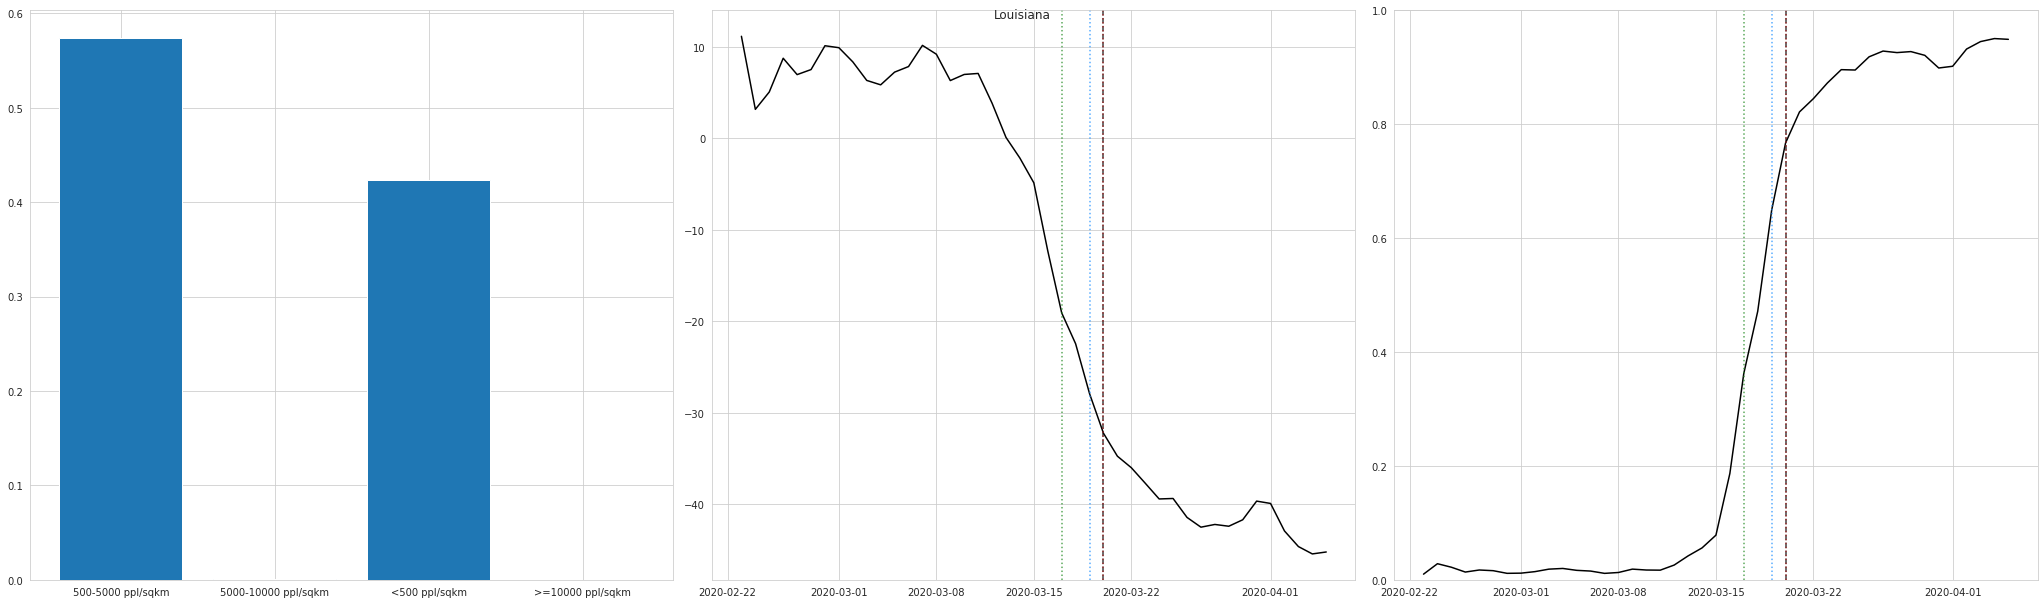

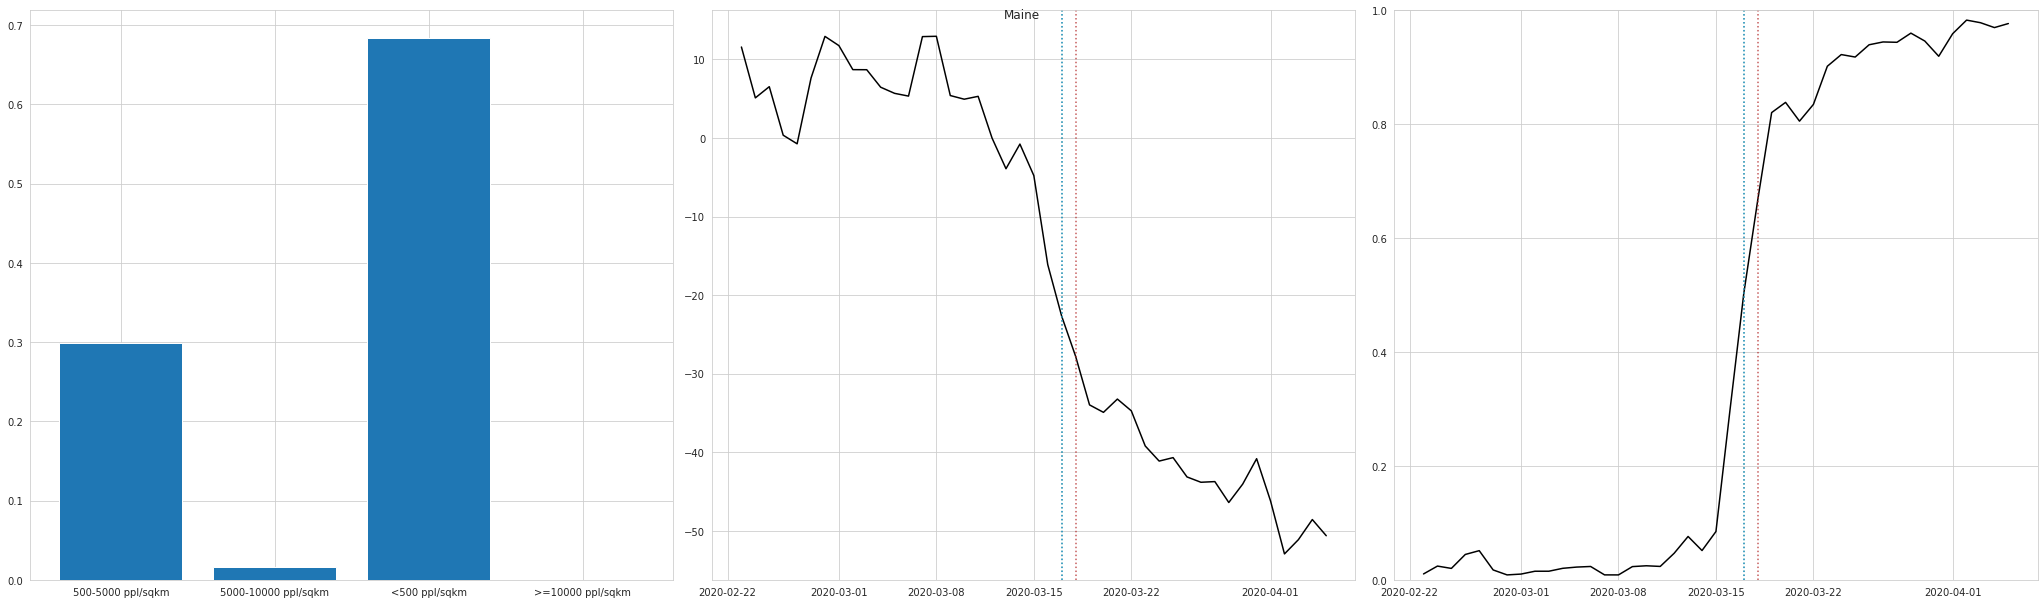

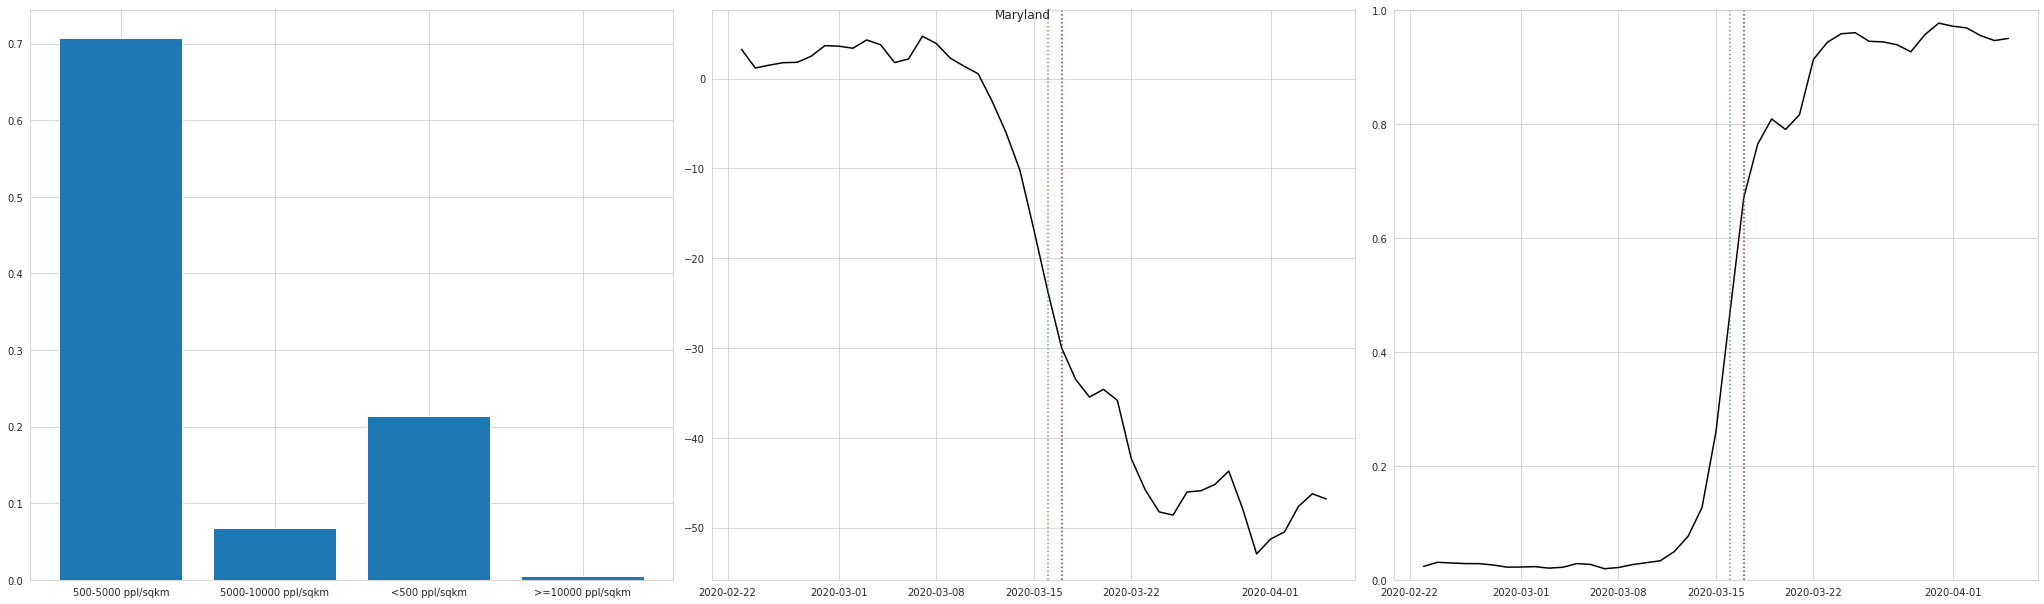

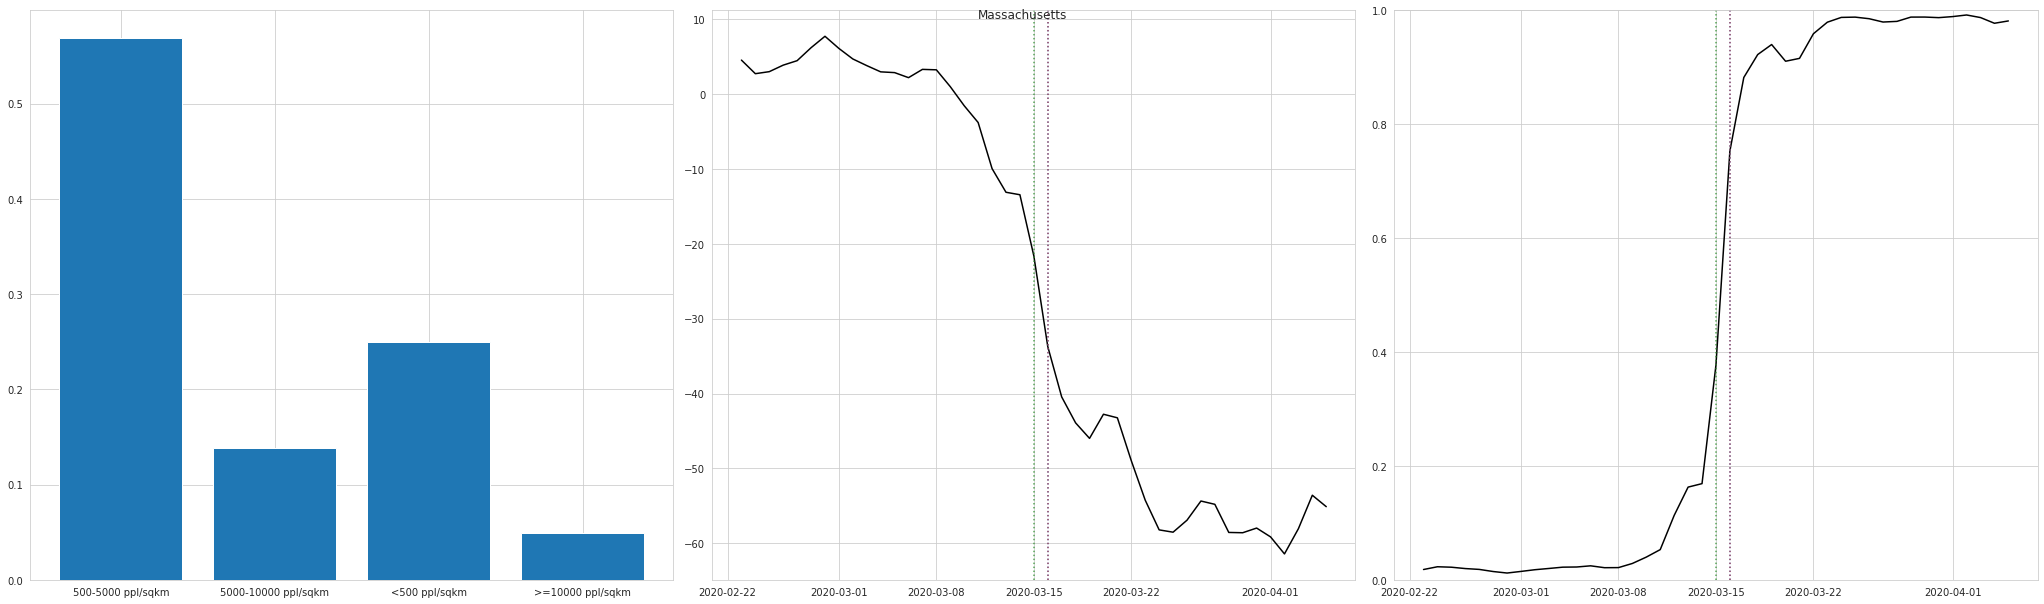

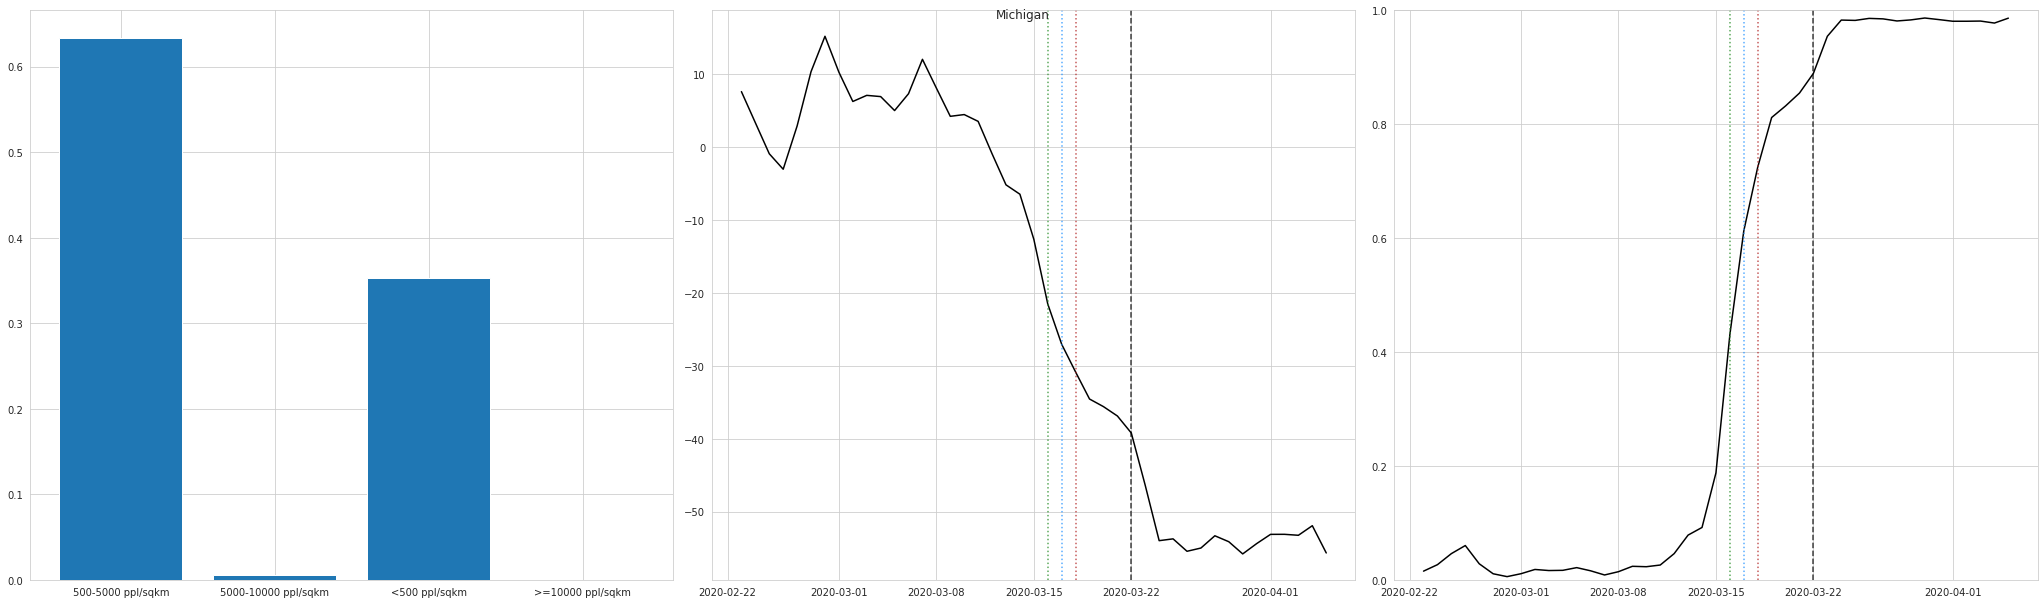

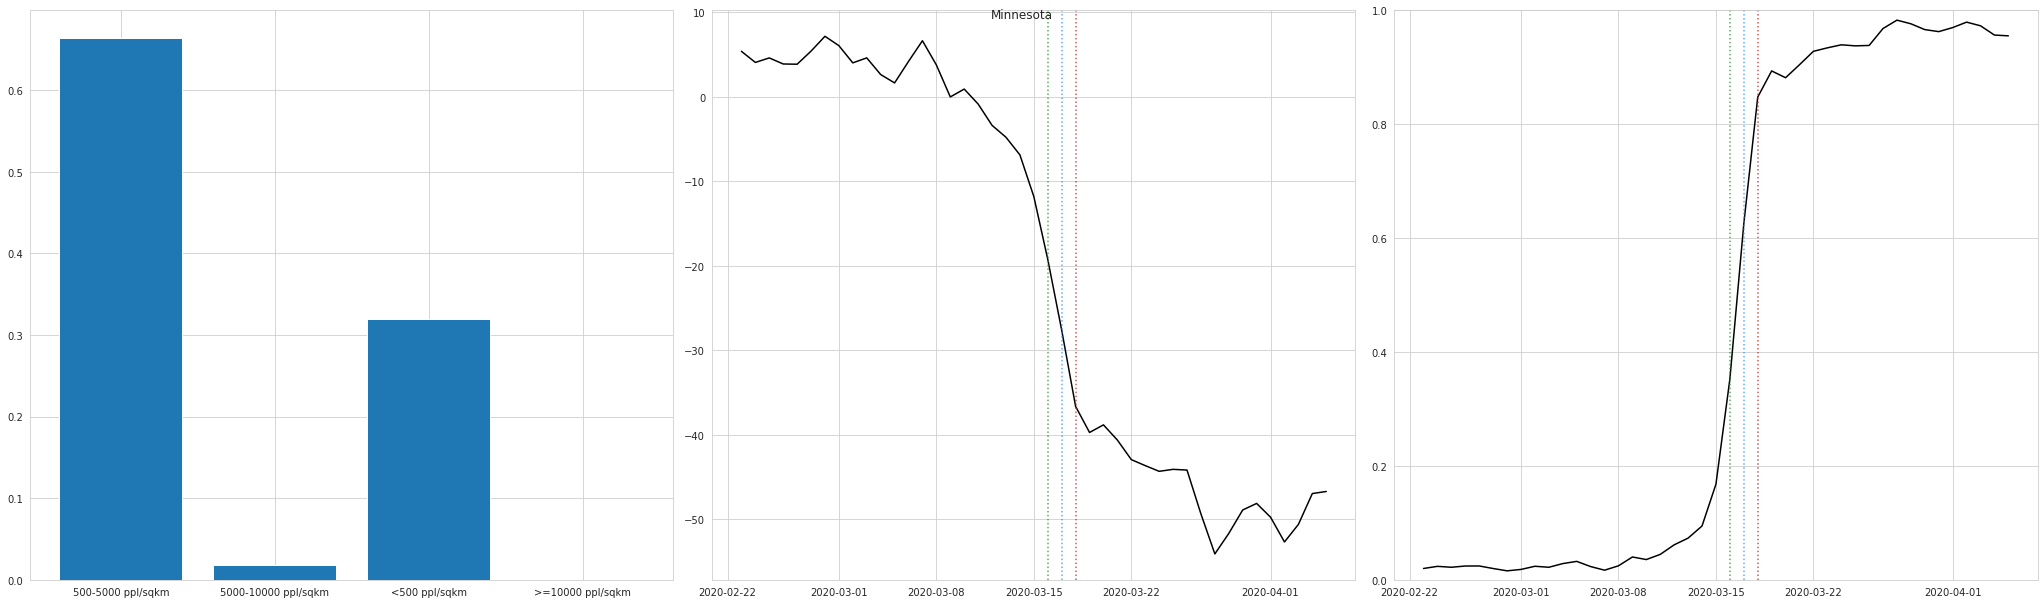

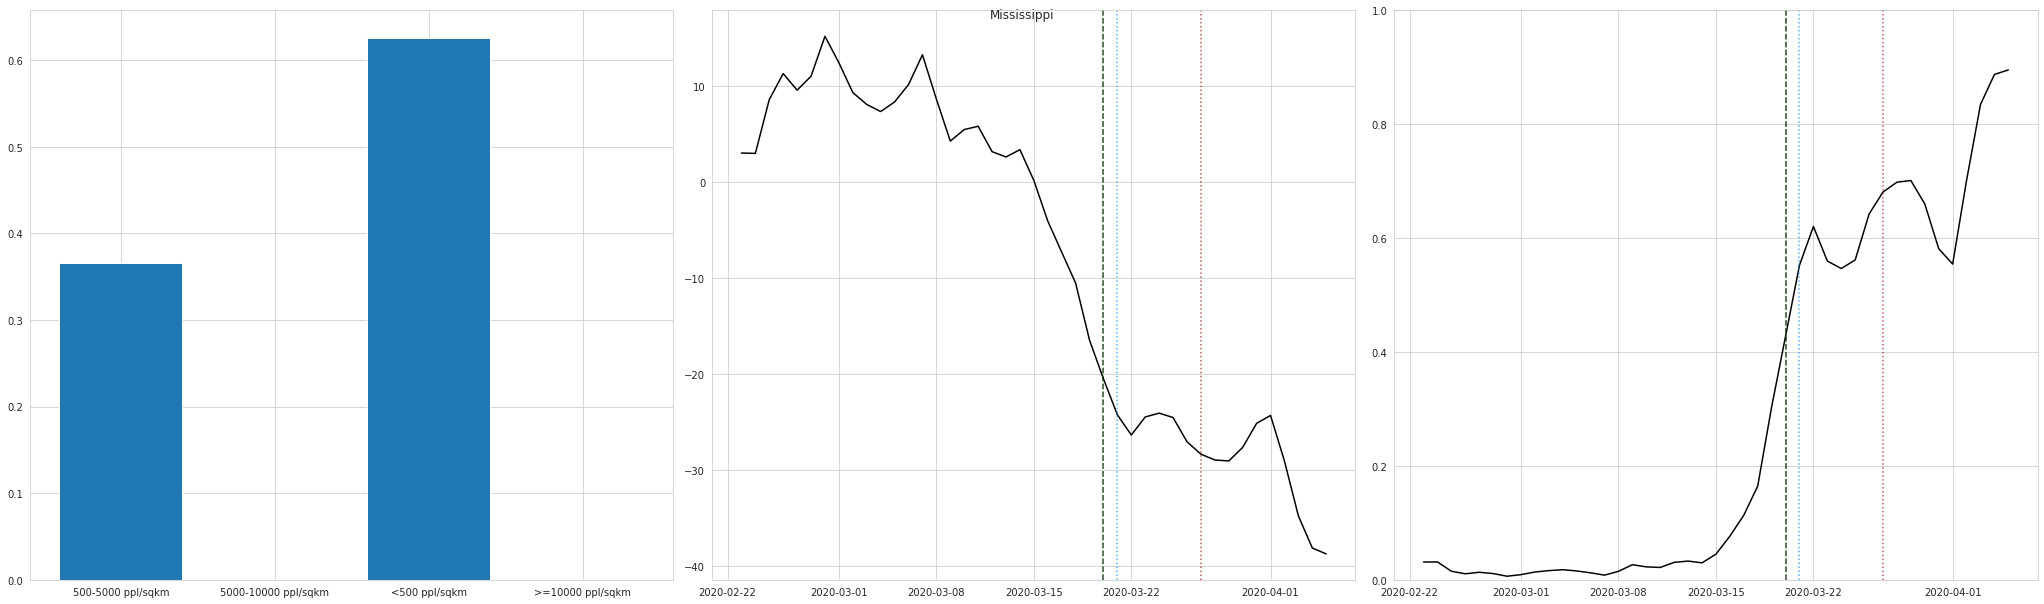

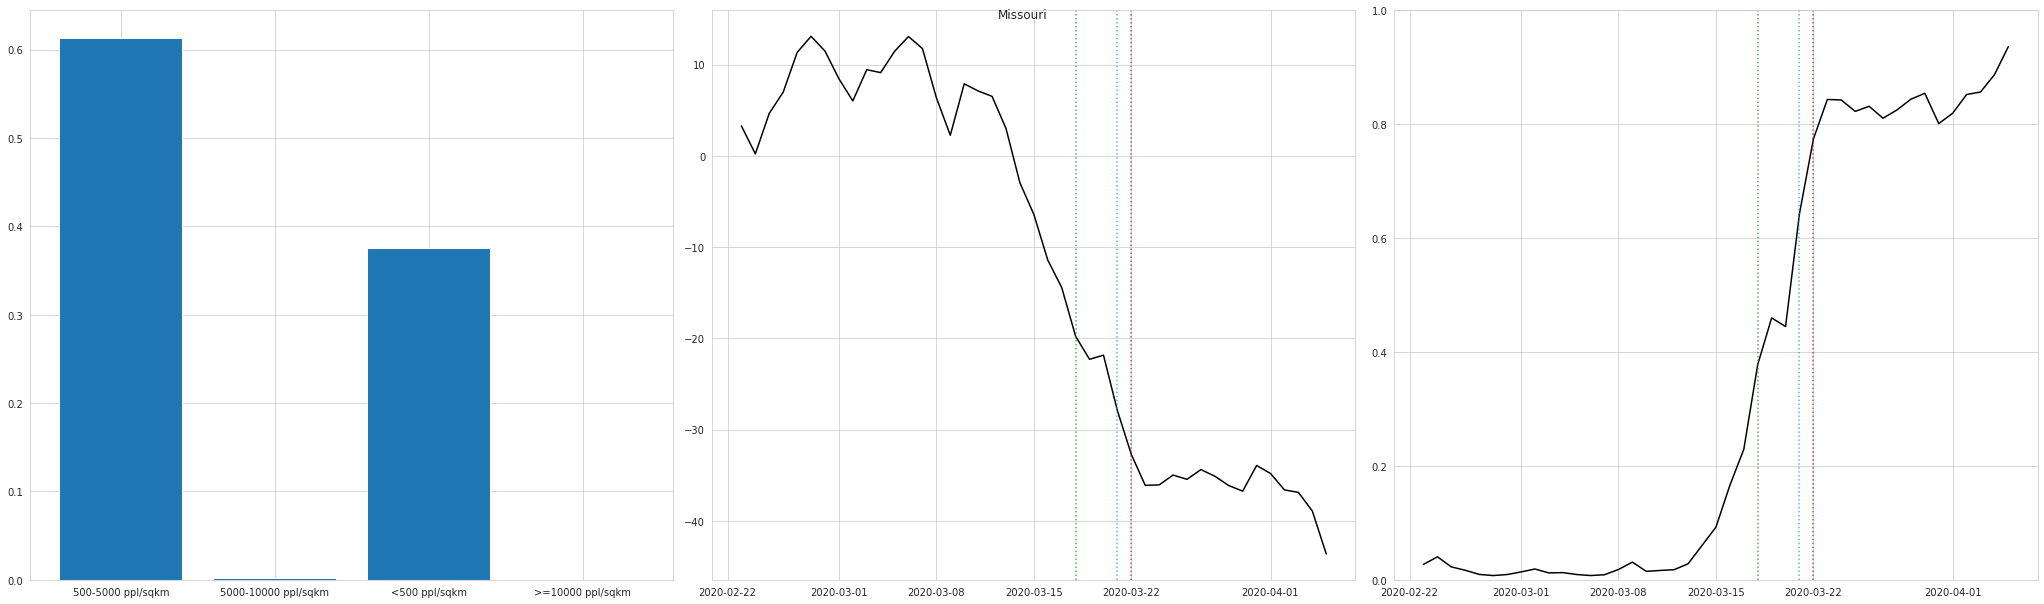

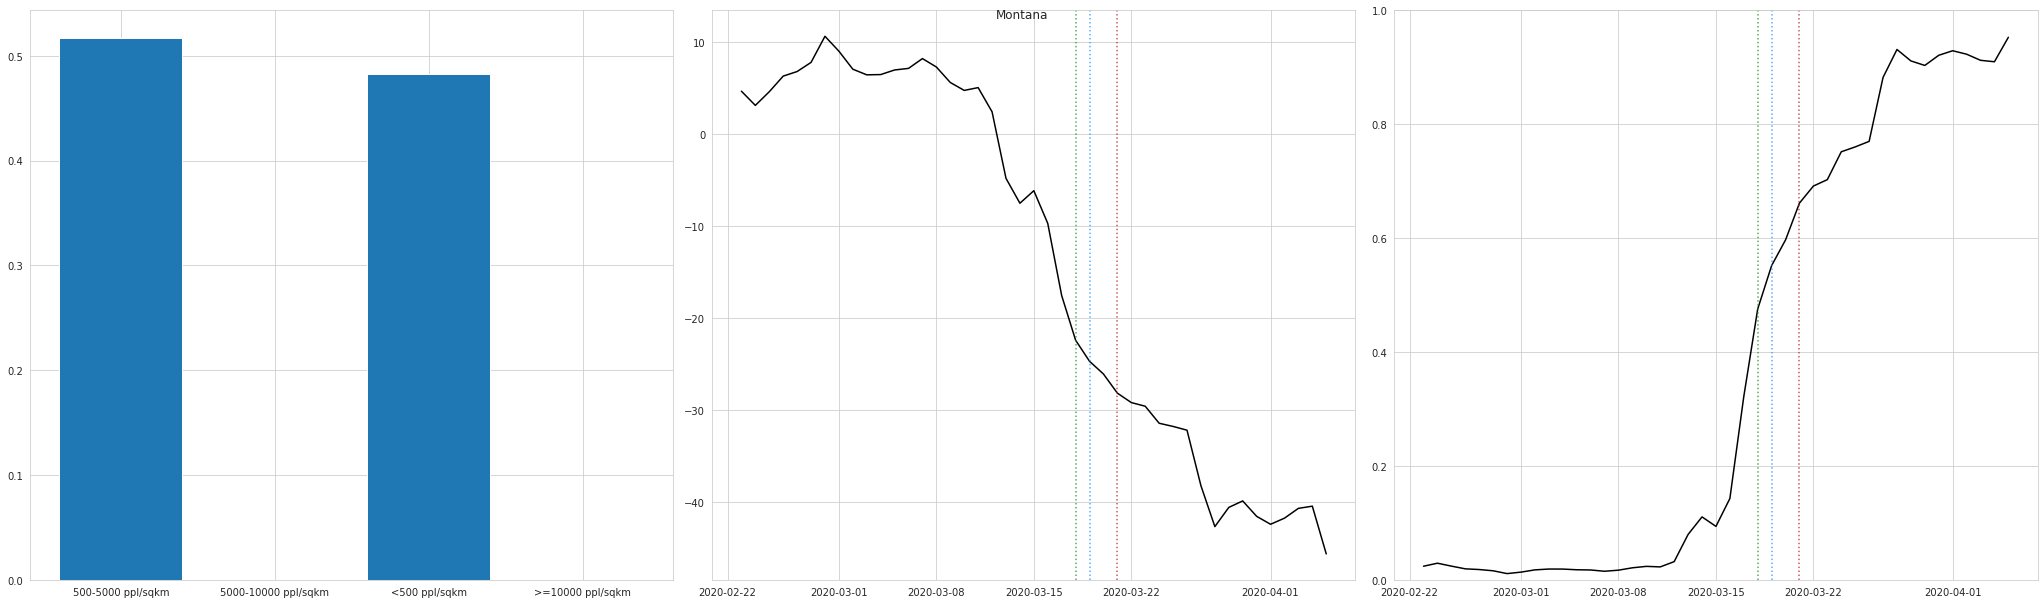

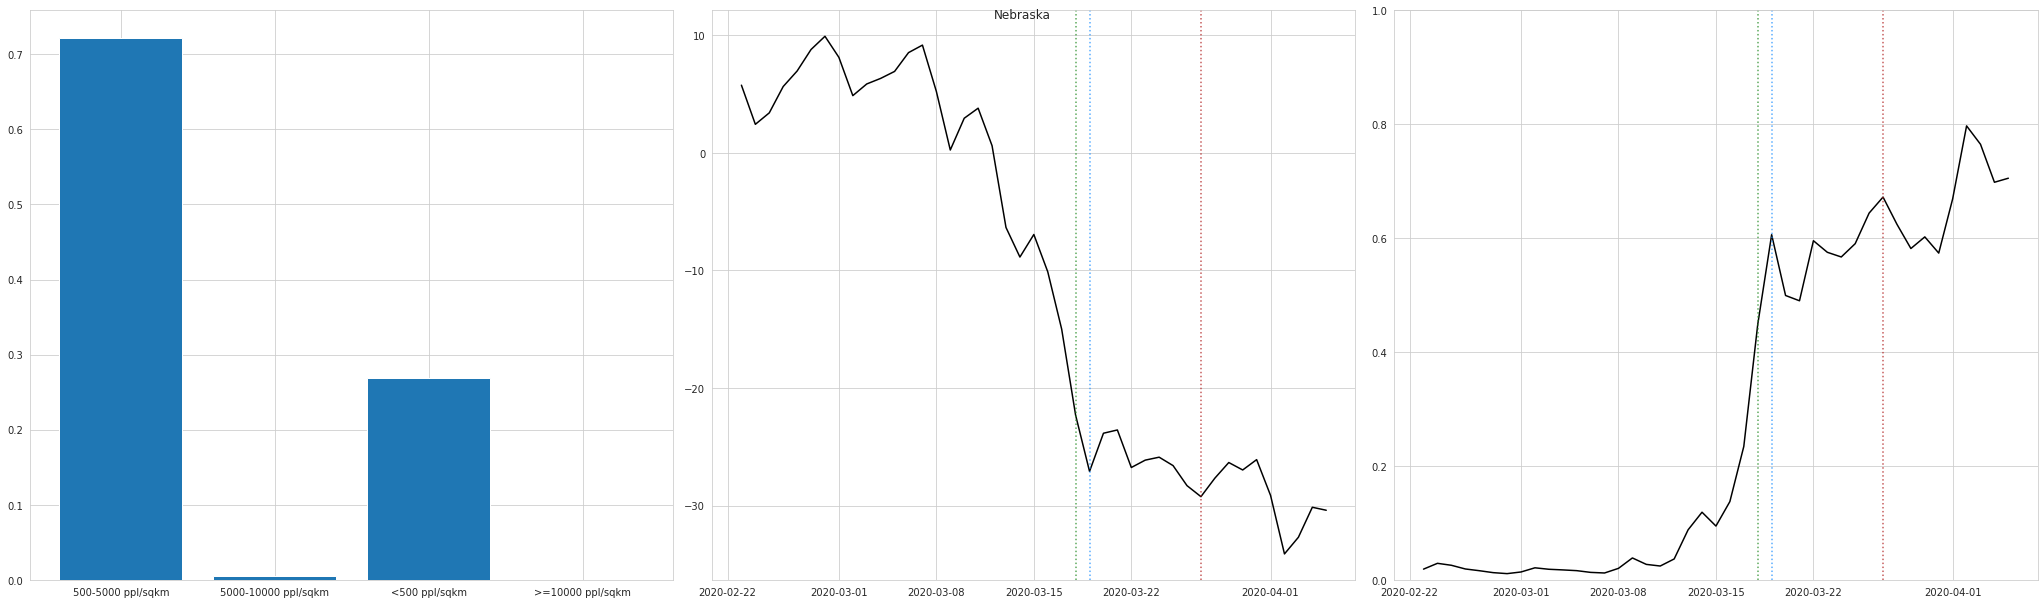

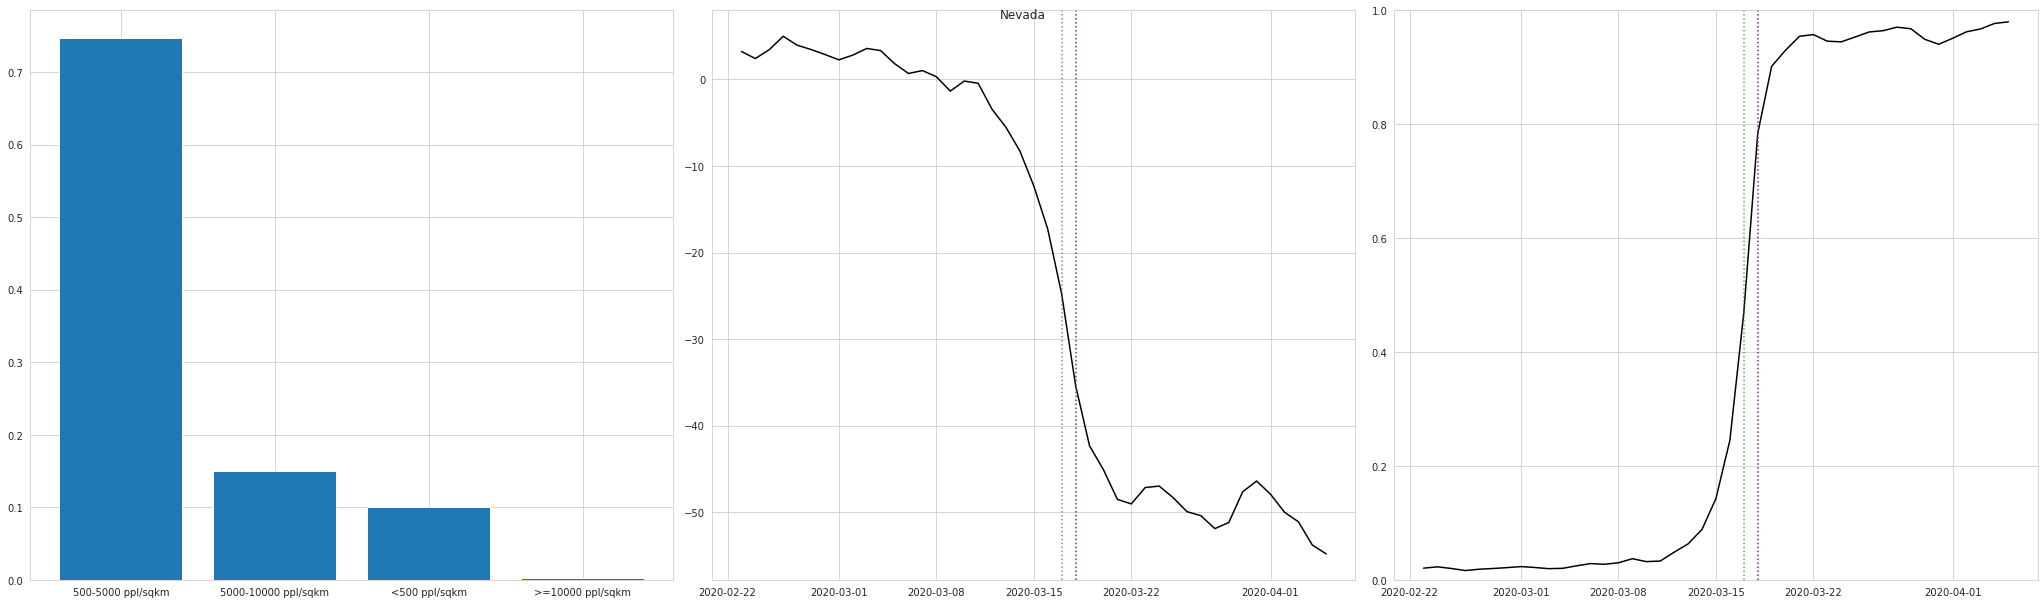

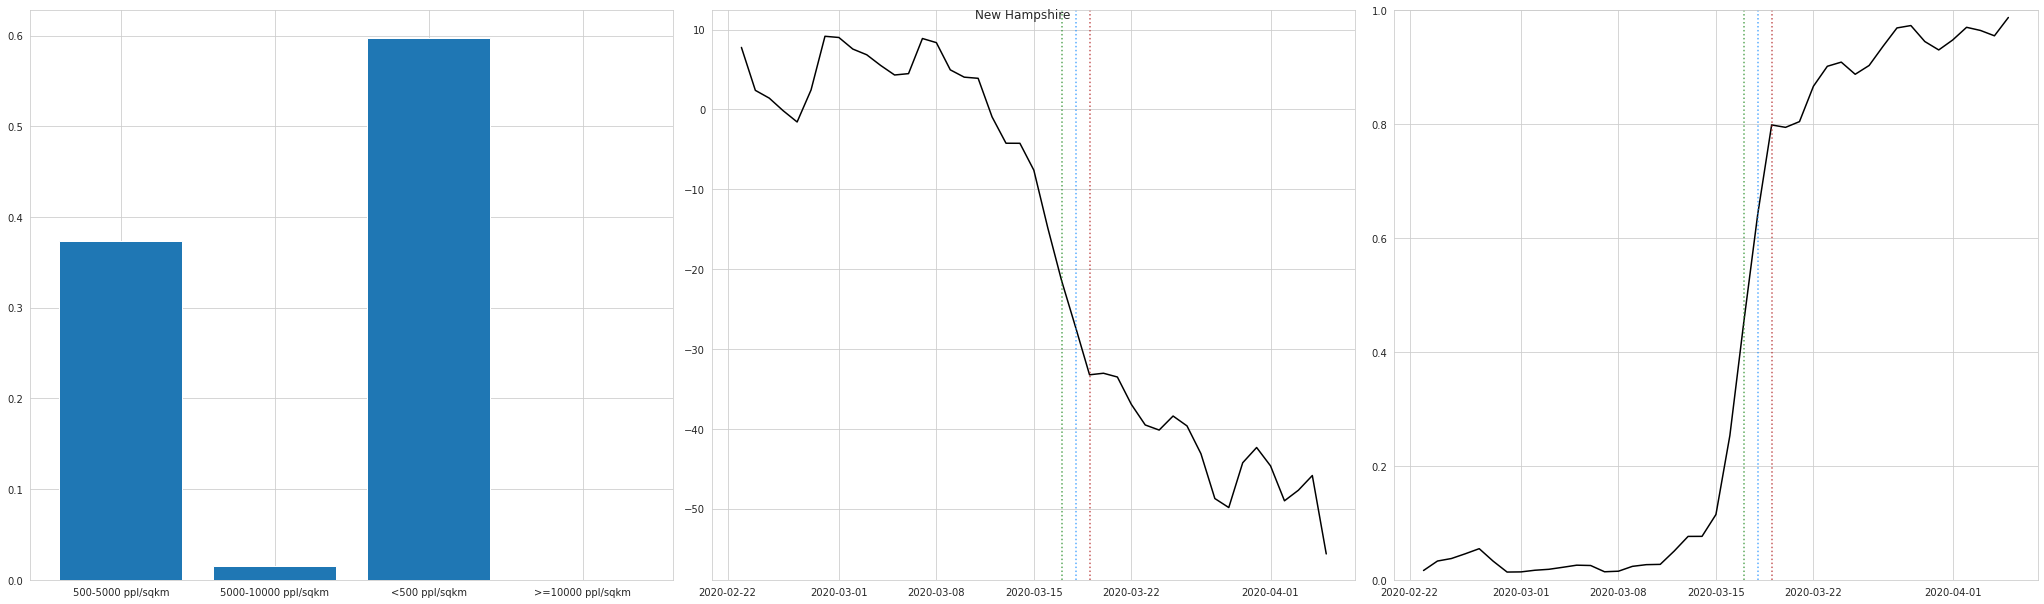

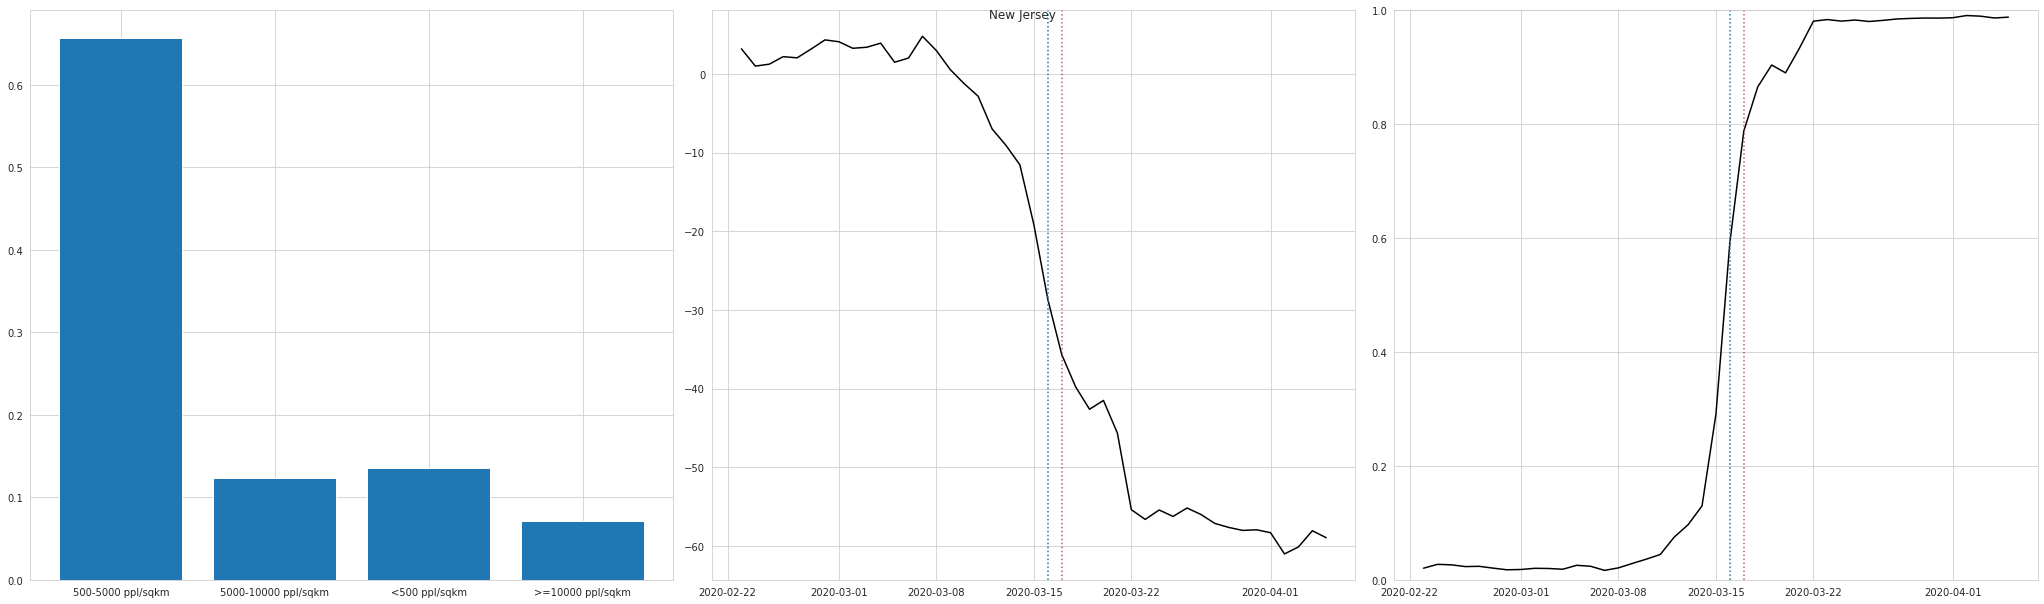

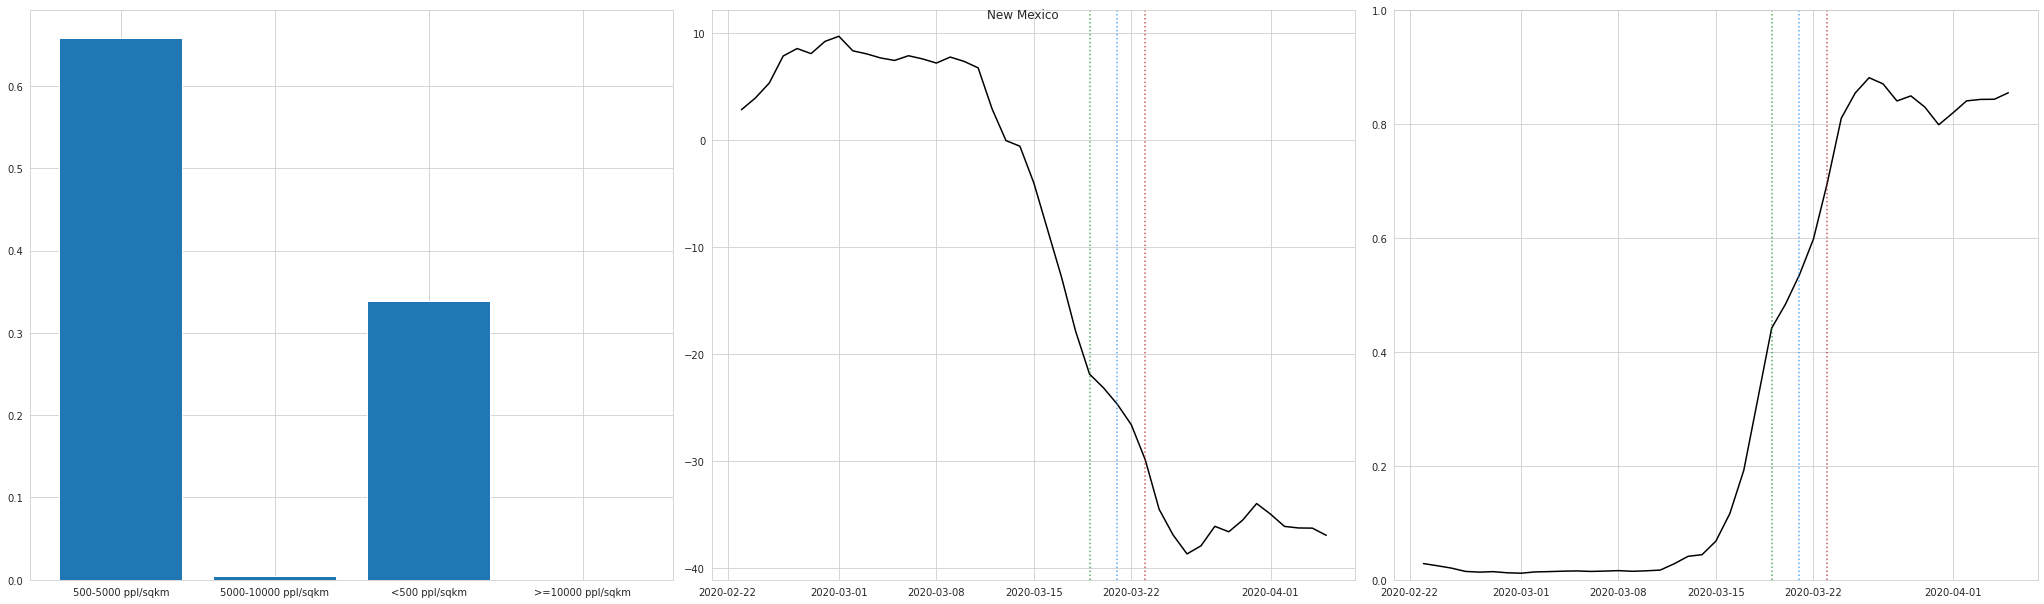

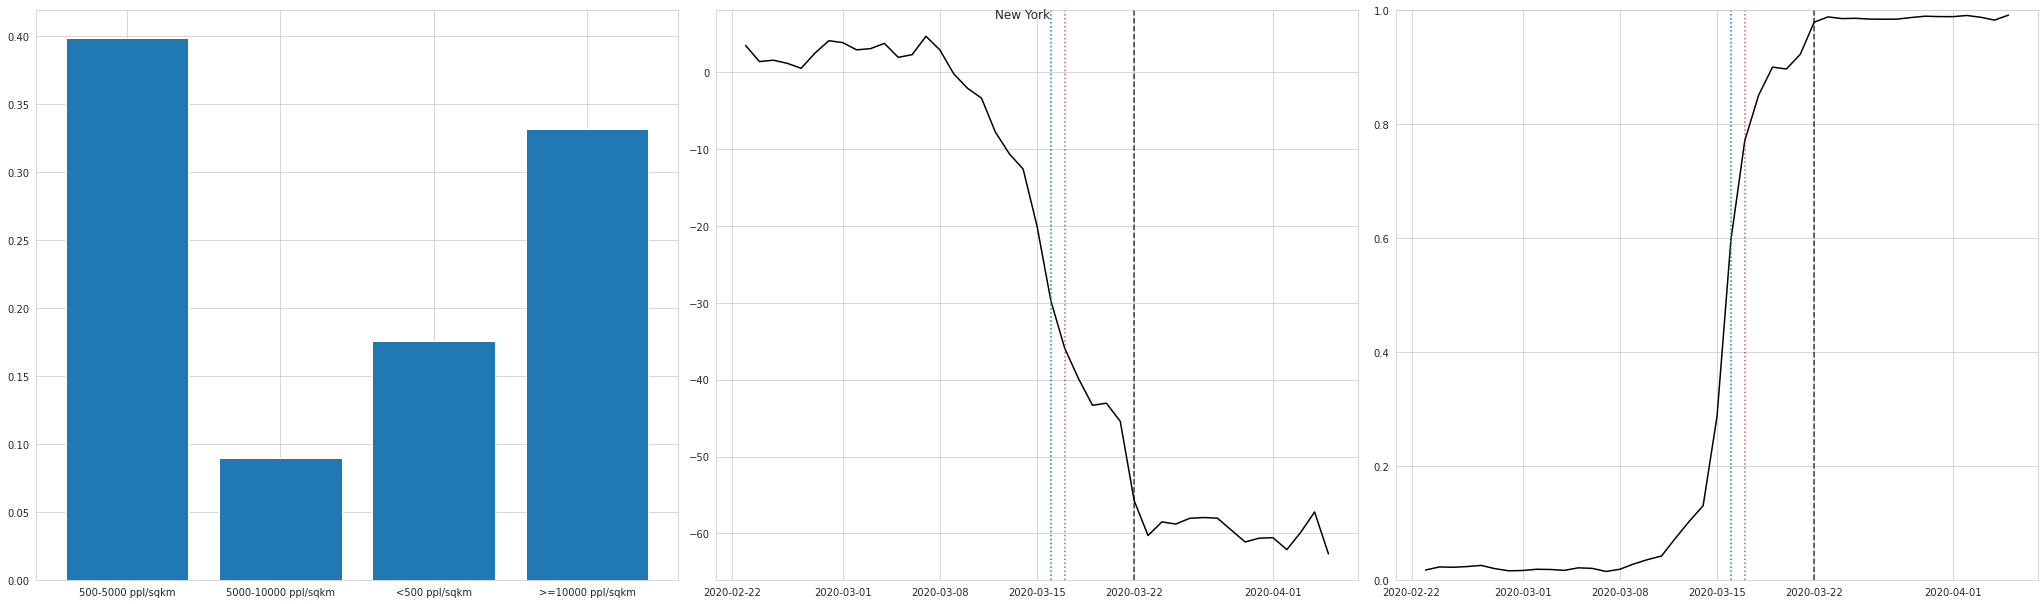

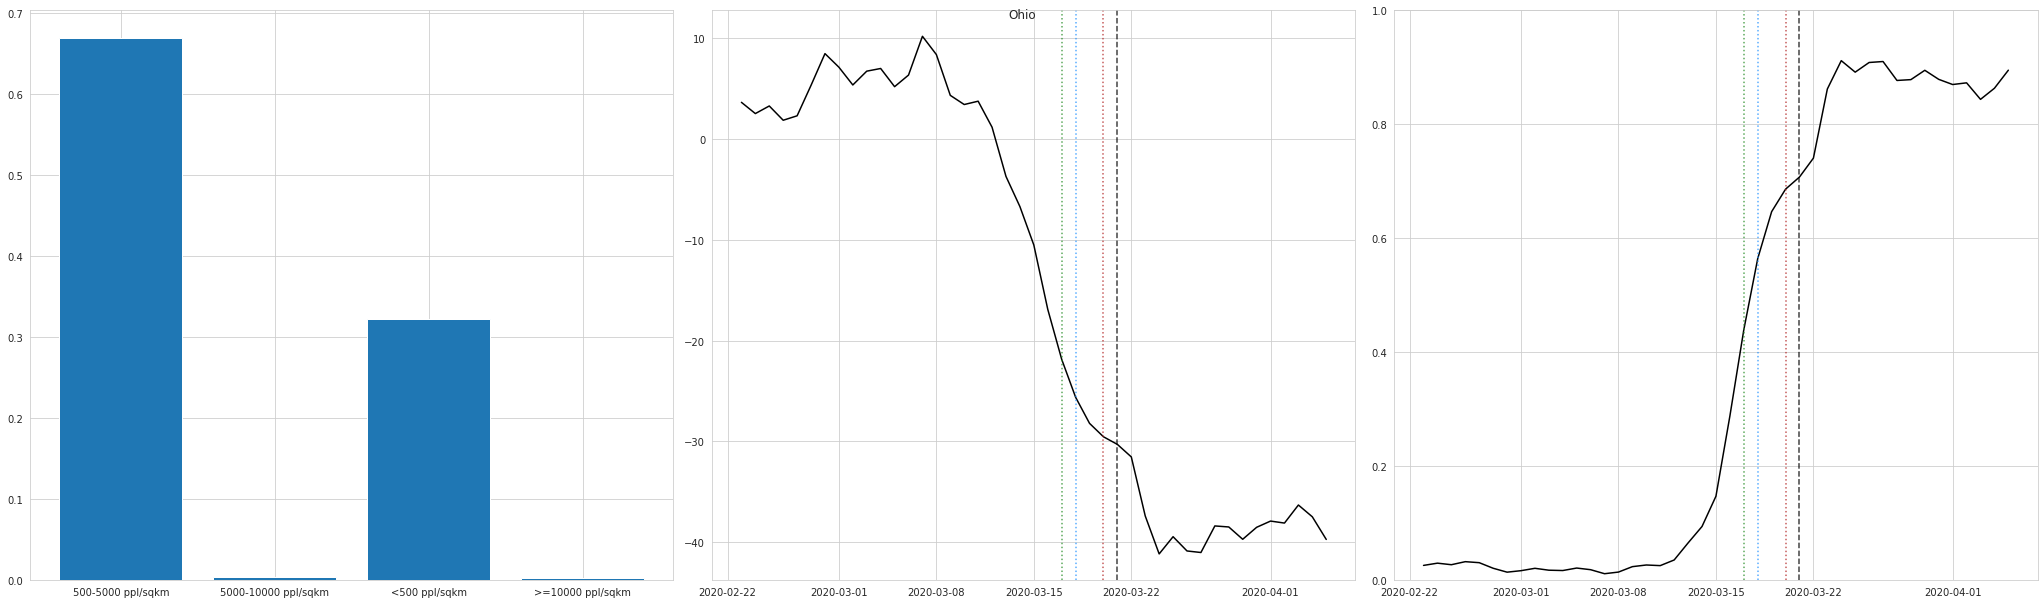

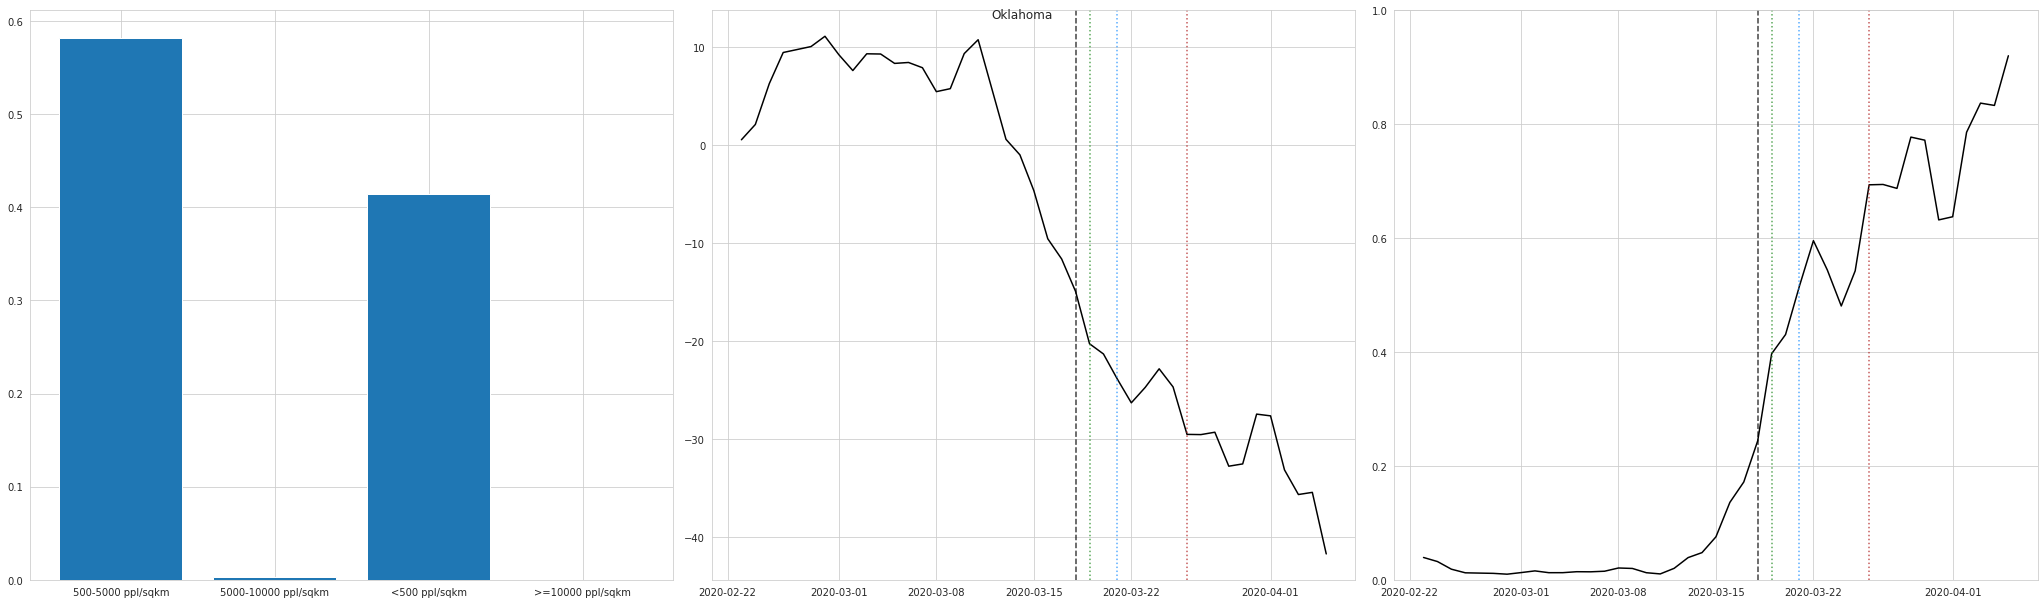

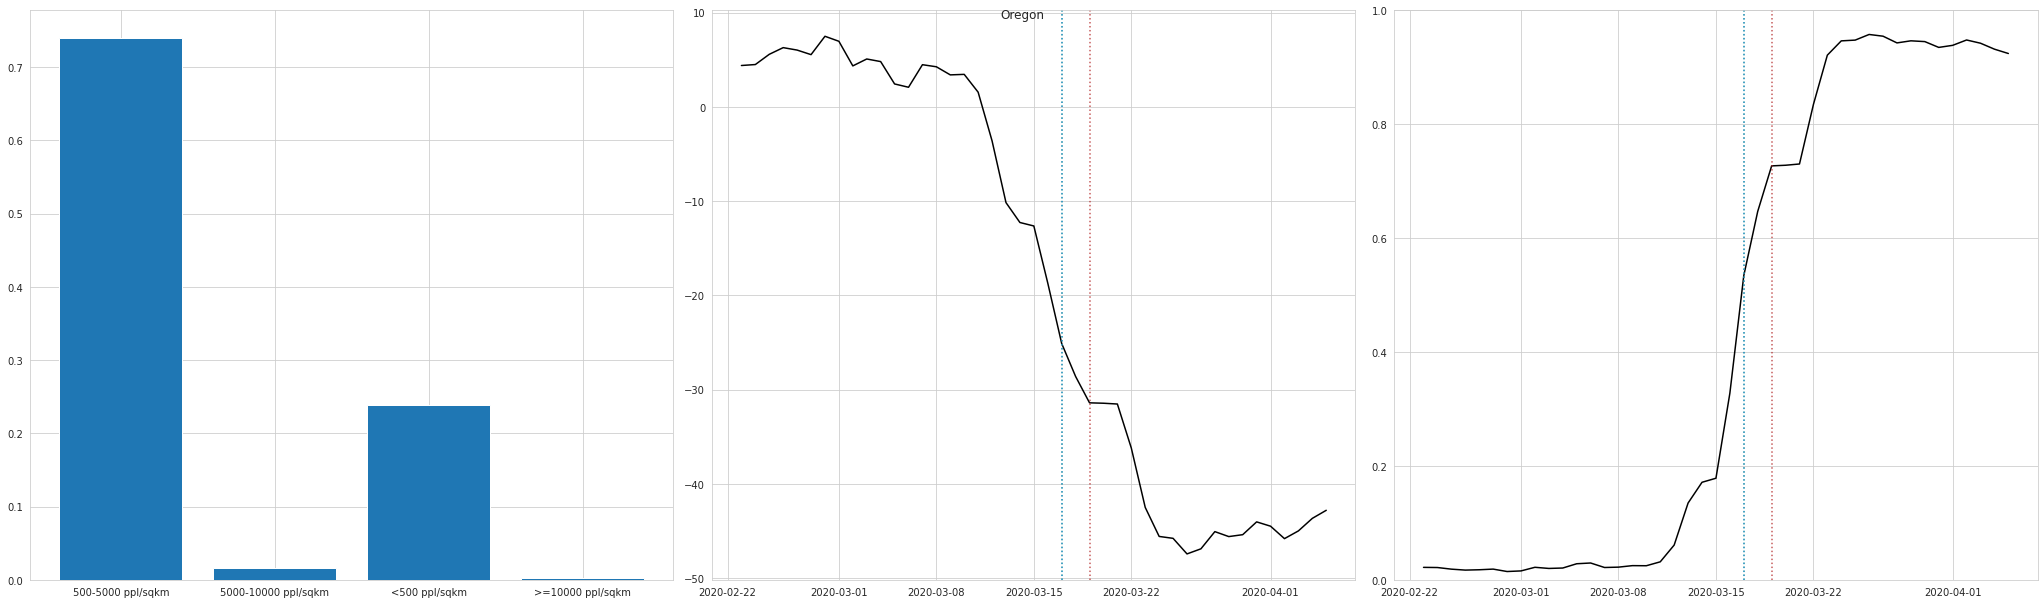

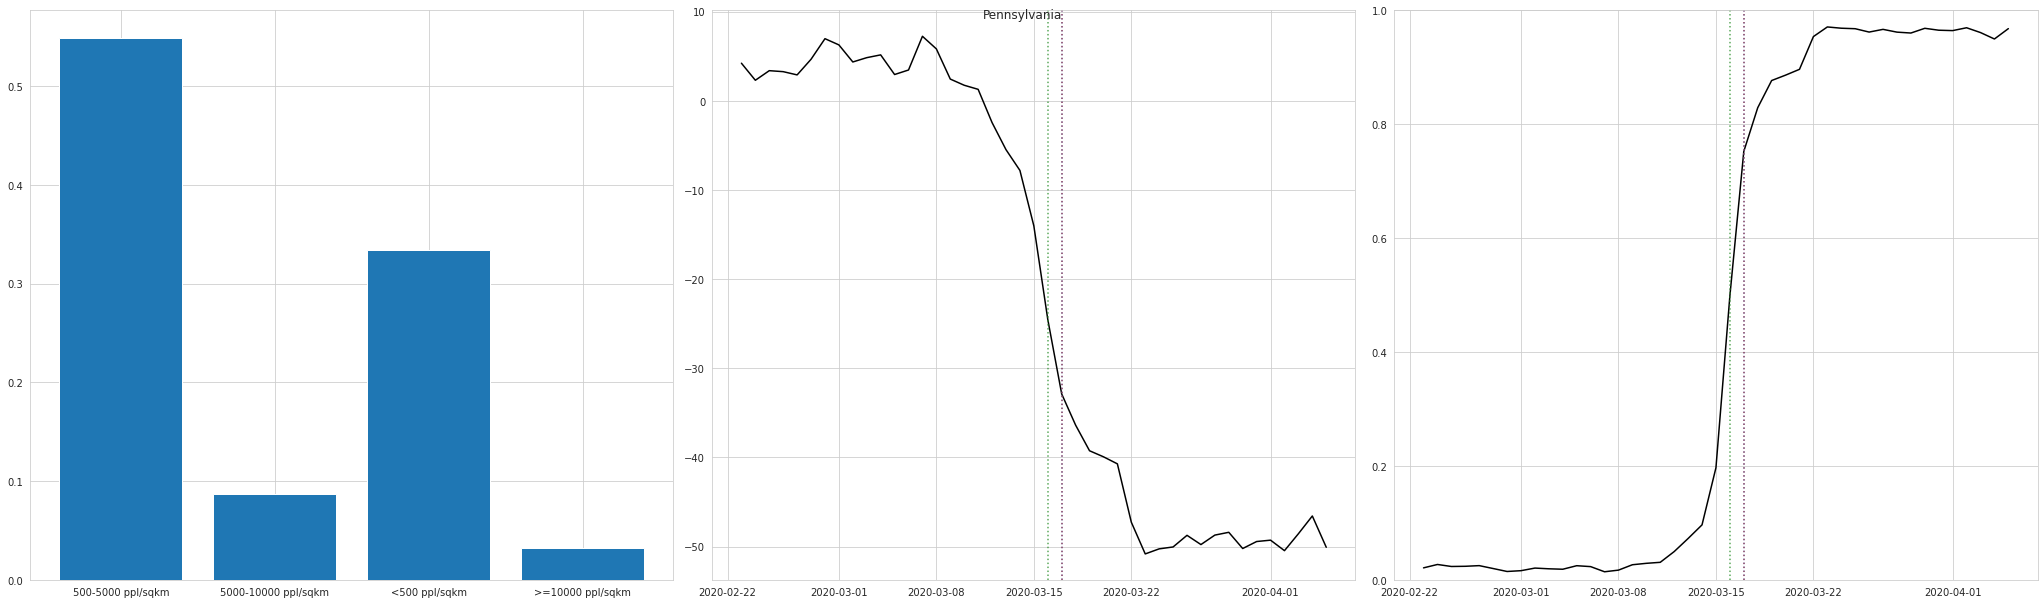

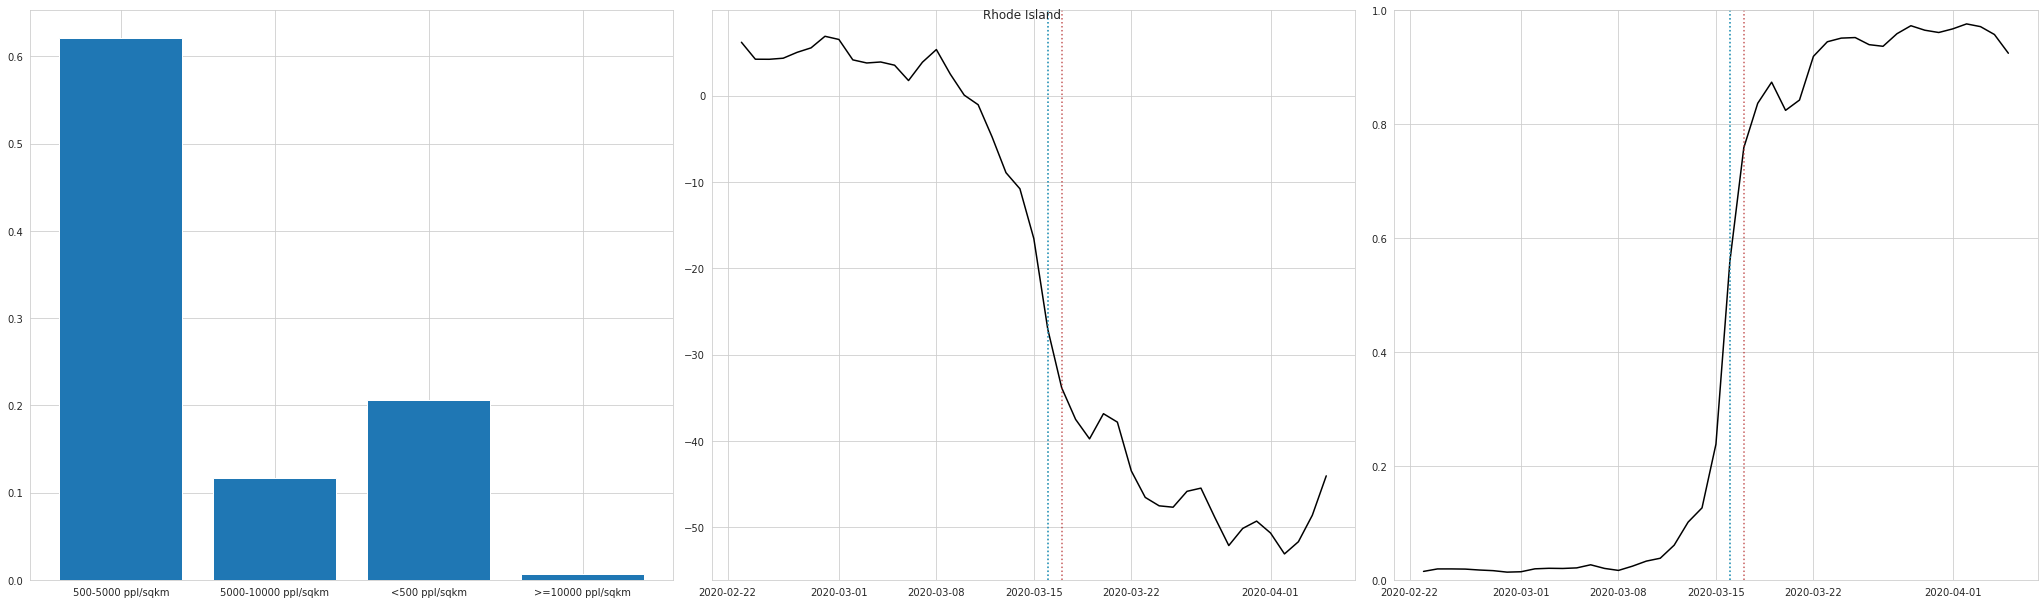

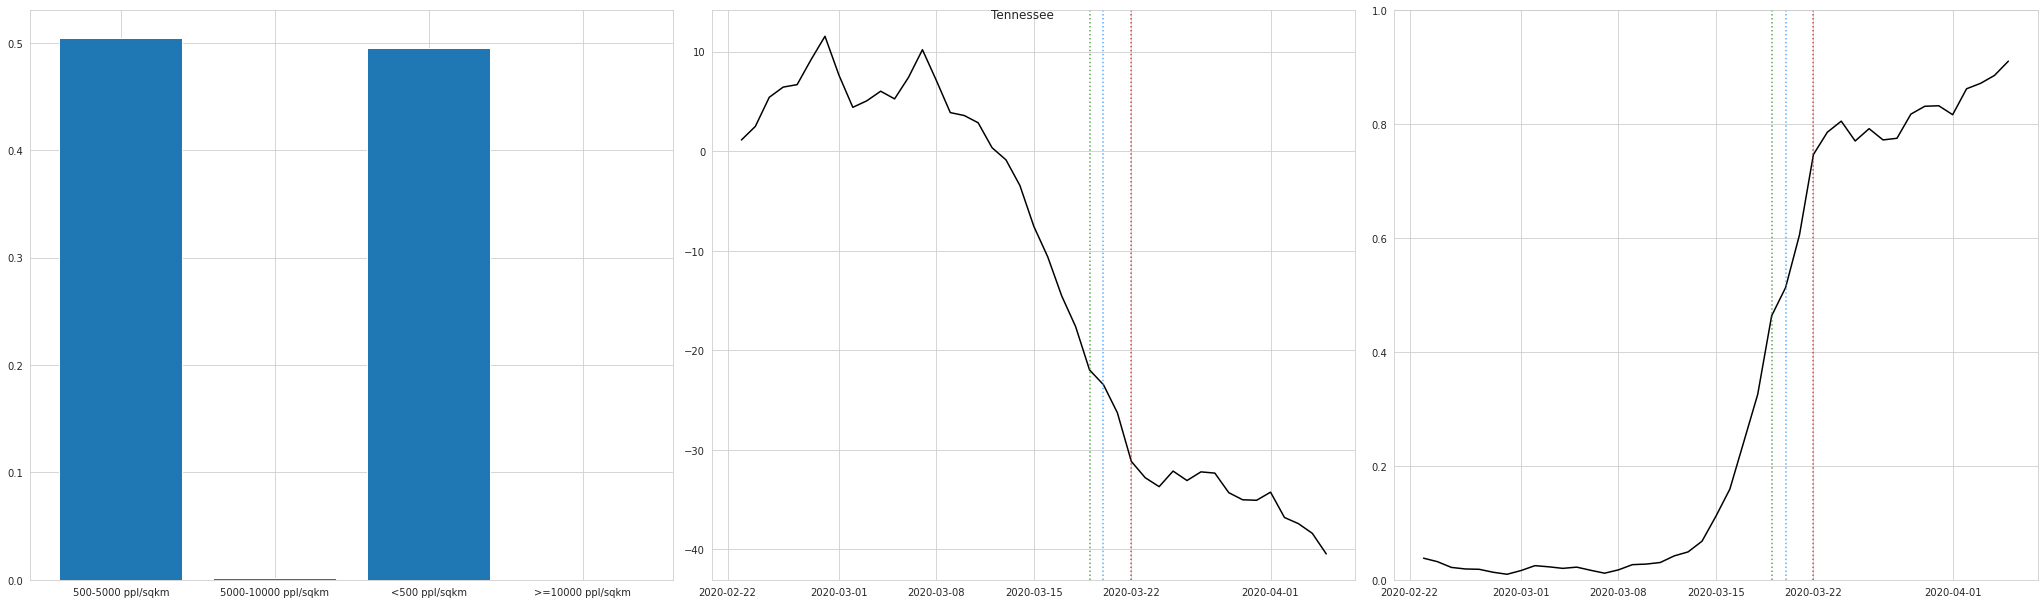

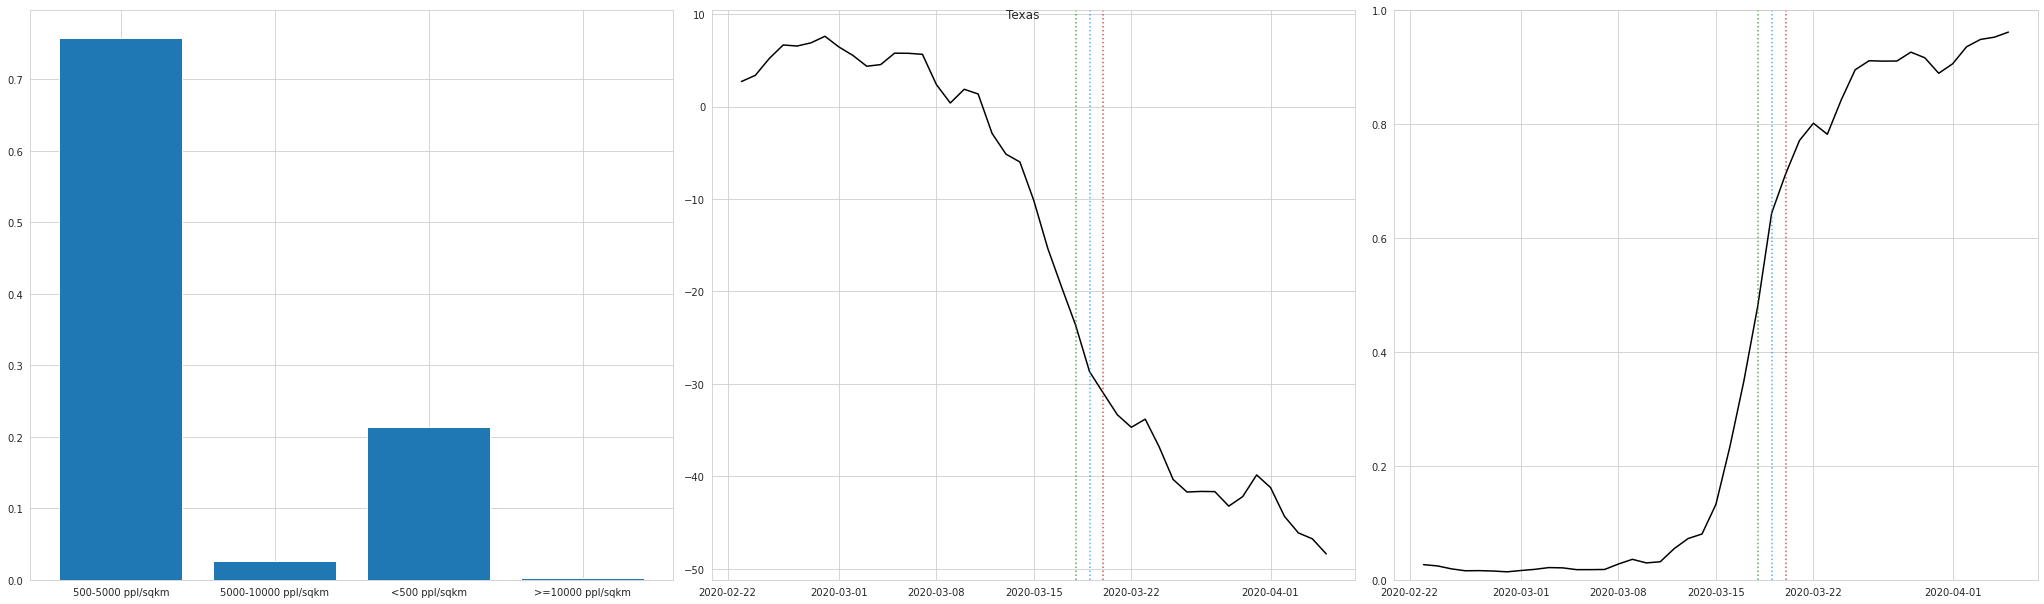

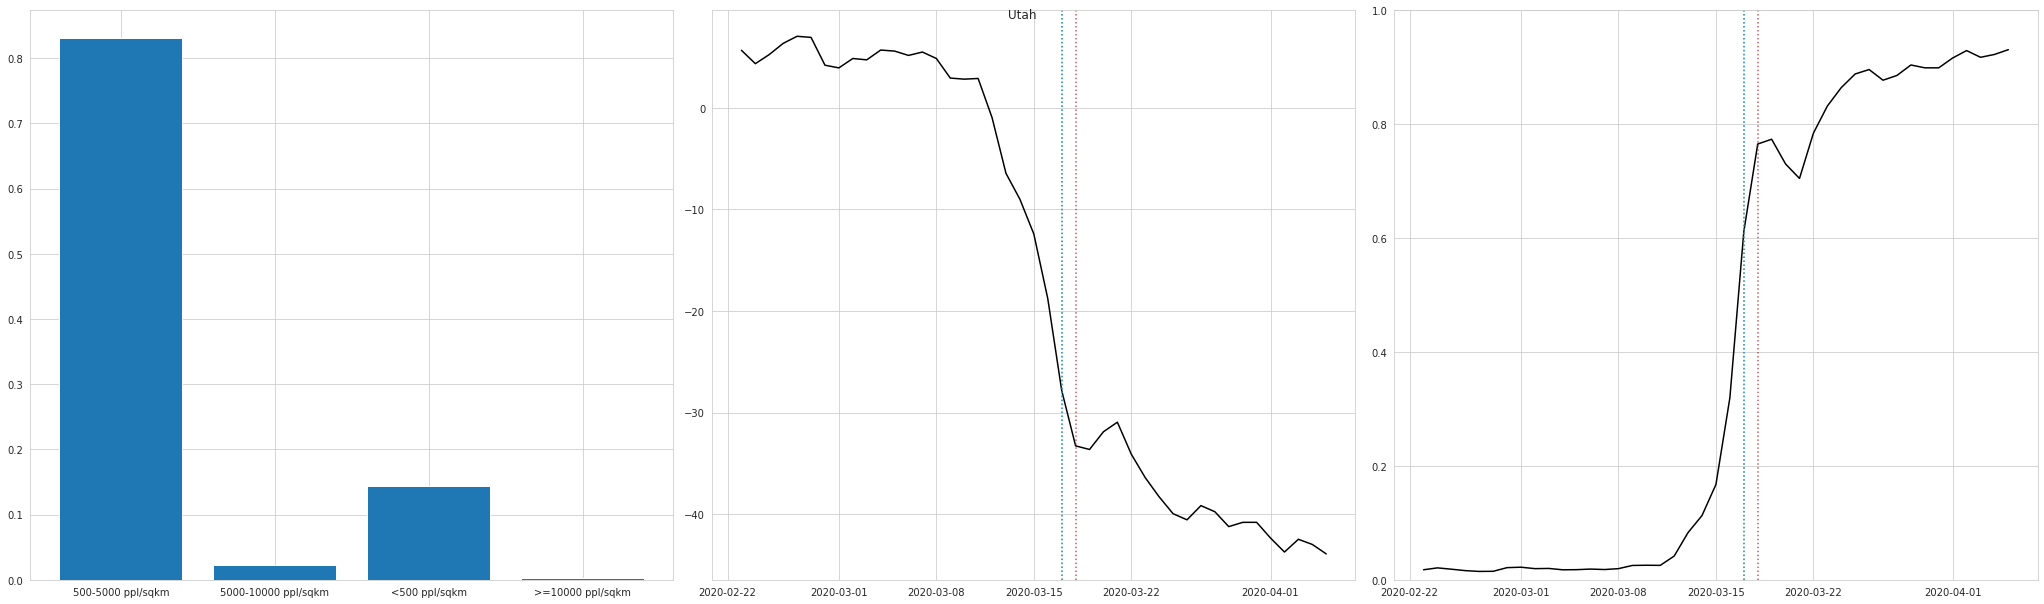

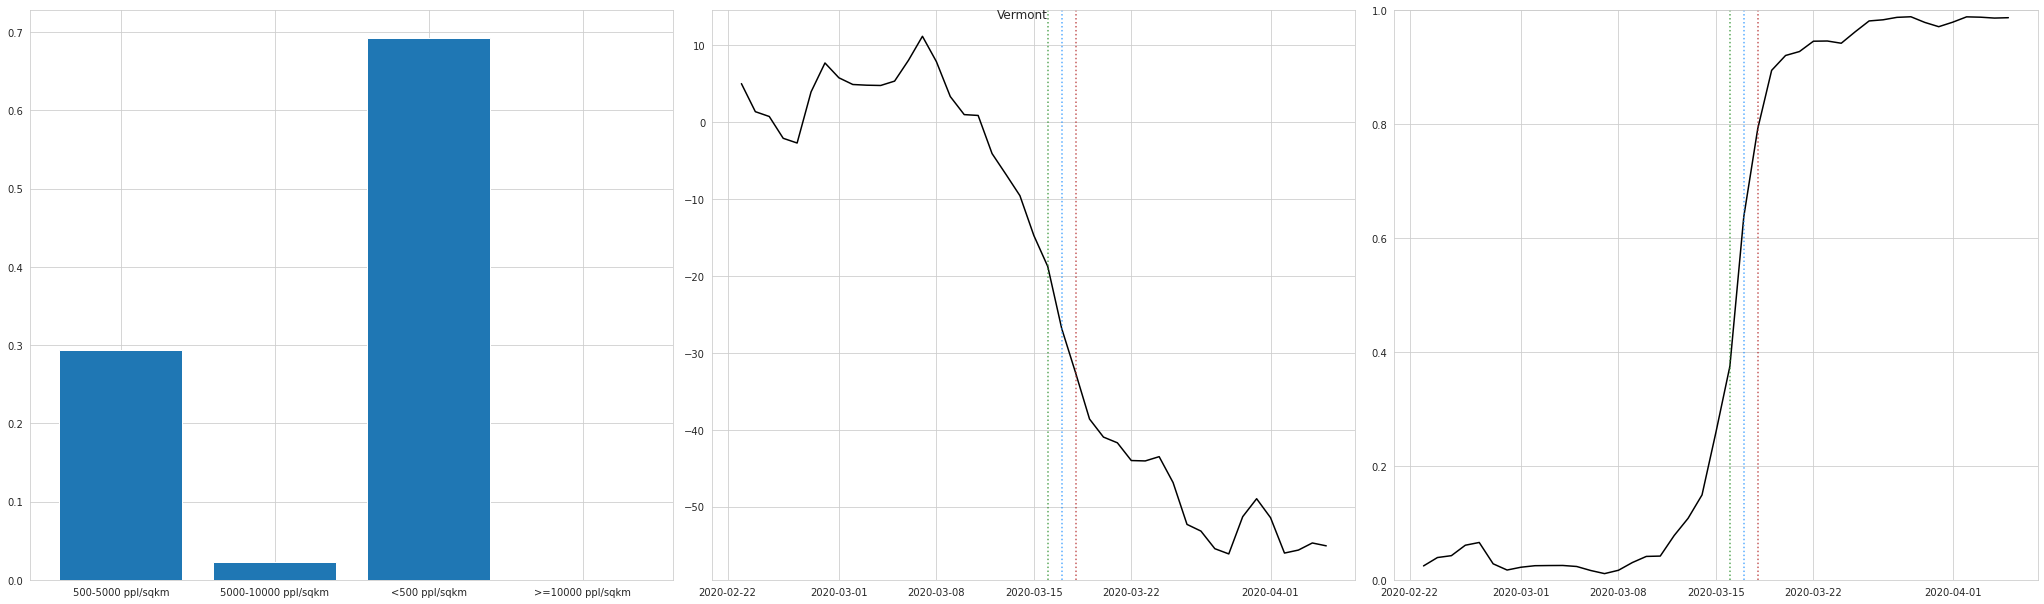

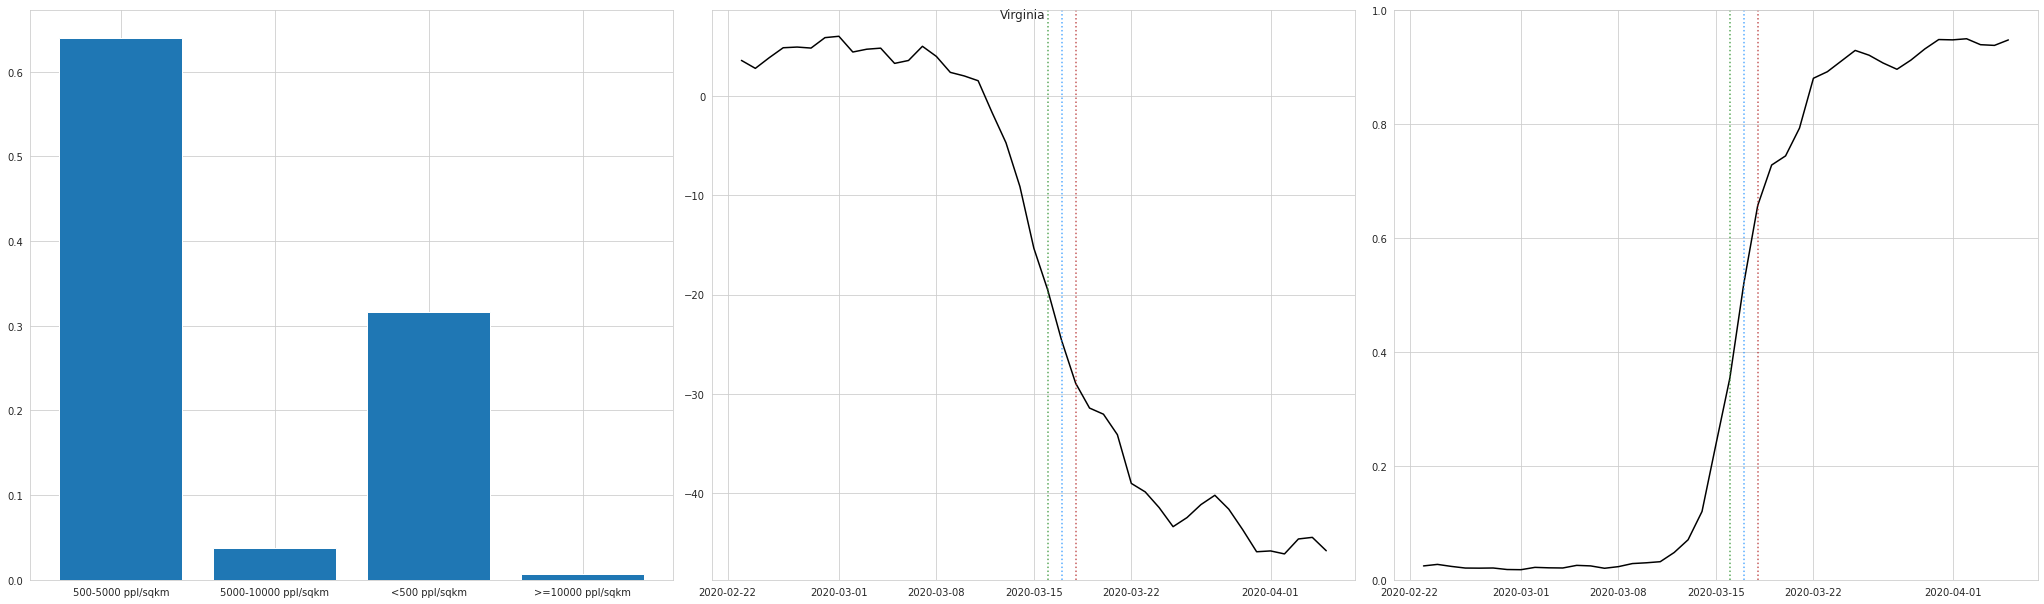

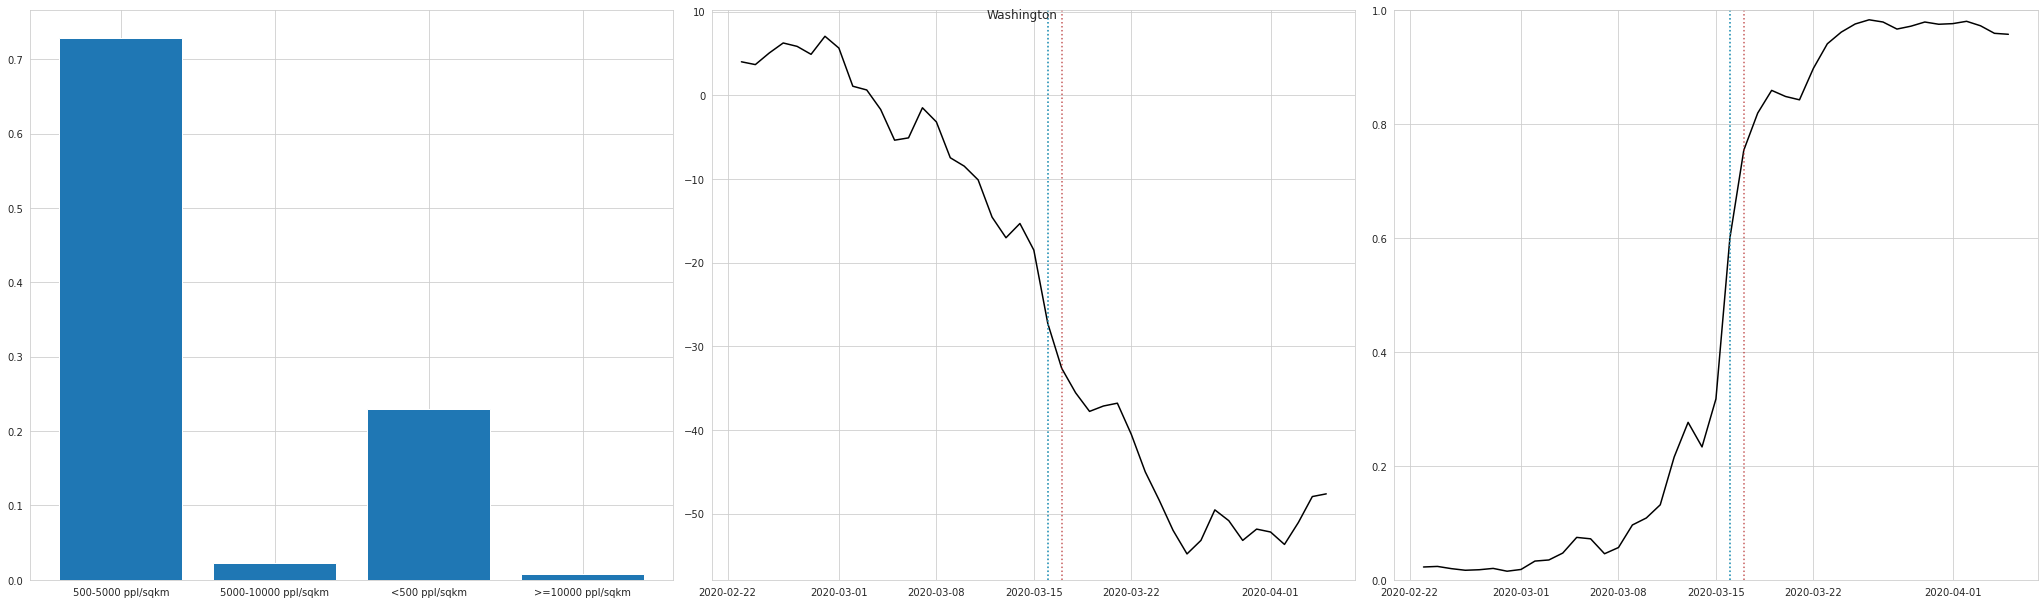

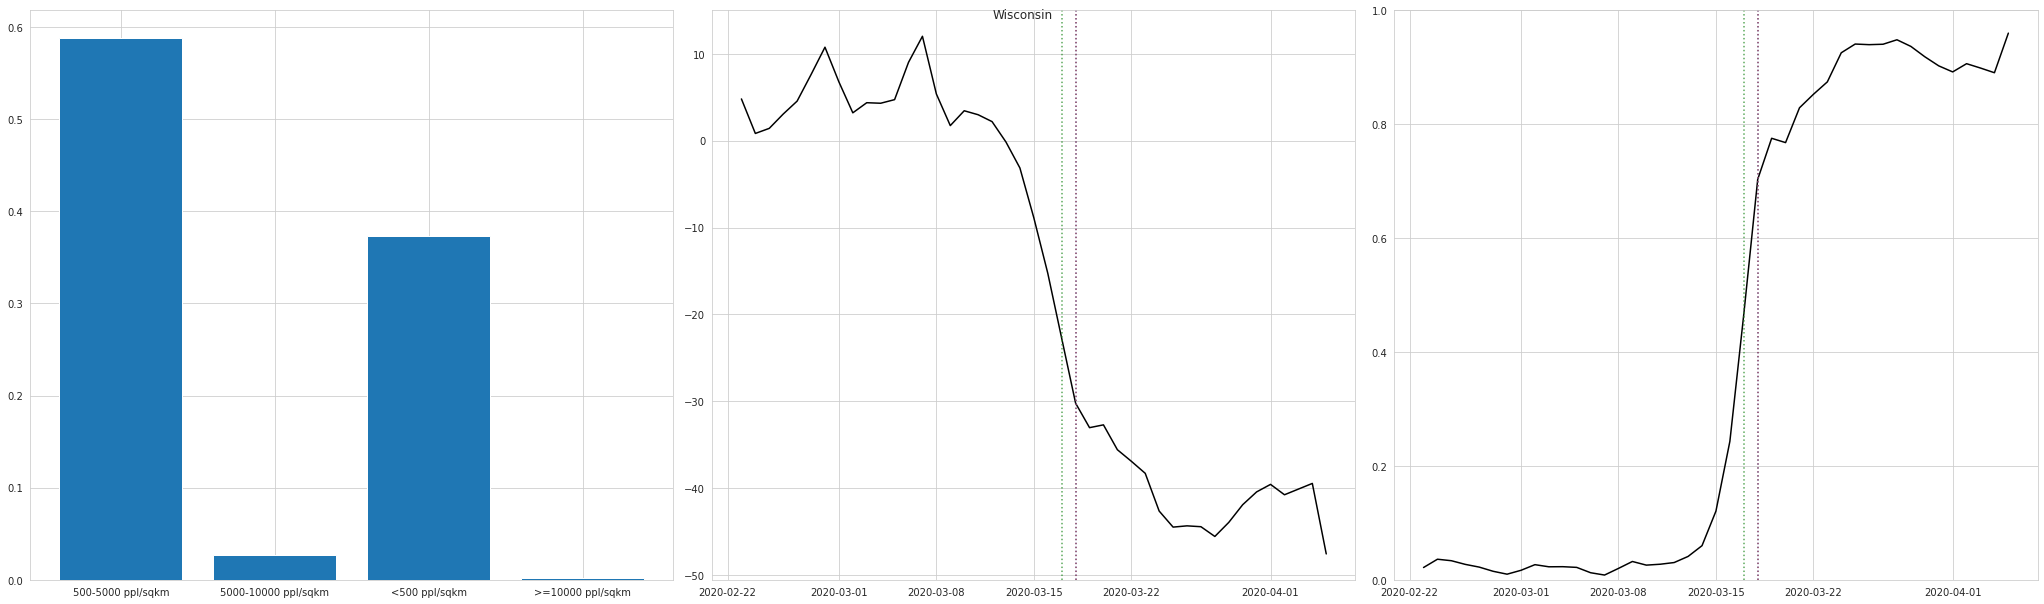

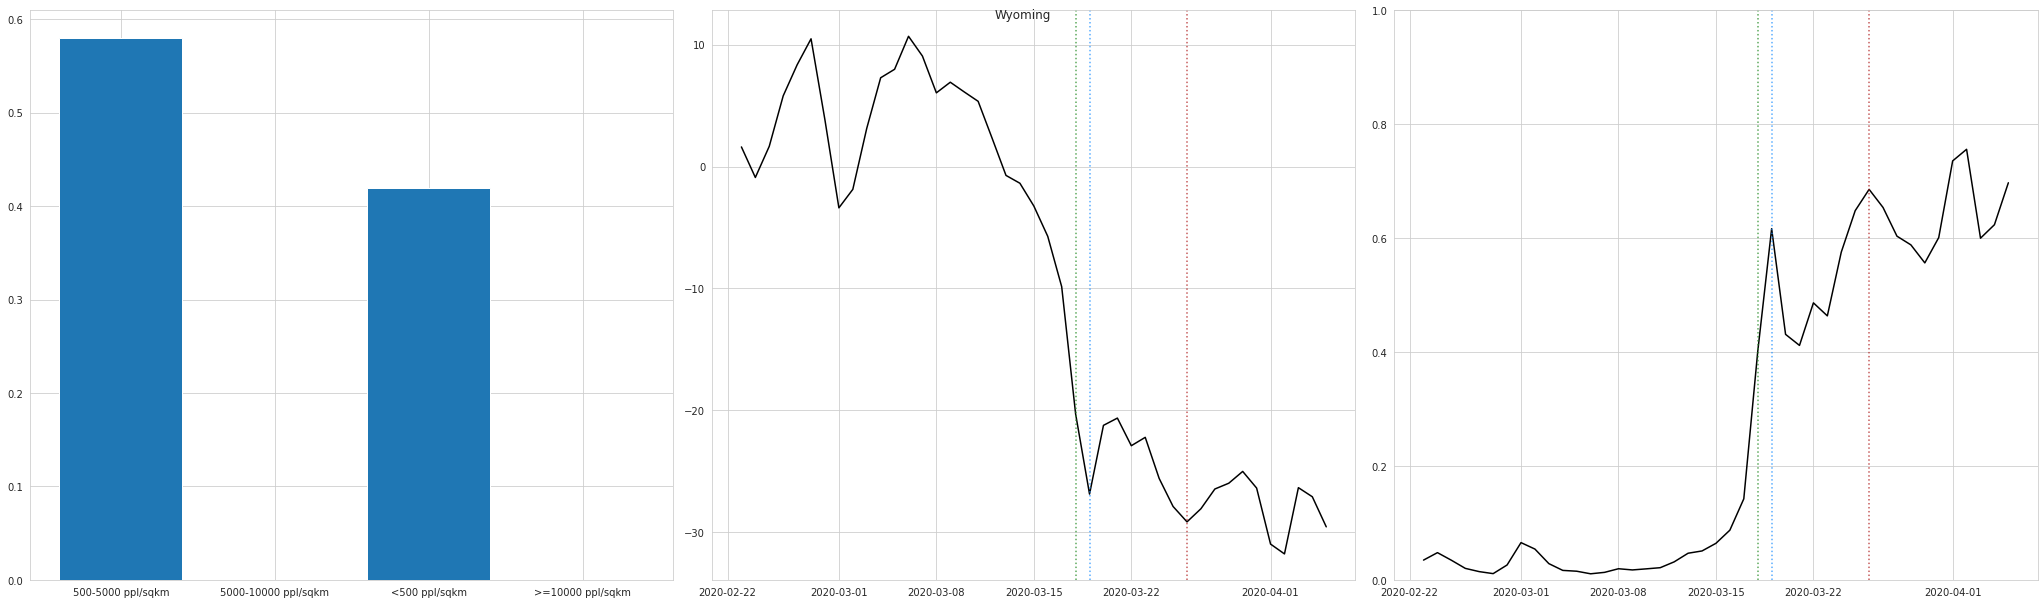

In [9]:
with PdfPages(f'/ihme/homes/rmbarber/logistic_mobility_preds.pdf') as pdf:
    for location in pred_df['Location'].unique():
        plot_df = pred_df.loc[pred_df['Location'] == location].reset_index(drop=True)
        if not plot_df['R0 date'].isnull().all():
            true_date = plot_df['R0 date'][0]
            prob_true_date = plot_df.loc[plot_df['Date'] == plot_df['R0 date'], 'probability'].item()
        else:
            true_date = None
            prob_true_date = None
        pred_cross_date_l = plot_df.loc[plot_df['probability'] >= 0.35, 'Date'].min()
        pred_cross_date_m = plot_df.loc[plot_df['probability'] >= 0.5, 'Date'].min()
        pred_cross_date_u = plot_df.loc[plot_df['probability'] >= 0.65, 'Date'].min()
        
        fig, ax = plt.subplots(1, 3, figsize=(28.5, 8.5))
        
        # pop dens
        ax[0].bar(pop_dens_vars, 
                plot_df.loc[plot_df['Date'] == plot_df['Date'].min(), pop_dens_vars].values[0])
        # ax[0].set_xticks(rotation=60)

        # google
        ax[1].plot(plot_df['Date'],
                   plot_df['avg_mobility'], color='black')  #  ({np.round(coef_dict[google_var], 2)})
        if true_date is not None:
            ax[1].axvline(true_date, color='black', linestyle='--', alpha=0.75)
        if pred_cross_date_u is not pd.NaT:
            ax[1].axvline(pred_cross_date_l, color='forestgreen', linestyle=':', alpha=0.75)
            ax[1].axvline(pred_cross_date_m, color='dodgerblue', linestyle=':', alpha=0.75)
            ax[1].axvline(pred_cross_date_u, color='firebrick', linestyle=':', alpha=0.75)

        # model
        ax[2].plot(plot_df['Date'],
                 plot_df['probability'], color='black')
        if true_date is not None:
            ax[2].axvline(true_date, color='black', linestyle='--', alpha=0.75)
        if pred_cross_date_u is not pd.NaT:
            ax[2].axvline(pred_cross_date_l, color='forestgreen', linestyle=':', alpha=0.75)
            ax[2].axvline(pred_cross_date_m, color='dodgerblue', linestyle=':', alpha=0.75)
            ax[2].axvline(pred_cross_date_u, color='firebrick', linestyle=':', alpha=0.75)
        ax[2].set_ylim(0, 1)
        plt.suptitle(location)
        plt.tight_layout()
        pdf.savefig()
